<div class="alert alert-block alert-danger">
    <p style="text-align: center;">
        <font size="5">
            <strong>
                Projet n°7 - Implémenter un modèle de scoring
            </strong>
        </font>
    </p>
</div>

<div class="alert alert-block alert-info">
    <p style="text-align: center;">
        <font size="4">
            <strong>
                Notebook exploration <br>             
            </strong>
        </font>
    </p>
</div>

# 1: Import des packages


In [24]:
# Installation des package

# pip install graphviz
# pip install lightgbm
# pip install mlflow
# pip install fastapi
# pip install "uvicorn[standard]"

In [1]:
import numpy as np
import pandas as pd
import gc
import re
import time
import random
import mlflow
import csv
import graphviz
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import streamlit as st

import sklearn.metrics as metrics
from contextlib import contextmanager
from lightgbm import LGBMClassifier
from sklearn.preprocessing import StandardScaler
from sklearn import (
    manifold, datasets, decomposition, ensemble,
    discriminant_analysis, random_projection
)
#from sklean.decomposition import PCA
from sklearn.metrics import (
    roc_auc_score, roc_curve, confusion_matrix, adjusted_rand_score
)
from sklearn.model_selection import (
    KFold, StratifiedKFold, train_test_split, GridSearchCV
)
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.dummy import DummyClassifier
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from scipy import stats

from sklearn.utils import resample

warnings.simplefilter(action='ignore', category=FutureWarning)

C:\Users\David\AppData\Roaming\Python\Python39\site-packages\pydantic\_internal\_fields.py:128: UserWarning: Field "model_server_url" has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(
C:\Users\David\AppData\Roaming\Python\Python39\site-packages\pydantic\_internal\_config.py:317: UserWarning: Valid config keys have changed in V2:
* 'schema_extra' has been renamed to 'json_schema_extra'
  warnings.warn(message, UserWarning)


In [2]:
mlflow.autolog()

2023/10/12 15:15:11 INFO mlflow.tracking.fluent: Autologging successfully enabled for lightgbm.


2023/10/12 15:15:12 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2023/10/12 15:15:13 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.


In [5]:
#pip install --upgrade mlflow pydantic

Defaulting to user installation because normal site-packages is not writeable
                                              0.0/18.5 MB ? eta -:--:--
                                              0.1/18.5 MB 1.3 MB/s eta 0:00:15
                                              0.1/18.5 MB 1.3 MB/s eta 0:00:15
                                              0.1/18.5 MB 1.1 MB/s eta 0:00:18
                                              0.1/18.5 MB 1.1 MB/s eta 0:00:18
                                             0.2/18.5 MB 958.4 kB/s eta 0:00:20
                                             0.3/18.5 MB 871.5 kB/s eta 0:00:21
                                             0.3/18.5 MB 850.6 kB/s eta 0:00:22
                                             0.4/18.5 MB 995.6 kB/s eta 0:00:19
                                             0.4/18.5 MB 956.1 kB/s eta 0:00:19
     -                                        0.5/18.5 MB 1.1 MB/s eta 0:00:17
     -                                        0.5/18.5 

# Exploration et préparation du fichier de données

## Import des données

In [7]:
# df = pd.read_csv('0_données/application_train.csv')
# test_df = pd.read_csv('0_données/application_test.csv')
# print("Train samples: {}, test samples: {}".format(len(df), len(test_df)))
# df = pd.concat([df,test_df]).reset_index()

In [8]:
# df.shape, test_df.shape

In [9]:
# pd.concat([df,test_df])

## 1.1 Kernel

In [4]:
# %% [code]
# HOME CREDIT DEFAULT RISK COMPETITION
# Most features are created by applying min, max, mean, sum and var functions to grouped tables. 
# Little feature selection is done and overfitting might be a problem since many features are related.
# The following key ideas were used:
# - Divide or subtract important features to get rates (like annuity and income)
# - In Bureau Data: create specific features for Active credits and Closed credits
# - In Previous Applications: create specific features for Approved and Refused applications
# - Modularity: one function for each table (except bureau_balance and application_test)
# - One-hot encoding for categorical features
# All tables are joined with the application DF using the SK_ID_CURR key (except bureau_balance).
# You can use LightGBM with KFold or Stratified KFold.

# Update 16/06/2018:
# - Added Payment Rate feature
# - Removed index from features
# - Use standard KFold CV (not stratified)



@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

# One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns


In [5]:
# Preprocess application_train.csv and application_test.csv
def application_train_test(num_rows = None, nan_as_category = False):
    # Read data and merge
    df = pd.read_csv('0_données/application_train.csv', nrows= num_rows)
    test_df = pd.read_csv('0_données/application_test.csv', nrows= num_rows)
    print("Train samples: {}, test samples: {}".format(len(df), len(test_df)))
    df = pd.concat([df,test_df]).reset_index()
    # Optional: Remove 4 applications with XNA CODE_GENDER (train set)
    df = df[df['CODE_GENDER'] != 'XNA']
    
    # Categorical features with Binary encode (0 or 1; two categories)
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])
    # Categorical features with One-Hot encode
    df, cat_cols = one_hot_encoder(df, nan_as_category)
    
    # NaN values for DAYS_EMPLOYED: 365.243 -> nan
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
    # Some simple new features (percentages)
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
    del test_df
    gc.collect()
    return df

# Preprocess bureau.csv and bureau_balance.csv
def bureau_and_balance(num_rows = None, nan_as_category = True):
    bureau = pd.read_csv('0_données/bureau.csv', nrows = num_rows)
    bb = pd.read_csv('0_données/bureau_balance.csv', nrows = num_rows)
    bb, bb_cat = one_hot_encoder(bb, nan_as_category)
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)
    
    # Bureau balance: Perform aggregations and merge with bureau.csv
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bb_cat:
        bb_aggregations[col] = ['mean']
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
    del bb, bb_agg
    gc.collect()
    
    # Bureau and bureau_balance numeric features
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }
    # Bureau and bureau_balance categorical features
    cat_aggregations = {}
    for cat in bureau_cat: cat_aggregations[cat] = ['mean']
    for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ['mean']
    
    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
    # Bureau: Active credits - using only numerical aggregations
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    del active, active_agg
    gc.collect()
    # Bureau: Closed credits - using only numerical aggregations
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
    del closed, closed_agg, bureau
    gc.collect()
    return bureau_agg

# Preprocess previous_applications.csv
def previous_applications(num_rows = None, nan_as_category = True):
    prev = pd.read_csv('0_données/previous_application.csv', nrows = num_rows)
    prev, cat_cols = one_hot_encoder(prev, nan_as_category= True)
    # Days 365.243 values -> nan
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
    # Add feature: value ask / value received percentage
    prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
    # Previous applications numeric features
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
    }
    # Previous applications categorical features
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']
    
    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
    # Previous Applications: Approved Applications - only numerical features
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
    # Previous Applications: Refused Applications - only numerical features
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
    del refused, refused_agg, approved, approved_agg, prev
    gc.collect()
    return prev_agg

# Preprocess POS_CASH_balance.csv
def pos_cash(num_rows = None, nan_as_category = True):
    pos = pd.read_csv('0_données/POS_CASH_balance.csv', nrows = num_rows)
    pos, cat_cols = one_hot_encoder(pos, nan_as_category= True)
    # Features
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    
    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    # Count pos cash accounts
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
    del pos
    gc.collect()
    return pos_agg
    
# Preprocess installments_payments.csv
def installments_payments(num_rows = None, nan_as_category = True):
    ins = pd.read_csv('0_données/installments_payments.csv', nrows = num_rows)
    ins, cat_cols = one_hot_encoder(ins, nan_as_category= True)
    # Percentage and difference paid in each installment (amount paid and installment value)
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    # Days past due and days before due (no negative values)
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
    # Features: Perform aggregations
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    # Count installments accounts
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
    del ins
    gc.collect()
    return ins_agg

# Preprocess credit_card_balance.csv
def credit_card_balance(num_rows = None, nan_as_category = True):
    cc = pd.read_csv('0_données/credit_card_balance.csv', nrows = num_rows)
    cc, cat_cols = one_hot_encoder(cc, nan_as_category= True)
    # General aggregations
    cc.drop(['SK_ID_PREV'], axis= 1, inplace = True)
    cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    # Count credit card lines
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
    del cc
    gc.collect()
    return cc_agg

# LightGBM GBDT with KFold or Stratified KFold
# Parameters from Tilii kernel: https://www.kaggle.com/tilii7/olivier-lightgbm-parameters-by-bayesian-opt/code
def kfold_lightgbm(df, num_folds, stratified = False, debug= False):
    # Divide in training/validation and test data
    df = df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
    df = df.rename(columns = lambda x:x.upper())
    for i in df.columns:
        if df[i].dtypes=='object':
            df[i]=df[i].astype('bool')
    train_df = df[df['TARGET'].notnull()]
    test_df = df[df['TARGET'].isnull()]
    print("Starting LightGBM. Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))
    del df
    gc.collect()
    # Cross validation model
    if stratified:
        folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=1001)
    else:
        folds = KFold(n_splits= num_folds, shuffle=True, random_state=1001)
    # Create arrays and dataframes to store results
    oof_preds = np.zeros(train_df.shape[0])
    sub_preds = np.zeros(test_df.shape[0])
    feature_importance_df = pd.DataFrame()
    feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
    
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['TARGET'])):
        train_x, train_y = train_df[feats].iloc[train_idx], train_df['TARGET'].iloc[train_idx]
        valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['TARGET'].iloc[valid_idx]

        # LightGBM parameters found by Bayesian optimization
        clf = LGBMClassifier(
            nthread=4,
            n_estimators=10000,
            learning_rate=0.02,
            num_leaves=34,
            colsample_bytree=0.9497036,
            subsample=0.8715623,
            max_depth=8,
            reg_alpha=0.041545473,
            reg_lambda=0.0735294,
            min_split_gain=0.0222415,
            min_child_weight=39.3259775,
            silent=-1,
            verbose=-1, )

        clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], 
            eval_metric= 'auc')

        oof_preds[valid_idx] = clf.predict_proba(valid_x, num_iteration=clf.best_iteration_)[:, 1]
        sub_preds += clf.predict_proba(test_df[feats], num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits

        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = clf.feature_importances_
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx])))
        del clf, train_x, train_y, valid_x, valid_y
        gc.collect()

    print('Full AUC score %.6f' % roc_auc_score(train_df['TARGET'], oof_preds))
    # Write submission file and plot feature importance
    if not debug:
        test_df['TARGET'] = sub_preds
        test_df[['SK_ID_CURR', 'TARGET']].to_csv('1_outputs/output_kfolds', index= False)
        feature_importance_df.to_csv('1_outputs/feature_importance',index=False)
    display_importances(feature_importance_df)
    return feature_importance_df

# Display/plot feature importance
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('1_outputs/lgbm_importances01.png')


def main(debug = False):
    num_rows = 10000 if debug else None
    df = application_train_test(num_rows)
    with timer("Process bureau and bureau_balance"):
        bureau = bureau_and_balance(num_rows)
        print("Bureau df shape:", bureau.shape)
        df = df.join(bureau, how='left', on='SK_ID_CURR')
        del bureau
        gc.collect()
    with timer("Process previous_applications"):
        prev = previous_applications(num_rows)
        print("Previous applications df shape:", prev.shape)
        df = df.join(prev, how='left', on='SK_ID_CURR')
        del prev
        gc.collect()
    with timer("Process POS-CASH balance"):
        pos = pos_cash(num_rows)
        print("Pos-cash balance df shape:", pos.shape)
        df = df.join(pos, how='left', on='SK_ID_CURR')
        del pos
        gc.collect()
    with timer("Process installments payments"):
        ins = installments_payments(num_rows)
        print("Installments payments df shape:", ins.shape)
        df = df.join(ins, how='left', on='SK_ID_CURR')
        del ins
        gc.collect()
    with timer("Process credit card balance"):
        cc = credit_card_balance(num_rows)
        print("Credit card balance df shape:", cc.shape)
        df = df.join(cc, how='left', on='SK_ID_CURR')
        del cc
        gc.collect()
    with timer("Run LightGBM with kfold"):
        feat_importance = kfold_lightgbm(df, num_folds= 10, stratified= False, debug= debug)

## débug du kernel

In [12]:
# temp=main_temp(debug=True)

In [13]:
# temp.loc[:,temp.dtypes.values=='object']

In [14]:
# for i in temp.columns:
#     if temp[i].dtypes=='object':
#         temp[i]=temp[i].astype('bool')

In [15]:
# temp.dtypes.value_counts()

In [16]:
# temp['CC_NAME_CONTRACT_STATUS_Active_MIN'].dtypes

In [17]:
# kfold_lightgbm(temp, 2, stratified = False, debug= True)

In [18]:
# def main(debug = True):
#     num_rows = 10000 if debug else None
#     df = application_train_test(num_rows)
#     with timer("Process bureau and bureau_balance"):
#         bureau = bureau_and_balance(num_rows)
#         print("Bureau df shape:", bureau.shape)
#         df = df.join(bureau, how='left', on='SK_ID_CURR')
#         del bureau
#         gc.collect()
#     with timer("Process previous_applications"):
#         prev = previous_applications(num_rows)
#         print("Previous applications df shape:", prev.shape)
#         df = df.join(prev, how='left', on='SK_ID_CURR')
#         del prev
#         gc.collect()
#     with timer("Process POS-CASH balance"):
#         pos = pos_cash(num_rows)
#         print("Pos-cash balance df shape:", pos.shape)
#         df = df.join(pos, how='left', on='SK_ID_CURR')
#         del pos
#         gc.collect()
#     with timer("Process installments payments"):
#         ins = installments_payments(num_rows)
#         print("Installments payments df shape:", ins.shape)
#         df = df.join(ins, how='left', on='SK_ID_CURR')
#         del ins
#         gc.collect()
#     with timer("Process credit card balance"):
#         cc = credit_card_balance(num_rows)
#         print("Credit card balance df shape:", cc.shape)
#         df = df.join(cc, how='left', on='SK_ID_CURR')
#         del cc
#         gc.collect()
#     with timer("Run LightGBM with kfold"):
#         feat_importance = kfold_lightgbm(df, num_folds= 10, stratified= False, debug=True)

In [19]:
# dict1={'CC_NAME_CONTRACT_STATUS_Active_MIN': object, 'CC_NAME_CONTRACT_STATUS_Active_MAX': object,
# ' CC_NAME_CONTRACT_STATUS_Approved_MIN': object, 'CC_NAME_CONTRACT_STATUS_Approved_MAX': object, 'CC_NAME_CONTRACT_STATUS_Completed_MIN': object,
#  'CC_NAME_CONTRACT_STATUS_Completed_MAX': object, 'CC_NAME_CONTRACT_STATUS_Demand_MIN': object, 'CC_NAME_CONTRACT_STATUS_Demand_MAX': object,
#   'CC_NAME_CONTRACT_STATUS_Refused_MIN': object, 'CC_NAME_CONTRACT_STATUS_Refused_MAX': object, 'CC_NAME_CONTRACT_STATUS_Sent proposal_MIN': object,
#    'CC_NAME_CONTRACT_STATUS_Sent proposal_MAX': object, 'CC_NAME_CONTRACT_STATUS_Signed_MIN': object, 'CC_NAME_CONTRACT_STATUS_Signed_MAX': object,
#     'CC_NAME_CONTRACT_STATUS_nan_MIN': object, 'CC_NAME_CONTRACT_STATUS_nan_MAX': object}

In [20]:
# dict1.values(),dict1.keys()

In [21]:
# application_train_test(5000)

In [22]:

# def has_special_characters(s):
#     # Define a regular expression pattern to match JSON special characters
#     special_char_pattern = re.compile(r'["\\/\\b\\f\\n\\r\\t]')
    
#     # Search for special characters in the string
#     return bool(special_char_pattern.search(s)),special_char_pattern.search(s)

# # Check each string for special characters
# for s in temp.columns:
#     if has_special_characters(s)[0]:
#         print(f"'{s}' contains JSON special characters.",has_special_characters(s))
    

In [23]:
# feats.index('NAME_CONTRACT_TYPE_Cash_loans')

In [24]:
# feats[107][27]

In [25]:
# temp = temp.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

In [26]:
# # Check each string for special characters
# for s in temp.columns:
#     if has_special_characters(s)[0]:
#         print(f"'{s}' contains JSON special characters.",has_special_characters(s))

In [27]:
# temp = temp.rename(columns = lambda x:x.upper())

In [28]:
# temp.head()

In [29]:
# # Check each string for special characters
# for s in temp.columns:
#     if has_special_characters(s)[0]:
#         print(f"'{s}' contains JSON special characters.",has_special_characters(s))

Solution stackoverflow:  
rename les colonnes avec df = df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))


In [30]:
# Liste des erreurs/ modifs par rapport au kernal de base:
# modif des chemins d'import
# Append => concat dans application test_train
# enlever verbose dans le clf.fit
# enlever early_stopping_rounds
# ajouter le force des types
# ajouter import re
# ajouter fonctions de rename des colonnes pour retirer les caractères json et forcer en upper pour que lightgbm fonctionne correctement

## Reprise des traitements

In [31]:
# # 15 min30 pour fold =2
# kfold_lightgbm(application_train_test(), 2, stratified = False)

In [32]:
#50 min avec 2 folds, 4h+ avec 10 folds
#main()

Sauvegarde du print de sortie avec 2 folds <br>
Train samples: 307511, test samples: 48744  <br>
Bureau df shape: (305811, 116)  <br>
Process bureau and bureau_balance - done in 28s <br>
Previous applications df shape: (338857, 249) <br>
Process previous_applications - done in 40s <br>
Pos-cash balance df shape: (337252, 18) <br>
Process POS-CASH balance - done in 18s <br>
Installments payments df shape: (339587, 26) <br>
Process installments payments - done in 35s <br>
Credit card balance df shape: (103558, 141) <br>
Process credit card balance - done in 23s <br>
Starting LightGBM. Train shape: (307507, 798), test shape: (48744, 798) <br>
Fold  1 AUC : 0.766699 <br>
Fold  2 AUC : 0.767250 <br>
Full AUC score 0.766974 <br>
Run LightGBM with kfold - done in 2798s <br>
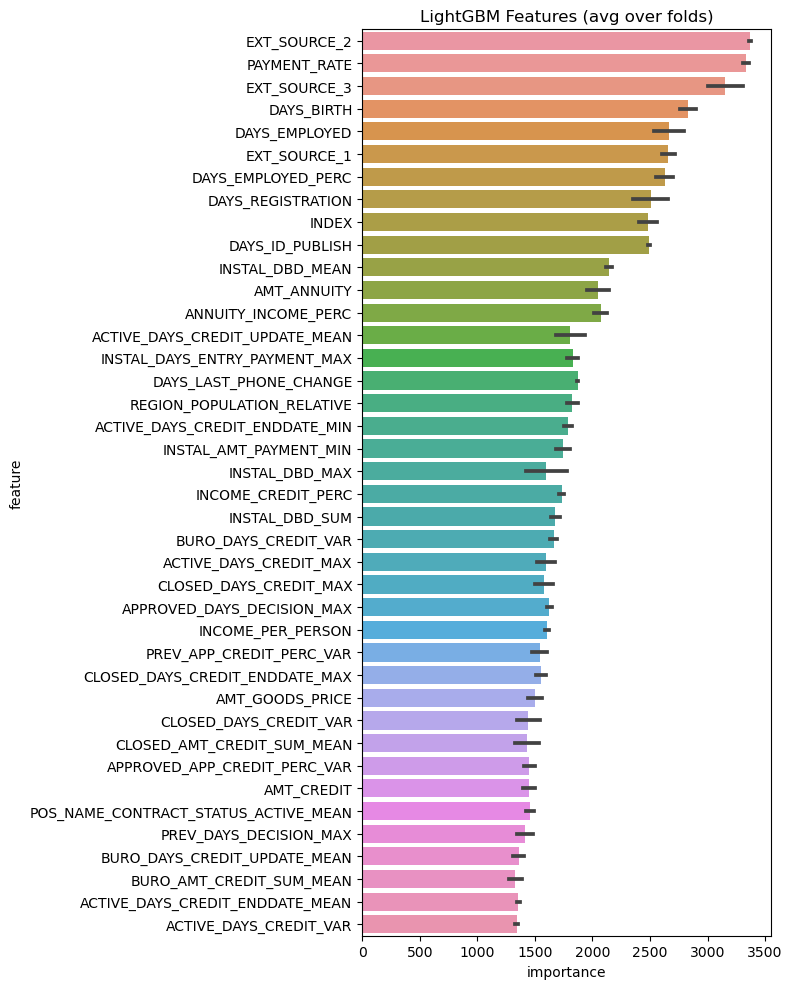

## Création des fichiers des df après pré-process

In [33]:
# feat_important=['EXT_SOURCE_2','PAYMENT_RATE','EXT_SOURCE_3','DAYS_BIRTH','DAYS_EMPLOYED','EXT_SOURCE_1','DAYS_EMPLOYED_PERC','DAYS_REGISTRATION','INDEX','DAYS_ID_PUBLISH',
# 'INSTAL_DBD_MEAN','AMT_ANNUITY','ANNUITY_INCOME_PERC','ACTIVE_DAYS_CREDIT_UPDATE_MEAN','INSTAL_DAYS_ENTRY_PAYMENT_MAX','DAYS_LAST_PHONE_CHANGE','REGION_POPULATION_RELATIVE','ACTIVE_DAYS_CREDIT_ENDDATE_MIN',
# 'CLOSED_DAYS_CREDIT_MAX','APPROVED_DAYS_DECISION_MAX','INCOME_PER_PERSON','PREV_APP_CREDIT_PERC_VAR','CLOSED_DAYS_CREDIT_ENDDATE_MAX','AMT_GOODS_PRICE','CLOSED_DAYS_CREDIT_VAR','CLOSED_AMT_CREDIT_SUM_MEAN',
# 'APPROVED_APP_CREDIT_PERC_VAR','AMT_CREDIT','POS_NAME_CONTRACT_STATUS_ACTIVE_MEAN','PREV_DAYS_DECISION_MAX','BURO_DAYS_CREDIT_UPDATE_MEAN','BURO_AMT_CREDIT_SUM_MEAN','ACTIVE_DAYS_CREDIT_ENDDATE_MEAN','ACTIVE_DAYS_CREDIT_VAR']

In [34]:
# df_test_train
# df_bureau_balance
# df_prev_app
# df_pos_cash
# df_payments
# df_card_balance


In [35]:
def visu_df(dataframe):
    return display('Shape',dataframe.shape,'Describe',dataframe.describe(),'Head',dataframe.head())

In [36]:
df_test_train=application_train_test(num_rows = None, nan_as_category = False).copy()

Train samples: 307511, test samples: 48744


In [37]:
temp=df_test_train.set_index('SK_ID_CURR')
temp.index.rename('ID',inplace=True)
temp.insert(1,'SK_ID_CURR',temp.index)
temp.head()
df_test_train=temp.copy()

In [38]:
visu_df(df_test_train)

'Shape'

(356251, 248)

'Describe'

,index,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,DAYS_EMPLOYED_PERC,INCOME_CREDIT_PERC,INCOME_PER_PERSON,ANNUITY_INCOME_PERC,PAYMENT_RATE
count,356251.000000,356251.000000,307507.00000,356251.000000,356251.000000,356251.000000,356251.000000,3.562510e+05,3.562510e+05,356215.000000,...,308683.000000,308683.000000,308683.000000,308683.000000,308683.000000,291603.000000,356251.000000,3.562490e+05,356215.000000,356215.000000
mean,136052.869904,278128.870078,0.08073,0.660001,0.339699,0.306764,0.414312,1.701159e+05,5.877695e+05,27425.644390,...,0.006282,0.029995,0.231691,0.304400,1.911544,0.157797,0.411925,9.378647e+04,0.181212,0.055463
std,93841.582375,102842.068890,0.27242,0.473709,0.473608,0.461151,0.720376,2.235080e+05,3.986253e+05,14732.860946,...,0.104251,0.191375,0.855940,0.786919,1.865330,0.133449,0.496408,9.810132e+04,0.094701,0.023206
min,0.000000,100001.000000,0.00000,0.000000,0.000000,0.000000,0.000000,2.565000e+04,4.500000e+04,1615.500000,...,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,0.011801,2.812500e+03,0.000224,0.022073
25%,44532.000000,189065.500000,0.00000,0.000000,0.000000,0.000000,0.000000,1.125000e+05,2.700000e+05,16731.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.056954,0.200000,4.950000e+04,0.114950,0.038080
50%,129384.000000,278129.000000,0.00000,1.000000,0.000000,0.000000,0.000000,1.530000e+05,5.002110e+05,25078.500000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.120073,0.316570,7.500000e+04,0.163182,0.050000
75%,218447.500000,367192.500000,0.00000,1.000000,1.000000,1.000000,1.000000,2.025000e+05,7.975575e+05,34960.500000,...,0.000000,0.000000,0.000000,0.000000,3.000000,0.220597,0.500000,1.125000e+05,0.229156,0.067066
max,307510.000000,456255.000000,1.00000,1.000000,1.000000,1.000000,20.000000,1.170000e+08,4.050000e+06,258025.500000,...,9.000000,8.000000,27.000000,261.000000,25.000000,0.728811,208.003328,3.900000e+07,2.024714,0.124430


'Head'

,index,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,DAYS_EMPLOYED_PERC,INCOME_CREDIT_PERC,INCOME_PER_PERSON,ANNUITY_INCOME_PERC,PAYMENT_RATE
ID,,,,,,,,,,,,,,,,,,,,,
100002,0,100002,1.0,0,0,0,0,202500.0,406597.5,24700.5,...,False,True,False,True,False,0.067329,0.498036,202500.0,0.121978,0.060749
100003,1,100003,0.0,1,0,1,0,270000.0,1293502.5,35698.5,...,False,False,False,True,False,0.070862,0.208736,135000.0,0.132217,0.027598
100004,2,100004,0.0,0,1,0,0,67500.0,135000.0,6750.0,...,False,False,False,False,False,0.011814,0.500000,67500.0,0.100000,0.050000
100006,3,100006,0.0,1,0,0,0,135000.0,312682.5,29686.5,...,False,False,False,False,False,0.159905,0.431748,67500.0,0.219900,0.094941
100007,4,100007,0.0,0,0,0,0,121500.0,513000.0,21865.5,...,False,False,False,False,False,0.152418,0.236842,121500.0,0.179963,0.042623


In [39]:
df_bureau_balance=bureau_and_balance(num_rows = None, nan_as_category = True).copy()

In [40]:
visu_df(df_bureau_balance)

'Shape'

(305811, 116)

'Describe'

,BURO_DAYS_CREDIT_MIN,BURO_DAYS_CREDIT_MAX,BURO_DAYS_CREDIT_MEAN,BURO_DAYS_CREDIT_VAR,BURO_DAYS_CREDIT_ENDDATE_MIN,BURO_DAYS_CREDIT_ENDDATE_MAX,BURO_DAYS_CREDIT_ENDDATE_MEAN,BURO_DAYS_CREDIT_UPDATE_MEAN,BURO_CREDIT_DAY_OVERDUE_MAX,BURO_CREDIT_DAY_OVERDUE_MEAN,...,CLOSED_AMT_CREDIT_SUM_OVERDUE_MEAN,CLOSED_AMT_CREDIT_SUM_LIMIT_MEAN,CLOSED_AMT_CREDIT_SUM_LIMIT_SUM,CLOSED_AMT_ANNUITY_MAX,CLOSED_AMT_ANNUITY_MEAN,CLOSED_CNT_CREDIT_PROLONG_SUM,CLOSED_MONTHS_BALANCE_MIN_MIN,CLOSED_MONTHS_BALANCE_MAX_MAX,CLOSED_MONTHS_BALANCE_SIZE_MEAN,CLOSED_MONTHS_BALANCE_SIZE_SUM
count,305811.000000,305811.000000,305811.000000,2.642910e+05,303226.000000,303226.000000,303226.000000,305811.000000,305811.000000,305811.000000,...,267925.000000,2.299410e+05,2.679250e+05,9.519700e+04,9.519700e+04,267925.000000,118495.000000,118495.000000,118495.000000,267925.000000
mean,-1764.362845,-490.942608,-1083.802103,4.856008e+05,-1029.705151,4508.643464,662.420814,-542.965748,4.436629,0.965926,...,3.329939,9.946875e+02,3.309811e+03,2.961504e+04,1.360898e+04,0.015012,-60.204161,-2.460475,37.116217,69.093414
std,859.260807,533.529324,558.441124,4.627030e+05,2621.100512,9422.717152,3282.359178,446.427113,85.573591,24.957209,...,1234.759685,1.215996e+04,3.683350e+04,6.732444e+05,2.376805e+05,0.144439,25.717925,9.682761,19.664782,129.503126
min,-2922.000000,-2922.000000,-2922.000000,0.000000e+00,-42060.000000,-41875.000000,-41875.000000,-41890.000000,0.000000,0.000000,...,0.000000,-8.687587e+03,-3.475035e+04,0.000000e+00,0.000000e+00,0.000000,-96.000000,-94.000000,1.000000,0.000000
25%,-2583.000000,-623.000000,-1431.000000,1.257143e+05,-2128.000000,126.000000,-697.525000,-773.696154,0.000000,0.000000,...,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,-85.000000,0.000000,22.000000,0.000000
50%,-1822.000000,-305.000000,-1052.500000,3.803969e+05,-1272.000000,912.000000,-131.788889,-479.300000,0.000000,0.000000,...,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,-62.000000,0.000000,35.000000,0.000000
75%,-1045.000000,-149.000000,-670.369318,7.130844e+05,-458.000000,1692.000000,613.000000,-209.000000,0.000000,0.000000,...,0.000000,0.000000e+00,0.000000e+00,1.562013e+04,9.047864e+03,0.000000,-39.000000,0.000000,49.800000,89.000000
max,0.000000,0.000000,0.000000,4.173160e+06,31198.000000,31199.000000,31198.000000,14.000000,2792.000000,2776.000000,...,617070.000000,1.125000e+06,2.250000e+06,1.184534e+08,5.456266e+07,6.000000,0.000000,0.000000,97.000000,2609.000000


'Head'

,BURO_DAYS_CREDIT_MIN,BURO_DAYS_CREDIT_MAX,BURO_DAYS_CREDIT_MEAN,BURO_DAYS_CREDIT_VAR,BURO_DAYS_CREDIT_ENDDATE_MIN,BURO_DAYS_CREDIT_ENDDATE_MAX,BURO_DAYS_CREDIT_ENDDATE_MEAN,BURO_DAYS_CREDIT_UPDATE_MEAN,BURO_CREDIT_DAY_OVERDUE_MAX,BURO_CREDIT_DAY_OVERDUE_MEAN,...,CLOSED_AMT_CREDIT_SUM_OVERDUE_MEAN,CLOSED_AMT_CREDIT_SUM_LIMIT_MEAN,CLOSED_AMT_CREDIT_SUM_LIMIT_SUM,CLOSED_AMT_ANNUITY_MAX,CLOSED_AMT_ANNUITY_MEAN,CLOSED_CNT_CREDIT_PROLONG_SUM,CLOSED_MONTHS_BALANCE_MIN_MIN,CLOSED_MONTHS_BALANCE_MAX_MAX,CLOSED_MONTHS_BALANCE_SIZE_MEAN,CLOSED_MONTHS_BALANCE_SIZE_SUM
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,-1572,-49,-735.000000,240043.666667,-1329.0,1778.0,82.428571,-93.142857,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-51.0,0.0,35.0,140.0
100002,-1437,-103,-874.000000,186150.000000,-1072.0,780.0,-349.000000,-499.875000,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-47.0,0.0,15.0,90.0
100003,-2586,-606,-1400.750000,827783.583333,-2434.0,1216.0,-544.500000,-816.000000,0,0.0,...,0.0,0.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,0.0
100004,-1326,-408,-867.000000,421362.000000,-595.0,-382.0,-488.500000,-532.000000,0,0.0,...,0.0,0.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,0.0
100005,-373,-62,-190.666667,26340.333333,-128.0,1324.0,439.333333,-54.333333,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-12.0,0.0,13.0,13.0


In [41]:
df_prev_app=previous_applications(num_rows = None, nan_as_category = True).copy()

In [42]:
visu_df(df_prev_app)

'Shape'

(338857, 249)

'Describe'

,PREV_AMT_ANNUITY_MIN,PREV_AMT_ANNUITY_MAX,PREV_AMT_ANNUITY_MEAN,PREV_AMT_APPLICATION_MIN,PREV_AMT_APPLICATION_MAX,PREV_AMT_APPLICATION_MEAN,PREV_AMT_CREDIT_MIN,PREV_AMT_CREDIT_MAX,PREV_AMT_CREDIT_MEAN,PREV_APP_CREDIT_PERC_MIN,...,REFUSED_HOUR_APPR_PROCESS_START_MAX,REFUSED_HOUR_APPR_PROCESS_START_MEAN,REFUSED_RATE_DOWN_PAYMENT_MIN,REFUSED_RATE_DOWN_PAYMENT_MAX,REFUSED_RATE_DOWN_PAYMENT_MEAN,REFUSED_DAYS_DECISION_MIN,REFUSED_DAYS_DECISION_MAX,REFUSED_DAYS_DECISION_MEAN,REFUSED_CNT_PAYMENT_MEAN,REFUSED_CNT_PAYMENT_SUM
count,338377.000000,338377.000000,338377.000000,3.388570e+05,3.388570e+05,3.388570e+05,3.388570e+05,3.388570e+05,3.388570e+05,338605.000000,...,118277.000000,118277.000000,52605.000000,52605.000000,52605.000000,118277.000000,118277.000000,118277.000000,108096.000000,118277.000000
mean,7912.938354,23944.281570,14656.028970,4.405501e+04,3.775473e+05,1.544683e+05,4.819918e+04,4.167555e+05,1.703318e+05,0.793707,...,13.288103,12.429229,0.050500,0.072847,0.060898,-984.352123,-724.998267,-846.055465,20.276181,49.005386
std,7603.257835,19264.040276,10093.856491,9.350608e+04,4.219383e+05,1.526145e+05,9.644586e+04,4.574522e+05,1.649810e+05,0.350306,...,3.376286,3.107724,0.088162,0.103926,0.090671,830.032165,740.460607,739.365204,17.564565,78.842269
min,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,-2922.000000,-2922.000000,-2922.000000,0.000000,0.000000
25%,3499.290000,10525.725000,7908.423750,0.000000e+00,9.957150e+04,6.259770e+04,0.000000e+00,1.061505e+05,6.741675e+04,0.814972,...,11.000000,10.166667,0.000000,0.000000,0.000000,-1519.000000,-972.000000,-1202.166667,6.000000,6.000000
50%,5750.775000,18081.270000,12092.197500,1.755000e+04,2.105100e+05,1.068345e+05,2.318850e+04,2.250000e+05,1.181655e+05,0.898449,...,13.000000,12.333333,0.000000,0.000000,0.000000,-642.000000,-403.000000,-551.000000,14.000000,24.000000
75%,9550.260000,31840.875000,18489.159000,5.393250e+04,4.635000e+05,1.916936e+05,5.822550e+04,5.539500e+05,2.164125e+05,1.000000,...,16.000000,14.600000,0.106815,0.108926,0.108909,-325.000000,-218.000000,-294.000000,31.500000,60.000000
max,300425.445000,418058.145000,300425.445000,4.050000e+06,6.905160e+06,4.050000e+06,4.050000e+06,6.905160e+06,4.050000e+06,10.000000,...,23.000000,23.000000,0.907515,0.939195,0.907515,-2.000000,-2.000000,-2.000000,84.000000,1728.000000


'Head'

,PREV_AMT_ANNUITY_MIN,PREV_AMT_ANNUITY_MAX,PREV_AMT_ANNUITY_MEAN,PREV_AMT_APPLICATION_MIN,PREV_AMT_APPLICATION_MAX,PREV_AMT_APPLICATION_MEAN,PREV_AMT_CREDIT_MIN,PREV_AMT_CREDIT_MAX,PREV_AMT_CREDIT_MEAN,PREV_APP_CREDIT_PERC_MIN,...,REFUSED_HOUR_APPR_PROCESS_START_MAX,REFUSED_HOUR_APPR_PROCESS_START_MEAN,REFUSED_RATE_DOWN_PAYMENT_MIN,REFUSED_RATE_DOWN_PAYMENT_MAX,REFUSED_RATE_DOWN_PAYMENT_MEAN,REFUSED_DAYS_DECISION_MIN,REFUSED_DAYS_DECISION_MAX,REFUSED_DAYS_DECISION_MEAN,REFUSED_CNT_PAYMENT_MEAN,REFUSED_CNT_PAYMENT_SUM
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,3951.000,3951.000,3951.000,24835.5,24835.5,24835.50,23787.0,23787.0,23787.00,1.044079,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100002,9251.775,9251.775,9251.775,179055.0,179055.0,179055.00,179055.0,179055.0,179055.00,1.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100003,6737.310,98356.995,56553.990,68809.5,900000.0,435436.50,68053.5,1035882.0,484191.00,0.868825,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100004,5357.250,5357.250,5357.250,24282.0,24282.0,24282.00,20106.0,20106.0,20106.00,1.207699,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100005,4813.200,4813.200,4813.200,0.0,44617.5,22308.75,0.0,40153.5,20076.75,1.111173,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [43]:
df_pos_cash=pos_cash(num_rows = None, nan_as_category = True).copy()

In [44]:
visu_df(df_pos_cash)

'Shape'

(337252, 18)

'Describe'

,POS_MONTHS_BALANCE_MAX,POS_MONTHS_BALANCE_MEAN,POS_MONTHS_BALANCE_SIZE,POS_SK_DPD_MAX,POS_SK_DPD_MEAN,POS_SK_DPD_DEF_MAX,POS_SK_DPD_DEF_MEAN,POS_NAME_CONTRACT_STATUS_Active_MEAN,POS_NAME_CONTRACT_STATUS_Amortized debt_MEAN,POS_NAME_CONTRACT_STATUS_Approved_MEAN,POS_NAME_CONTRACT_STATUS_Canceled_MEAN,POS_NAME_CONTRACT_STATUS_Completed_MEAN,POS_NAME_CONTRACT_STATUS_Demand_MEAN,POS_NAME_CONTRACT_STATUS_Returned to the store_MEAN,POS_NAME_CONTRACT_STATUS_Signed_MEAN,POS_NAME_CONTRACT_STATUS_XNA_MEAN,POS_NAME_CONTRACT_STATUS_nan_MEAN,POS_COUNT
count,337252.000000,337252.000000,337252.000000,337252.000000,337252.000000,337252.000000,337252.000000,337252.000000,337252.000000,337252.000000,337252.000000,337252.000000,337252.000000,337252.000000,337252.000000,3.372520e+05,337252.0,337252.000000
mean,-12.591605,-31.873263,29.655445,15.294106,4.296271,1.473355,0.225470,0.903948,0.000021,0.000595,0.000003,0.083706,0.000276,0.000839,0.010611,3.672319e-08,0.0,29.655445
std,18.648620,20.081193,24.531971,151.343806,59.717229,32.337266,13.554576,0.075490,0.003075,0.007529,0.000698,0.064431,0.011630,0.010447,0.032589,1.508067e-05,0.0,24.531971
min,-96.000000,-96.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.0,1.000000
25%,-15.000000,-43.988354,12.000000,0.000000,0.000000,0.000000,0.000000,0.875000,0.000000,0.000000,0.000000,0.048387,0.000000,0.000000,0.000000,0.000000e+00,0.0,12.000000
50%,-4.000000,-28.571429,22.000000,0.000000,0.000000,0.000000,0.000000,0.916667,0.000000,0.000000,0.000000,0.076923,0.000000,0.000000,0.000000,0.000000e+00,0.0,22.000000
75%,-2.000000,-15.500000,39.000000,0.000000,0.000000,0.000000,0.000000,0.945946,0.000000,0.000000,0.000000,0.108696,0.000000,0.000000,0.000000,0.000000e+00,0.0,39.000000
max,-1.000000,-1.000000,295.000000,4231.000000,2622.078431,3595.000000,1740.554455,1.000000,0.711340,1.000000,0.333333,1.000000,0.793103,1.000000,1.000000,6.250000e-03,0.0,295.000000


'Head'

,POS_MONTHS_BALANCE_MAX,POS_MONTHS_BALANCE_MEAN,POS_MONTHS_BALANCE_SIZE,POS_SK_DPD_MAX,POS_SK_DPD_MEAN,POS_SK_DPD_DEF_MAX,POS_SK_DPD_DEF_MEAN,POS_NAME_CONTRACT_STATUS_Active_MEAN,POS_NAME_CONTRACT_STATUS_Amortized debt_MEAN,POS_NAME_CONTRACT_STATUS_Approved_MEAN,POS_NAME_CONTRACT_STATUS_Canceled_MEAN,POS_NAME_CONTRACT_STATUS_Completed_MEAN,POS_NAME_CONTRACT_STATUS_Demand_MEAN,POS_NAME_CONTRACT_STATUS_Returned to the store_MEAN,POS_NAME_CONTRACT_STATUS_Signed_MEAN,POS_NAME_CONTRACT_STATUS_XNA_MEAN,POS_NAME_CONTRACT_STATUS_nan_MEAN,POS_COUNT
SK_ID_CURR,,,,,,,,,,,,,,,,,,
100001,-53,-72.555556,9,7,0.777778,7,0.777778,0.777778,0.0,0.0,0.0,0.222222,0.0,0.0,0.000000,0.0,0.0,9
100002,-1,-10.000000,19,0,0.000000,0,0.000000,1.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,19
100003,-18,-43.785714,28,0,0.000000,0,0.000000,0.928571,0.0,0.0,0.0,0.071429,0.0,0.0,0.000000,0.0,0.0,28
100004,-24,-25.500000,4,0,0.000000,0,0.000000,0.750000,0.0,0.0,0.0,0.250000,0.0,0.0,0.000000,0.0,0.0,4
100005,-15,-20.000000,11,0,0.000000,0,0.000000,0.818182,0.0,0.0,0.0,0.090909,0.0,0.0,0.090909,0.0,0.0,11


In [45]:
df_payments=installments_payments(num_rows = None, nan_as_category = True).copy()

In [46]:
visu_df(df_payments)

'Shape'

(339587, 26)

'Describe'

,INSTAL_NUM_INSTALMENT_VERSION_NUNIQUE,INSTAL_DPD_MAX,INSTAL_DPD_MEAN,INSTAL_DPD_SUM,INSTAL_DBD_MAX,INSTAL_DBD_MEAN,INSTAL_DBD_SUM,INSTAL_PAYMENT_PERC_MAX,INSTAL_PAYMENT_PERC_MEAN,INSTAL_PAYMENT_PERC_SUM,...,INSTAL_AMT_INSTALMENT_MEAN,INSTAL_AMT_INSTALMENT_SUM,INSTAL_AMT_PAYMENT_MIN,INSTAL_AMT_PAYMENT_MAX,INSTAL_AMT_PAYMENT_MEAN,INSTAL_AMT_PAYMENT_SUM,INSTAL_DAYS_ENTRY_PAYMENT_MAX,INSTAL_DAYS_ENTRY_PAYMENT_MEAN,INSTAL_DAYS_ENTRY_PAYMENT_SUM,INSTAL_COUNT
count,339587.000000,339587.000000,339587.000000,339587.000000,339587.000000,339587.000000,339587.000000,3.395780e+05,339559.000000,339568.000000,...,3.395870e+05,3.395870e+05,3.395780e+05,3.395780e+05,3.395780e+05,3.395870e+05,339578.000000,339578.000000,339587.00000,339587.000000
mean,2.303413,17.843637,1.027073,41.417275,37.944235,12.283245,393.405566,inf,1.360340,51.205700,...,1.861577e+04,6.831369e+05,5.282753e+03,1.400438e+05,1.900381e+04,6.904942e+05,-328.433435,-922.095504,-42103.40703,40.064552
std,1.870607,108.273851,8.813836,326.815463,28.862360,9.181630,408.301149,NaN,28.429930,846.431025,...,2.346509e+04,8.933805e+05,1.449867e+04,2.496554e+05,2.523135e+04,9.308977e+05,537.367821,597.181989,56863.13532,41.053343
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.121918e-01,0.333333,0.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,2.250000e-01,1.890000e-01,0.000000e+00,-3071.000000,-3071.000000,-602499.00000,1.000000
25%,1.000000,0.000000,0.000000,0.000000,23.000000,6.681008,134.000000,1.000000e+00,0.955224,12.000000,...,7.897470e+03,1.366834e+05,4.153500e+01,1.439653e+04,7.582365e+03,1.332007e+05,-387.000000,-1312.043107,-49853.00000,12.000000
50%,2.000000,1.000000,0.035714,1.000000,31.000000,10.125000,267.000000,1.000000e+00,1.000000,24.617193,...,1.272616e+04,3.343952e+05,2.323575e+03,3.703561e+04,1.240398e+04,3.248035e+05,-65.000000,-806.576364,-21233.00000,25.000000
75%,3.000000,9.000000,0.500000,20.000000,43.000000,15.151134,510.000000,1.000000e+00,1.000000,51.000000,...,2.164516e+04,8.577727e+05,7.158724e+03,1.350000e+05,2.164505e+04,8.497309e+05,-26.000000,-433.857143,-6832.00000,51.000000
max,59.000000,2884.000000,1885.386364,82957.000000,3189.000000,295.000000,10529.000000,inf,8482.446155,194505.460372,...,2.504590e+06,3.247978e+07,2.504590e+06,3.771488e+06,2.504590e+06,3.268928e+07,-1.000000,-3.000000,0.00000,372.000000


'Head'

,INSTAL_NUM_INSTALMENT_VERSION_NUNIQUE,INSTAL_DPD_MAX,INSTAL_DPD_MEAN,INSTAL_DPD_SUM,INSTAL_DBD_MAX,INSTAL_DBD_MEAN,INSTAL_DBD_SUM,INSTAL_PAYMENT_PERC_MAX,INSTAL_PAYMENT_PERC_MEAN,INSTAL_PAYMENT_PERC_SUM,...,INSTAL_AMT_INSTALMENT_MEAN,INSTAL_AMT_INSTALMENT_SUM,INSTAL_AMT_PAYMENT_MIN,INSTAL_AMT_PAYMENT_MAX,INSTAL_AMT_PAYMENT_MEAN,INSTAL_AMT_PAYMENT_SUM,INSTAL_DAYS_ENTRY_PAYMENT_MAX,INSTAL_DAYS_ENTRY_PAYMENT_MEAN,INSTAL_DAYS_ENTRY_PAYMENT_SUM,INSTAL_COUNT
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,2,11.0,1.571429,11.0,36.0,8.857143,62.0,1.0,1.0,7.0,...,5885.132143,41195.925,3951.000,17397.900,5885.132143,41195.925,-1628.0,-2195.000000,-15365.0,7
100002,2,0.0,0.000000,0.0,31.0,20.421053,388.0,1.0,1.0,19.0,...,11559.247105,219625.695,9251.775,53093.745,11559.247105,219625.695,-49.0,-315.421053,-5993.0,19
100003,2,0.0,0.000000,0.0,14.0,7.160000,179.0,1.0,1.0,25.0,...,64754.586000,1618864.650,6662.970,560835.360,64754.586000,1618864.650,-544.0,-1385.320000,-34633.0,25
100004,2,0.0,0.000000,0.0,11.0,7.666667,23.0,1.0,1.0,3.0,...,7096.155000,21288.465,5357.250,10573.965,7096.155000,21288.465,-727.0,-761.666667,-2285.0,3
100005,2,1.0,0.111111,1.0,37.0,23.666667,213.0,1.0,1.0,9.0,...,6240.205000,56161.845,4813.200,17656.245,6240.205000,56161.845,-470.0,-609.555556,-5486.0,9


In [47]:
df_card_balance=credit_card_balance(num_rows = None, nan_as_category = True).copy()

In [48]:
visu_df(df_card_balance)

'Shape'

(103558, 141)

'Describe'

,CC_MONTHS_BALANCE_MIN,CC_MONTHS_BALANCE_MAX,CC_MONTHS_BALANCE_MEAN,CC_MONTHS_BALANCE_SUM,CC_MONTHS_BALANCE_VAR,CC_AMT_BALANCE_MIN,CC_AMT_BALANCE_MAX,CC_AMT_BALANCE_MEAN,CC_AMT_BALANCE_SUM,CC_AMT_BALANCE_VAR,...,CC_NAME_CONTRACT_STATUS_Sent proposal_MEAN,CC_NAME_CONTRACT_STATUS_Sent proposal_SUM,CC_NAME_CONTRACT_STATUS_Sent proposal_VAR,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_Signed_SUM,CC_NAME_CONTRACT_STATUS_Signed_VAR,CC_NAME_CONTRACT_STATUS_nan_MEAN,CC_NAME_CONTRACT_STATUS_nan_SUM,CC_NAME_CONTRACT_STATUS_nan_VAR,CC_COUNT
count,103558.000000,103558.000000,103558.000000,103558.000000,102866.000000,103558.000000,1.035580e+05,103558.000000,1.035580e+05,1.028660e+05,...,103558.000000,103558.000000,102866.000000,103558.000000,103558.000000,102866.000000,103558.0,103558.0,102866.0,103558.000000
mean,-37.534531,-1.518965,-19.505553,-1280.199946,211.898513,10542.130509,1.422979e+05,69973.192455,2.161984e+06,5.626113e+09,...,0.000059,0.004954,0.000060,0.003583,0.106781,0.002955,0.0,0.0,0.0,37.083683
std,33.379821,0.734817,16.666571,1743.939291,289.025923,44311.662362,1.713255e+05,107537.810551,3.269300e+06,1.484490e+10,...,0.000846,0.070209,0.000849,0.031014,1.272522,0.019938,0.0,0.0,0.0,33.483627
min,-96.000000,-12.000000,-50.179775,-9312.000000,0.500000,-420250.185000,0.000000e+00,-2930.232558,-1.260000e+05,0.000000e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,1.000000
25%,-75.000000,-2.000000,-38.000000,-2850.000000,9.166667,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,10.000000
50%,-22.000000,-1.000000,-12.000000,-253.000000,42.166667,0.000000,9.610718e+04,24997.602995,7.013641e+05,7.535426e+08,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,22.000000
75%,-11.000000,-1.000000,-6.000000,-65.000000,475.000000,0.000000,1.946125e+05,96997.746023,2.979703e+06,4.480692e+09,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,75.000000
max,-1.000000,-1.000000,-1.000000,-1.000000,880.521515,869873.535000,1.505902e+06,928686.323571,2.998048e+07,3.439325e+11,...,0.024390,1.000000,0.024390,1.000000,62.000000,0.500000,0.0,0.0,0.0,192.000000


'Head'

,CC_MONTHS_BALANCE_MIN,CC_MONTHS_BALANCE_MAX,CC_MONTHS_BALANCE_MEAN,CC_MONTHS_BALANCE_SUM,CC_MONTHS_BALANCE_VAR,CC_AMT_BALANCE_MIN,CC_AMT_BALANCE_MAX,CC_AMT_BALANCE_MEAN,CC_AMT_BALANCE_SUM,CC_AMT_BALANCE_VAR,...,CC_NAME_CONTRACT_STATUS_Signed_MAX,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_Signed_SUM,CC_NAME_CONTRACT_STATUS_Signed_VAR,CC_NAME_CONTRACT_STATUS_nan_MIN,CC_NAME_CONTRACT_STATUS_nan_MAX,CC_NAME_CONTRACT_STATUS_nan_MEAN,CC_NAME_CONTRACT_STATUS_nan_SUM,CC_NAME_CONTRACT_STATUS_nan_VAR,CC_COUNT
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100006,-6,-1,-3.5,-21,3.5,0.0,0.00,0.000000,0.000,0.000000e+00,...,False,0.0,0,0.0,False,False,0.0,0,0.0,6
100011,-75,-2,-38.5,-2849,462.5,0.0,189000.00,54482.111149,4031676.225,4.641321e+09,...,False,0.0,0,0.0,False,False,0.0,0,0.0,74
100013,-96,-1,-48.5,-4656,776.0,0.0,161420.22,18159.919219,1743352.245,1.869473e+09,...,False,0.0,0,0.0,False,False,0.0,0,0.0,96
100021,-18,-2,-10.0,-170,25.5,0.0,0.00,0.000000,0.000,0.000000e+00,...,False,0.0,0,0.0,False,False,0.0,0,0.0,17
100023,-11,-4,-7.5,-60,6.0,0.0,0.00,0.000000,0.000,0.000000e+00,...,False,0.0,0,0.0,False,False,0.0,0,0.0,8


## Controle


In [49]:
list_df=[df_test_train,df_prev_app,df_bureau_balance,df_payments,df_pos_cash,df_card_balance]

In [4]:
def Controle(x):
    # DataFrame de contrôles sur les colonnes
    tempo = pd.DataFrame(columns=['nomcol', 'type', 'unique',
                    'unique%','doubl%' ,'manqu', 'manqu%', 'rempli', 'rempli%','skew'])

    tot = x.shape[0]

    tempo['nomcol'] = pd.Series(x.columns) # nom des colonnes

    for i in x.columns:
        j=list(x.columns).index(i)
        
        tempo.at[j, 'unique'] = len(x[i].unique())    # nbr de valeurs uniques prise par chaque colonne
        tempo.at[j, 'type'] = x.dtypes[i]             # type de données
        tempo.at[j, 'manqu'] = x.isnull().sum()[i]    # nombre de valeurs manquantes

        if x.isnull().sum()[i] != tot:               # valeurs uniques en % des données alimentées
            tempo.at[j, 'unique%'] = round(len(x[i].unique())/(tot-x.isnull().sum()[i])*100, 3)    
        else:
            tempo.at[j, 'unique%'] = 100   
        
 
        if tempo.at[j, 'unique'] ==1:                    # % de doublons
            tempo.at[j, 'doubl%'] = 100
    
        else:
            tempo.at[j, 'doubl%'] = 100-tempo.at[j, 'unique%']                        
    
        tempo.at[j, 'manqu%'] = round(x.isnull().sum()[i]/tot*100, 3)       # données manquantes en % du total
        tempo.at[j, 'rempli'] = tot-x.isnull().sum()[i]                     # données remplies (inverse des manquantes)
        tempo.at[j, 'rempli%'] = 100-round(x.isnull().sum()[i]/tot*100, 3)  # données remplies en %
    
    temp=x.describe().T.applymap('{:,.2f}'.format).copy()                  # describe des données numériques (min, max...)
    temp.drop(['count','std'],axis=1,inplace=True)                         # nombre et ecart-type pas ntéressants donc droppés
    tempo=tempo.merge(temp,how='left',left_on='nomcol',right_index=True)        # ajout des données numériques aux données de remplissage
    
    for i in tempo.loc[(tempo['type']!='category') & (tempo['type']!='object')]['nomcol']:                            #skew des données numériques
        tempo.at[tempo.loc[tempo['nomcol']==i].index.values[0],'skew']=x[i].skew()
    
    return tempo
# la fonction renvoie le dataframe de contrôle sur la base x fournie en variable

In [51]:
# # 3 min pour le df de contrôle des données test_train
# ctrl_df_test_train=Controle(df_test_train).copy()

In [52]:
# ctrl_df_test_train

In [53]:
# ctrl_df_test_train.loc[abs(ctrl_df_test_train['skew'])>8]

In [54]:
# df_test_train.iloc[:,247]

In [55]:
# Controle(df_test_train.iloc[:,0:100])

In [56]:
# Controle(df_test_train.iloc[:,100:200])

In [57]:
# Controle(df_test_train.iloc[:,200:248])

In [58]:
# ctrl_df_payments=Controle(df_payments).copy()
# ctrl_df_payments

In [59]:
# ctrl_df_pos_cash=Controle(df_pos_cash).copy()
# ctrl_df_pos_cash

In [60]:
# # 20 sec
# ctrl_df_card_balance=Controle(df_card_balance)
# ctrl_df_card_balance

In [61]:
# #4 min 20
# ctrl_df_prev_app=Controle(df_prev_app)
# ctrl_df_prev_app

In [62]:
# # 50 sec
# ctrl_df_bureau_balance=Controle(df_bureau_balance)
# ctrl_df_bureau_balance

In [63]:
# ctrl_df_total_1=pd.concat([ctrl_df_test_train,ctrl_df_bureau_balance,ctrl_df_pos_cash,ctrl_df_card_balance,ctrl_df_prev_app,ctrl_df_payments])

In [64]:
# ctrl_df_total_1

## Fichier des données test_train

In [65]:
df_test_train.head()

,index,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,DAYS_EMPLOYED_PERC,INCOME_CREDIT_PERC,INCOME_PER_PERSON,ANNUITY_INCOME_PERC,PAYMENT_RATE
ID,,,,,,,,,,,,,,,,,,,,,
100002,0,100002,1.0,0,0,0,0,202500.0,406597.5,24700.5,...,False,True,False,True,False,0.067329,0.498036,202500.0,0.121978,0.060749
100003,1,100003,0.0,1,0,1,0,270000.0,1293502.5,35698.5,...,False,False,False,True,False,0.070862,0.208736,135000.0,0.132217,0.027598
100004,2,100004,0.0,0,1,0,0,67500.0,135000.0,6750.0,...,False,False,False,False,False,0.011814,0.500000,67500.0,0.100000,0.050000
100006,3,100006,0.0,1,0,0,0,135000.0,312682.5,29686.5,...,False,False,False,False,False,0.159905,0.431748,67500.0,0.219900,0.094941
100007,4,100007,0.0,0,0,0,0,121500.0,513000.0,21865.5,...,False,False,False,False,False,0.152418,0.236842,121500.0,0.179963,0.042623


In [66]:
df_bureau_balance.head()

,BURO_DAYS_CREDIT_MIN,BURO_DAYS_CREDIT_MAX,BURO_DAYS_CREDIT_MEAN,BURO_DAYS_CREDIT_VAR,BURO_DAYS_CREDIT_ENDDATE_MIN,BURO_DAYS_CREDIT_ENDDATE_MAX,BURO_DAYS_CREDIT_ENDDATE_MEAN,BURO_DAYS_CREDIT_UPDATE_MEAN,BURO_CREDIT_DAY_OVERDUE_MAX,BURO_CREDIT_DAY_OVERDUE_MEAN,...,CLOSED_AMT_CREDIT_SUM_OVERDUE_MEAN,CLOSED_AMT_CREDIT_SUM_LIMIT_MEAN,CLOSED_AMT_CREDIT_SUM_LIMIT_SUM,CLOSED_AMT_ANNUITY_MAX,CLOSED_AMT_ANNUITY_MEAN,CLOSED_CNT_CREDIT_PROLONG_SUM,CLOSED_MONTHS_BALANCE_MIN_MIN,CLOSED_MONTHS_BALANCE_MAX_MAX,CLOSED_MONTHS_BALANCE_SIZE_MEAN,CLOSED_MONTHS_BALANCE_SIZE_SUM
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,-1572,-49,-735.000000,240043.666667,-1329.0,1778.0,82.428571,-93.142857,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-51.0,0.0,35.0,140.0
100002,-1437,-103,-874.000000,186150.000000,-1072.0,780.0,-349.000000,-499.875000,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-47.0,0.0,15.0,90.0
100003,-2586,-606,-1400.750000,827783.583333,-2434.0,1216.0,-544.500000,-816.000000,0,0.0,...,0.0,0.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,0.0
100004,-1326,-408,-867.000000,421362.000000,-595.0,-382.0,-488.500000,-532.000000,0,0.0,...,0.0,0.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,0.0
100005,-373,-62,-190.666667,26340.333333,-128.0,1324.0,439.333333,-54.333333,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-12.0,0.0,13.0,13.0


In [67]:
df = pd.read_csv('0_données/application_train.csv')
df

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,0,Cash loans,M,N,N,0,157500.0,254700.0,27558.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
307507,456252,0,Cash loans,F,N,Y,0,72000.0,269550.0,12001.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
307508,456253,0,Cash loans,F,N,Y,0,153000.0,677664.0,29979.0,...,0,0,0,0,1.0,0.0,0.0,1.0,0.0,1.0
307509,456254,1,Cash loans,F,N,Y,0,171000.0,370107.0,20205.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [68]:
df_test = pd.read_csv('0_données/application_test.csv')
df_test

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48739,456221,Cash loans,F,N,Y,0,121500.0,412560.0,17473.5,270000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
48740,456222,Cash loans,F,N,N,2,157500.0,622413.0,31909.5,495000.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
48741,456223,Cash loans,F,Y,Y,1,202500.0,315000.0,33205.5,315000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,3.0,1.0
48742,456224,Cash loans,M,N,N,0,225000.0,450000.0,25128.0,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0


### Définition id_train et id_test

In [69]:
id_train=df['SK_ID_CURR'].copy()
id_test=df_test['SK_ID_CURR'].copy()


In [70]:
# df_pos_cash.loc[df_pos_cash.index.isin(id_train)].head()

In [71]:
# df_pos_cash.loc[df_pos_cash.index.isin(id_test)].head()

### Définition infos train et test des fichiers

In [72]:
for i in list_df:
    print(i.loc[i.index.isin(id_test)].shape[0],i.loc[i.index.isin(id_train)].shape[0],(i.loc[i.index.isin(id_test)].shape[0])/(i.shape[0]))

48744 307507 0.1368248790880587
47800 291057 0.14106245407354726
42320 263491 0.13838612737932907
47944 291643 0.1411832608433185
47808 289444 0.1417574988435947
16653 86905 0.1608084358523726


In [73]:
list_df_namestrings=['df_test_train','df_prev_app','df_bureau_balance','df_payments','df_pos_cash','df_card_balance']


In [74]:
dict_df=dict(zip(list_df_namestrings,list_df))


In [75]:
df_infos_test_trains_fichiers=pd.DataFrame(data=list_df_namestrings,index=list_df_namestrings,columns=['namestrings'])
df_infos_test_trains_fichiers

,namestrings
df_test_train,df_test_train
df_prev_app,df_prev_app
df_bureau_balance,df_bureau_balance
df_payments,df_payments
df_pos_cash,df_pos_cash
df_card_balance,df_card_balance


In [76]:
df_infos_test_trains_fichiers['Tot']=df_infos_test_trains_fichiers['namestrings'].apply(lambda x: dict_df.get(x).shape[0])
df_infos_test_trains_fichiers['dont train']=df_infos_test_trains_fichiers['namestrings'].apply(lambda x: dict_df.get(x).loc[(dict_df.get(x)).index.isin(id_train)].shape[0])
df_infos_test_trains_fichiers['dont test']=df_infos_test_trains_fichiers['namestrings'].apply(lambda x: dict_df.get(x).loc[(dict_df.get(x)).index.isin(id_test)].shape[0])    

In [77]:
df_infos_test_trains_fichiers

,namestrings,Tot,dont train,dont test
df_test_train,df_test_train,356251,307507,48744
df_prev_app,df_prev_app,338857,291057,47800
df_bureau_balance,df_bureau_balance,305811,263491,42320
df_payments,df_payments,339587,291643,47944
df_pos_cash,df_pos_cash,337252,289444,47808
df_card_balance,df_card_balance,103558,86905,16653


In [78]:
df_infos_test_trains_fichiers['train%']=(df_infos_test_trains_fichiers['dont train']/df_infos_test_trains_fichiers['Tot']).round(2)
df_infos_test_trains_fichiers['test%']=(df_infos_test_trains_fichiers['dont test']/df_infos_test_trains_fichiers['Tot']).round(2)

In [79]:
df_infos_test_trains_fichiers

,namestrings,Tot,dont train,dont test,train%,test%
df_test_train,df_test_train,356251,307507,48744,0.86,0.14
df_prev_app,df_prev_app,338857,291057,47800,0.86,0.14
df_bureau_balance,df_bureau_balance,305811,263491,42320,0.86,0.14
df_payments,df_payments,339587,291643,47944,0.86,0.14
df_pos_cash,df_pos_cash,337252,289444,47808,0.86,0.14
df_card_balance,df_card_balance,103558,86905,16653,0.84,0.16


In [80]:
df_test_train.index

Index([100002, 100003, 100004, 100006, 100007, 100008, 100009, 100010, 100011,
       100012,
       ...
       456168, 456169, 456170, 456189, 456202, 456221, 456222, 456223, 456224,
       456250],
      dtype='int64', name='ID', length=356251)

### Test classif importance fichier par fichier

In [81]:
#df_bureau_balance=df_bureau_balance.merge(df_test_train['TARGET'],left_index=True,right_index=True,how='left')

In [82]:
# kfold_lightgbm(df_bureau_balance, 2, stratified = False)

In [83]:
#application_train_test()

In [84]:
# df_prev_app=df_prev_app.merge(df_test_train['TARGET'],left_index=True,right_index=True,how='left')
# df_pos_cash=df_pos_cash.merge(df_test_train['TARGET'],left_index=True,right_index=True,how='left')
# df_payments=df_payments.merge(df_test_train['TARGET'],left_index=True,right_index=True,how='left')
# df_card_balance=df_card_balance.merge(df_test_train['TARGET'],left_index=True,right_index=True,how='left')

In [85]:
# df_prev_app=df_prev_app.drop(['TARGET_x','TARGET_y'],axis=1)

In [86]:
# df_pos_cash=df_pos_cash.drop(['TARGET_x','TARGET_y'],axis=1)
# df_payments=df_payments.drop(['TARGET_x','TARGET_y'],axis=1)
# df_card_balance=df_card_balance.drop(['TARGET_x','TARGET_y'],axis=1)

In [87]:
#df_prev_app.head()

In [88]:
# kfold_lightgbm(df_prev_app, 2, stratified = False)

In [89]:
# kfold_lightgbm(df_pos_cash, 2, stratified = False)

In [90]:
# kfold_lightgbm(df_payments, 2, stratified = False)

In [91]:
# kfold_lightgbm(df_card_balance, 2, stratified = False)

## FICHIER GLOBAL

In [92]:
# df_total=df_test_train.merge(df_bureau_balance.drop('TARGET',axis=1),left_index=True,right_index=True,how='left').merge(df_prev_app.drop('TARGET',axis=1),left_index=True,right_index=True,how='left').merge(
#                                 df_pos_cash.drop('TARGET',axis=1),left_index=True,right_index=True,how='left').merge(df_payments.drop('TARGET',axis=1),left_index=True,right_index=True,how='left').merge(    
#                                 df_card_balance.drop('TARGET',axis=1),left_index=True,right_index=True,how='left').copy()
# df_bureau_balance
# df_prev_app
# df_pos_cash
# df_payments
# df_card_balance

In [93]:
df_total=df_test_train.merge(df_bureau_balance,left_index=True,right_index=True,how='left').merge(df_prev_app,left_index=True,right_index=True,how='left').merge(
                                df_pos_cash,left_index=True,right_index=True,how='left').merge(df_payments,left_index=True,right_index=True,how='left').merge(    
                                df_card_balance,left_index=True,right_index=True,how='left').copy()

In [94]:
df_total = df_total.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
df_total = df_total.rename(columns = lambda x:x.upper())
for i in df_total.columns:
    if df_total[i].dtypes=='object':
        df_total[i]=df_total[i].astype('bool')

In [95]:
visu_df(df_total)

'Shape'

(356251, 798)

'Describe'

,INDEX,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,CC_NAME_CONTRACT_STATUS_SENTPROPOSAL_MEAN,CC_NAME_CONTRACT_STATUS_SENTPROPOSAL_SUM,CC_NAME_CONTRACT_STATUS_SENTPROPOSAL_VAR,CC_NAME_CONTRACT_STATUS_SIGNED_MEAN,CC_NAME_CONTRACT_STATUS_SIGNED_SUM,CC_NAME_CONTRACT_STATUS_SIGNED_VAR,CC_NAME_CONTRACT_STATUS_NAN_MEAN,CC_NAME_CONTRACT_STATUS_NAN_SUM,CC_NAME_CONTRACT_STATUS_NAN_VAR,CC_COUNT
count,356251.000000,356251.000000,307507.00000,356251.000000,356251.000000,356251.000000,356251.000000,3.562510e+05,3.562510e+05,356215.000000,...,103558.000000,103558.000000,102866.000000,103558.000000,103558.000000,102866.000000,103558.0,103558.0,102866.0,103558.000000
mean,136052.869904,278128.870078,0.08073,0.660001,0.339699,0.306764,0.414312,1.701159e+05,5.877695e+05,27425.644390,...,0.000059,0.004954,0.000060,0.003583,0.106781,0.002955,0.0,0.0,0.0,37.083683
std,93841.582375,102842.068890,0.27242,0.473709,0.473608,0.461151,0.720376,2.235080e+05,3.986253e+05,14732.860946,...,0.000846,0.070209,0.000849,0.031014,1.272522,0.019938,0.0,0.0,0.0,33.483627
min,0.000000,100001.000000,0.00000,0.000000,0.000000,0.000000,0.000000,2.565000e+04,4.500000e+04,1615.500000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,1.000000
25%,44532.000000,189065.500000,0.00000,0.000000,0.000000,0.000000,0.000000,1.125000e+05,2.700000e+05,16731.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,10.000000
50%,129384.000000,278129.000000,0.00000,1.000000,0.000000,0.000000,0.000000,1.530000e+05,5.002110e+05,25078.500000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,22.000000
75%,218447.500000,367192.500000,0.00000,1.000000,1.000000,1.000000,1.000000,2.025000e+05,7.975575e+05,34960.500000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,75.000000
max,307510.000000,456255.000000,1.00000,1.000000,1.000000,1.000000,20.000000,1.170000e+08,4.050000e+06,258025.500000,...,0.024390,1.000000,0.024390,1.000000,62.000000,0.500000,0.0,0.0,0.0,192.000000


'Head'

,INDEX,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,CC_NAME_CONTRACT_STATUS_SIGNED_MAX,CC_NAME_CONTRACT_STATUS_SIGNED_MEAN,CC_NAME_CONTRACT_STATUS_SIGNED_SUM,CC_NAME_CONTRACT_STATUS_SIGNED_VAR,CC_NAME_CONTRACT_STATUS_NAN_MIN,CC_NAME_CONTRACT_STATUS_NAN_MAX,CC_NAME_CONTRACT_STATUS_NAN_MEAN,CC_NAME_CONTRACT_STATUS_NAN_SUM,CC_NAME_CONTRACT_STATUS_NAN_VAR,CC_COUNT
ID,,,,,,,,,,,,,,,,,,,,,
100002,0,100002,1.0,0,0,0,0,202500.0,406597.5,24700.5,...,True,NaN,NaN,NaN,True,True,NaN,NaN,NaN,NaN
100003,1,100003,0.0,1,0,1,0,270000.0,1293502.5,35698.5,...,True,NaN,NaN,NaN,True,True,NaN,NaN,NaN,NaN
100004,2,100004,0.0,0,1,0,0,67500.0,135000.0,6750.0,...,True,NaN,NaN,NaN,True,True,NaN,NaN,NaN,NaN
100006,3,100006,0.0,1,0,0,0,135000.0,312682.5,29686.5,...,False,0.0,0.0,0.0,False,False,0.0,0.0,0.0,6.0
100007,4,100007,0.0,0,0,0,0,121500.0,513000.0,21865.5,...,True,NaN,NaN,NaN,True,True,NaN,NaN,NaN,NaN


## Old

In [ ]:
# data_ACP=df_total_sans_na.copy()

In [ ]:
# n_components = 100
# pca = PCA(n_components=n_components)
# names = data_ACP.index
# features = data_ACP.columns
# pca.fit(data_ACP)
# scree = (pca.explained_variance_ratio_*100).round(2)
# scree_cum = scree.cumsum().round()
# x_list = range(1, n_components+1)
# print('Variance_ratio:', pca.explained_variance_ratio_, '\n',
#       'Inerties:', scree, '\n',
#       'Inerties_cumulées', scree_cum)
# plt.bar(x_list, scree)
# plt.plot(x_list, scree_cum, c="red", marker='o')
# plt.xlabel("rang de l'axe d'inertie")
# plt.ylabel("pourcentage d'inertie")
# plt.title("Eboulis des valeurs propres")
# plt.grid()
# plt.ylim(0, 100)
# plt.xlim(0, 9)
# plt.show()

In [ ]:
# pcs = pca.components_
# pcs = pd.DataFrame(pcs)
# pcs.columns = features
# pcs.index = [f"F{i}" for i in x_list]
# pcs.round(4)

In [ ]:
# def correlation_graph(pca,
#                       x_y,
#                       features):
#     """Affiche le graphe des correlations

#     Positional arguments : 
#     -----------------------------------
#     pca : sklearn.decomposition.PCA : notre objet PCA qui a été fit
#     x_y : list ou tuple : le couple x,y des plans à afficher, exemple [0,1] pour F1, F2
#     features : list ou tuple : la liste des features (ie des dimensions) à représenter
#     """

#     # Extrait x et y
#     x, y = x_y

#     # Taille de l'image (en inches)
#     fig, ax = plt.subplots(figsize=(10, 9))

#     # Pour chaque composante :
#     for i in range(0, pca.components_.shape[1]):

#         # Les flèches
#         ax.arrow(0, 0,
#                  pca.components_[x, i],
#                  pca.components_[y, i],
#                  head_width=0.07,
#                  head_length=0.07,
#                  width=0.02, )

#         # Les labels
#         plt.text(pca.components_[x, i] + 0.05,
#                  pca.components_[y, i] + 0.05,
#                  features[i])

#     # Affichage des lignes horizontales et verticales
#     plt.plot([-1, 1], [0, 0], color='grey', ls='--')
#     plt.plot([0, 0], [-1, 1], color='grey', ls='--')
#     plt.grid()

#     # Nom des axes, avec le pourcentage d'inertie expliqué
#     plt.xlabel('F{} ({}%)'.format(
#         x+1, round(100*pca.explained_variance_ratio_[x], 1)))
#     plt.ylabel('F{} ({}%)'.format(
#         y+1, round(100*pca.explained_variance_ratio_[y], 1)))

#     # Titre
#     plt.title("Cercle des corrélations (F{} et F{})".format(x+1, y+1))

#     # Le cercle
#     an = np.linspace(0, 2 * np.pi, 100)
#     plt.plot(np.cos(an), np.sin(an))  # Add a unit circle for scale

#     # Axes et display
#     plt.axis('equal')
#     plt.show(block=False)

In [ ]:
# correlation_graph(pca, (0, 1), features)

In [ ]:
# correlation_graph(pca, (0, 2), features)

In [ ]:
# correlation_graph(pca, (1, 2), features)

In [ ]:
# correlation_graph(pca, (0, 3), features)

# Utilisation des données lightgbm


In [ ]:
feature_importance=pd.read_csv('1_outputs/feature_importance.csv')

In [ ]:
temp=pd.crosstab(index=feature_importance['feature'],columns=['Importance_moyenne'],values=feature_importance['importance'],aggfunc='mean')

<Axes: ylabel='Importance_moyenne'>

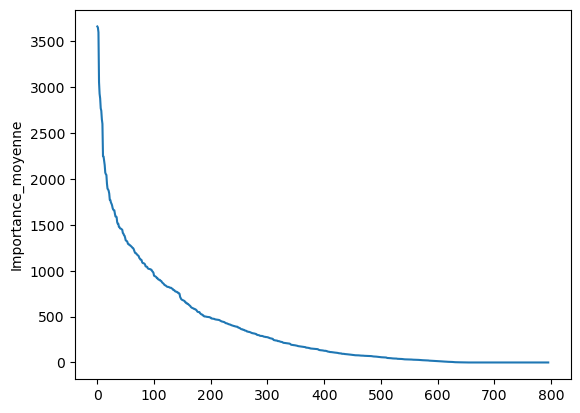

In [ ]:
sns.lineplot(x=range(temp.shape[0]),y=temp.sort_values(by='Importance_moyenne',ascending=False)['Importance_moyenne'])

In [ ]:
temp.sort_values(by='Importance_moyenne', ascending=False)[:50]

col_0,Importance_moyenne
feature,
EXT_SOURCE_3,3661.9
PAYMENT_RATE,3650.3
EXT_SOURCE_2,3598.5
DAYS_BIRTH,3055.2
EXT_SOURCE_1,2929.2
DAYS_EMPLOYED,2877.9
DAYS_EMPLOYED_PERC,2770.5
DAYS_REGISTRATION,2743.8
DAYS_ID_PUBLISH,2650.2


In [ ]:
feat_important=temp.sort_values(by='Importance_moyenne',ascending=False).index.values

In [ ]:
feat_important

array(['EXT_SOURCE_3', 'PAYMENT_RATE', 'EXT_SOURCE_2', 'DAYS_BIRTH',
       'EXT_SOURCE_1', 'DAYS_EMPLOYED', 'DAYS_EMPLOYED_PERC',
       'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'INDEX', 'INSTAL_DBD_MEAN',
       'ANNUITY_INCOME_PERC', 'AMT_ANNUITY', 'DAYS_LAST_PHONE_CHANGE',
       'ACTIVE_DAYS_CREDIT_UPDATE_MEAN', 'INSTAL_DAYS_ENTRY_PAYMENT_MAX',
       'REGION_POPULATION_RELATIVE', 'ACTIVE_DAYS_CREDIT_ENDDATE_MIN',
       'APPROVED_DAYS_DECISION_MAX', 'CLOSED_DAYS_CREDIT_MAX',
       'INSTAL_AMT_PAYMENT_MIN', 'INCOME_CREDIT_PERC',
       'CLOSED_DAYS_CREDIT_ENDDATE_MAX', 'BURO_DAYS_CREDIT_VAR',
       'INSTAL_DBD_SUM', 'INSTAL_DBD_MAX', 'PREV_APP_CREDIT_PERC_VAR',
       'ACTIVE_DAYS_CREDIT_MAX', 'APPROVED_APP_CREDIT_PERC_VAR',
       'AMT_CREDIT', 'PREV_DAYS_DECISION_MAX', 'AMT_GOODS_PRICE',
       'INCOME_PER_PERSON', 'CLOSED_AMT_CREDIT_SUM_MEAN',
       'CLOSED_DAYS_CREDIT_VAR', 'PREV_HOUR_APPR_PROCESS_START_MEAN',
       'ACTIVE_DAYS_CREDIT_ENDDATE_MEAN',
       'POS_NAME_CONTRA

In [ ]:
pd.Series(feat_important,dtype='str').to_csv('1_outputs/feat_important_sorted_decroissant.csv',index=False,header=False)


## def d'un lightgbm sur 100 à 200 var les plus importantes:

In [ ]:
var_lgbm_10=np.append(feat_important[:10],'TARGET')
var_lgbm_30=np.append(feat_important[:30],'TARGET')
var_lgbm_50=np.append(feat_important[:50],'TARGET')
var_lgbm_100=np.append(feat_important[:100],'TARGET')
var_lgbm_200=np.append(feat_important[:200],'TARGET')
var_lgbm_10

array(['EXT_SOURCE_3', 'PAYMENT_RATE', 'EXT_SOURCE_2', 'DAYS_BIRTH',
       'EXT_SOURCE_1', 'DAYS_EMPLOYED', 'DAYS_EMPLOYED_PERC',
       'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'INDEX', 'TARGET'],
      dtype=object)

In [ ]:
# redéfinition d'un jeu de test/training à l'intérieur du jeu de train initial pour évaluer les résultats

random.seed(8)  # seed fixée pour reproductibilité des résultats
# jeu d'apprentissage
train_df = df_total[df_total['TARGET'].notnull()]
test_df = df_total[df_total['TARGET'].isnull()]

Liste_train = list(random.sample(list(train_df.index), round(train_df.shape[0]*0.8)))
Liste_test = train_df.loc[train_df.index.isin(Liste_train)==False,:].index.values


In [ ]:
df_total[var_lgbm_10].head()

,EXT_SOURCE_3,PAYMENT_RATE,EXT_SOURCE_2,DAYS_BIRTH,EXT_SOURCE_1,DAYS_EMPLOYED,DAYS_EMPLOYED_PERC,DAYS_REGISTRATION,DAYS_ID_PUBLISH,INDEX,TARGET
ID,,,,,,,,,,,
100002,0.139376,0.060749,0.262949,-9461,0.083037,-637.0,0.067329,-3648.0,-2120,0,1.0
100003,NaN,0.027598,0.622246,-16765,0.311267,-1188.0,0.070862,-1186.0,-291,1,0.0
100004,0.729567,0.050000,0.555912,-19046,NaN,-225.0,0.011814,-4260.0,-2531,2,0.0
100006,NaN,0.094941,0.650442,-19005,NaN,-3039.0,0.159905,-9833.0,-2437,3,0.0
100007,NaN,0.042623,0.322738,-19932,NaN,-3038.0,0.152418,-4311.0,-3458,4,0.0


In [ ]:
# def main_eval_var(debug = False):
#     num_rows = 10000 if debug else None
#     df = application_train_test(num_rows)
#     with timer("Process bureau and bureau_balance"):
#         bureau = bureau_and_balance(num_rows)
#         print("Bureau df shape:", bureau.shape)
#         df = df.join(bureau, how='left', on='SK_ID_CURR')
#         del bureau
#         gc.collect()
#     with timer("Process previous_applications"):
#         prev = previous_applications(num_rows)
#         print("Previous applications df shape:", prev.shape)
#         df = df.join(prev, how='left', on='SK_ID_CURR')
#         del prev
#         gc.collect()
#     with timer("Process POS-CASH balance"):
#         pos = pos_cash(num_rows)
#         print("Pos-cash balance df shape:", pos.shape)
#         df = df.join(pos, how='left', on='SK_ID_CURR')
#         del pos
#         gc.collect()
#     with timer("Process installments payments"):
#         ins = installments_payments(num_rows)
#         print("Installments payments df shape:", ins.shape)
#         df = df.join(ins, how='left', on='SK_ID_CURR')
#         del ins
#         gc.collect()
#     with timer("Process credit card balance"):
#         cc = credit_card_balance(num_rows)
#         print("Credit card balance df shape:", cc.shape)
#         df = df.join(cc, how='left', on='SK_ID_CURR')
#         del cc
#         gc.collect()
    
# ## Modif "eval_var", on restreint le df
#     df=df[var_lgbm].copy()


#     with timer("Run LightGBM with kfold"):
#         feat_importance = kfold_lightgbm(df, num_folds= 2, stratified= False, debug= debug)

In [ ]:
# def kfold_lightgbm_var_import(df, num_folds, stratified = False, debug= False):
#     # Divide in training/validation and test data
#     df = df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
#     df = df.rename(columns = lambda x:x.upper())
    
#     for i in df.columns:
#         if df[i].dtypes=='object':
#             df[i]=df[i].astype('bool')
#     train_df = df[df['TARGET'].notnull()].loc[Liste_train]
#     test_df = df[df['TARGET'].notnull()].loc[Liste_test]
#     print("Starting LightGBM. Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))
    
#     # # Cross validation model
#     # if stratified:
#     #     folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=1001)
#     # else:
#     #     folds = KFold(n_splits= num_folds, shuffle=True, random_state=1001)
#     # Create arrays and dataframes to store results
#     global clf, oof_preds, sub_preds, feature_importance_df
#     oof_preds = np.zeros(train_df.shape[0])
#     sub_preds = np.zeros(test_df.shape[0])
#     feature_importance_df = pd.DataFrame()
#     feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
    
#     for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['TARGET'])):
#         train_x, train_y = train_df[feats].iloc[train_idx], train_df['TARGET'].iloc[train_idx]
#         valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['TARGET'].iloc[valid_idx]

#         # LightGBM parameters found by Bayesian optimization
        
#         clf = LGBMClassifier(
#             nthread=4,
#             n_estimators=10000,
#             learning_rate=0.02,
#             num_leaves=34,
#             colsample_bytree=0.9497036,
#             subsample=0.8715623,
#             max_depth=8,
#             reg_alpha=0.041545473,
#             reg_lambda=0.0735294,
#             min_split_gain=0.0222415,
#             min_child_weight=39.3259775,
#             silent=-1,
#             verbose=-1, )

#         clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], 
#             eval_metric= 'auc')

#         oof_preds[valid_idx] = clf.predict_proba(valid_x, num_iteration=clf.best_iteration_)[:, 1]
#         sub_preds += clf.predict_proba(test_df[feats], num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits

#         fold_importance_df = pd.DataFrame()
#         fold_importance_df["feature"] = feats
#         fold_importance_df["importance"] = clf.feature_importances_
#         fold_importance_df["fold"] = n_fold + 1

#         feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
#         print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx])))
#         del clf, train_x, train_y, valid_x, valid_y
#         gc.collect()

#     print('Full AUC score %.6f' % roc_auc_score(train_df['TARGET'], oof_preds))
#     # Write submission file and plot feature importance
    
#     display_importances(feature_importance_df)
#     return feature_importance_df

## Calculs avec changements du nbr de var retenues

 lgbm + _10 ,  _30,  _50 , _100 , _200 = nombre de variables classées selon l'importance retenues + comparaison aux stats "réelles" en conservant la totalité 

In [ ]:
# ## NBR VAR à changer manuellement ##
# df=df_total[var_lgbm_10]
# ## NBR VAR à changer manuellement ##

# train_df = df[df['TARGET'].notnull()].loc[Liste_train]
# test_df = df[df['TARGET'].notnull()].loc[Liste_test]

# feature_importance_df = pd.DataFrame()
# feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
# train_x, train_y = train_df[feats], train_df['TARGET']
# valid_x, valid_y = test_df[feats], test_df['TARGET']

# ## NBR VAR à changer manuellement ##
# train_x_10=train_x.copy()
# train_y_10=train_y.copy()
# valid_x_10=valid_x.copy()
# valid_y_10=valid_y.copy()
# ## NBR VAR à changer manuellement ##


# clf = LGBMClassifier(
#             nthread=4,
#             n_estimators=10000,
#             learning_rate=0.02,
#             num_leaves=34,
#             colsample_bytree=0.9497036,
#             subsample=0.8715623,
#             max_depth=8,
#             reg_alpha=0.041545473,
#             reg_lambda=0.0735294,
#             min_split_gain=0.0222415,
#             min_child_weight=39.3259775,
#             silent=-1,
#             verbose=-1, )


# clf_fit=clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], 
#             eval_metric= 'auc')

# # oof_preds[1] = clf.predict_proba(valid_x)[:, 1]
# # sub_preds += clf.predict_proba(test_df[feats])[:, 1]

# fold_importance_df = pd.DataFrame()
# fold_importance_df["feature"] = feats
# fold_importance_df["importance"] = clf.feature_importances_
# fold_importance_df["fold"] = 1

# feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

# ## NBR VAR à changer manuellement ##
# predict_train_10=pd.Series(clf_fit.predict(train_x),index=train_df.index, name ='predict_train')
# predict_valid_10=pd.Series(clf_fit.predict(valid_x),index=test_df.index, name ='predict_valid' )
# ## NBR VAR à changer manuellement ##


# # score ARI training
# print('score ARI training =',round(adjusted_rand_score(train_y,predict_train),3))
# # score ARI testing
# print('score ARI testing =',round(adjusted_rand_score(valid_y,predict_valid),3))
# # accuracy training
# print('accuracy training =',round(sklearn.metrics.accuracy_score(train_y, predict_train),3))
# # accuracy testing
# print('accuracy testing =',round(sklearn.metrics.accuracy_score(valid_y, predict_valid),3))
# # precision training
# print('precision training =',round(sklearn.metrics.average_precision_score(train_y, predict_train),3))
# # precision testing
# print('precision testing =',round(sklearn.metrics.average_precision_score(valid_y, predict_valid),3))


In [ ]:
# (pd.crosstab(valid_y,predict_valid,normalize='index')*100).round(3)

In [ ]:
# (pd.crosstab(train_y,predict_train,normalize='index')*100).round(3)

In [ ]:
# ## NBR VAR à changer manuellement ##
# df=df_total[var_lgbm_30]
# ## NBR VAR à changer manuellement ##

# train_df = df[df['TARGET'].notnull()].loc[Liste_train]
# test_df = df[df['TARGET'].notnull()].loc[Liste_test]

# feature_importance_df = pd.DataFrame()
# feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
# train_x, train_y = train_df[feats], train_df['TARGET']
# valid_x, valid_y = test_df[feats], test_df['TARGET']

# ## NBR VAR à changer manuellement ##
# train_x_30=train_x.copy()
# train_y_30=train_y.copy()
# valid_x_30=valid_x.copy()
# valid_y_30=valid_y.copy()
# ## NBR VAR à changer manuellement ##


# clf = LGBMClassifier(
#             nthread=4,
#             n_estimators=10000,
#             learning_rate=0.02,
#             num_leaves=34,
#             colsample_bytree=0.9497036,
#             subsample=0.8715623,
#             max_depth=8,
#             reg_alpha=0.041545473,
#             reg_lambda=0.0735294,
#             min_split_gain=0.0222415,
#             min_child_weight=39.3259775,
#             silent=-1,
#             verbose=-1, )


# clf_fit=clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], 
#             eval_metric= 'auc')

# # oof_preds[1] = clf.predict_proba(valid_x)[:, 1]
# # sub_preds += clf.predict_proba(test_df[feats])[:, 1]

# fold_importance_df = pd.DataFrame()
# fold_importance_df["feature"] = feats
# fold_importance_df["importance"] = clf.feature_importances_
# fold_importance_df["fold"] = 1

# feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

# ## NBR VAR à changer manuellement ##
# predict_train_30=pd.Series(clf_fit.predict(train_x),index=train_df.index, name ='predict_train')
# predict_valid_30=pd.Series(clf_fit.predict(valid_x),index=test_df.index, name ='predict_valid' )
# ## NBR VAR à changer manuellement ##


# # score ARI training
# print('score ARI training =',round(adjusted_rand_score(train_y,predict_train),3))
# # score ARI testing
# print('score ARI testing =',round(adjusted_rand_score(valid_y,predict_valid),3))
# # accuracy training
# print('accuracy training =',round(sklearn.metrics.accuracy_score(train_y, predict_train),3))
# # accuracy testing
# print('accuracy testing =',round(sklearn.metrics.accuracy_score(valid_y, predict_valid),3))
# # precision training
# print('precision training =',round(sklearn.metrics.average_precision_score(train_y, predict_train),3))
# # precision testing
# print('precision testing =',round(sklearn.metrics.average_precision_score(valid_y, predict_valid),3))


In [ ]:
# ## NBR VAR à changer manuellement ##
# df=df_total[var_lgbm_50]
# ## NBR VAR à changer manuellement ##

# train_df = df[df['TARGET'].notnull()].loc[Liste_train]
# test_df = df[df['TARGET'].notnull()].loc[Liste_test]

# feature_importance_df = pd.DataFrame()
# feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
# train_x, train_y = train_df[feats], train_df['TARGET']
# valid_x, valid_y = test_df[feats], test_df['TARGET']

# ## NBR VAR à changer manuellement ##
# train_x_50=train_x.copy()
# train_y_50=train_y.copy()
# valid_x_50=valid_x.copy()
# valid_y_50=valid_y.copy()
# ## NBR VAR à changer manuellement ##


# clf = LGBMClassifier(
#             nthread=4,
#             n_estimators=10000,
#             learning_rate=0.02,
#             num_leaves=34,
#             colsample_bytree=0.9497036,
#             subsample=0.8715623,
#             max_depth=8,
#             reg_alpha=0.041545473,
#             reg_lambda=0.0735294,
#             min_split_gain=0.0222415,
#             min_child_weight=39.3259775,
#             silent=-1,
#             verbose=-1, )


# clf_fit=clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], 
#             eval_metric= 'auc')

# # oof_preds[1] = clf.predict_proba(valid_x)[:, 1]
# # sub_preds += clf.predict_proba(test_df[feats])[:, 1]

# fold_importance_df = pd.DataFrame()
# fold_importance_df["feature"] = feats
# fold_importance_df["importance"] = clf.feature_importances_
# fold_importance_df["fold"] = 1

# feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

# ## NBR VAR à changer manuellement ##
# predict_train_50=pd.Series(clf_fit.predict(train_x),index=train_df.index, name ='predict_train')
# predict_valid_50=pd.Series(clf_fit.predict(valid_x),index=test_df.index, name ='predict_valid' )
# ## NBR VAR à changer manuellement ##


# # score ARI training
# print('score ARI training =',round(adjusted_rand_score(train_y,predict_train),3))
# # score ARI testing
# print('score ARI testing =',round(adjusted_rand_score(valid_y,predict_valid),3))
# # accuracy training
# print('accuracy training =',round(sklearn.metrics.accuracy_score(train_y, predict_train),3))
# # accuracy testing
# print('accuracy testing =',round(sklearn.metrics.accuracy_score(valid_y, predict_valid),3))
# # precision training
# print('precision training =',round(sklearn.metrics.average_precision_score(train_y, predict_train),3))
# # precision testing
# print('precision testing =',round(sklearn.metrics.average_precision_score(valid_y, predict_valid),3))

In [ ]:
# ## NBR VAR à changer manuellement ##
# df=df_total[var_lgbm_100]
# ## NBR VAR à changer manuellement ##

# train_df = df[df['TARGET'].notnull()].loc[Liste_train]
# test_df = df[df['TARGET'].notnull()].loc[Liste_test]

# feature_importance_df = pd.DataFrame()
# feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
# train_x, train_y = train_df[feats], train_df['TARGET']
# valid_x, valid_y = test_df[feats], test_df['TARGET']

# ## NBR VAR à changer manuellement ##
# train_x_100=train_x.copy()
# train_y_100=train_y.copy()
# valid_x_100=valid_x.copy()
# valid_y_100=valid_y.copy()
# ## NBR VAR à changer manuellement ##


# clf = LGBMClassifier(
#             nthread=4,
#             n_estimators=10000,
#             learning_rate=0.02,
#             num_leaves=34,
#             colsample_bytree=0.9497036,
#             subsample=0.8715623,
#             max_depth=8,
#             reg_alpha=0.041545473,
#             reg_lambda=0.0735294,
#             min_split_gain=0.0222415,
#             min_child_weight=39.3259775,
#             silent=-1,
#             verbose=-1, )


# clf_fit=clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], 
#             eval_metric= 'auc')

# # oof_preds[1] = clf.predict_proba(valid_x)[:, 1]
# # sub_preds += clf.predict_proba(test_df[feats])[:, 1]

# fold_importance_df = pd.DataFrame()
# fold_importance_df["feature"] = feats
# fold_importance_df["importance"] = clf.feature_importances_
# fold_importance_df["fold"] = 1

# feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

# predict_train=pd.Series(clf_fit.predict(train_x),index=train_df.index, name ='predict_train')
# predict_valid=pd.Series(clf_fit.predict(valid_x),index=test_df.index, name ='predict_valid' )

# ## NBR VAR à changer manuellement ##
# predict_train_100=predict_train.copy()
# predict_valid_100=predict_valid.copy()
# ## NBR VAR à changer manuellement ##

# # score ARI training
# print('score ARI training =',round(adjusted_rand_score(train_y_100,predict_train),3))
# # score ARI testing
# print('score ARI testing =',round(adjusted_rand_score(valid_y,predict_valid),3))
# # accuracy training
# print('accuracy training =',round(sklearn.metrics.accuracy_score(train_y, predict_train),3))
# # accuracy testing
# print('accuracy testing =',round(sklearn.metrics.accuracy_score(valid_y, predict_valid),3))
# # precision training
# print('precision training =',round(sklearn.metrics.average_precision_score(train_y, predict_train),3))
# # precision testing
# print('precision testing =',round(sklearn.metrics.average_precision_score(valid_y, predict_valid),3))

In [ ]:
# ## NBR VAR à changer manuellement ##
# df=df_total[var_lgbm_200]
# ## NBR VAR à changer manuellement ##

# train_df = df[df['TARGET'].notnull()].loc[Liste_train]
# test_df = df[df['TARGET'].notnull()].loc[Liste_test]

# feature_importance_df = pd.DataFrame()
# feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
# train_x, train_y = train_df[feats], train_df['TARGET']
# valid_x, valid_y = test_df[feats], test_df['TARGET']

# ## NBR VAR à changer manuellement ##
# train_x_200=train_x.copy()
# train_y_200=train_y.copy()
# valid_x_200=valid_x.copy()
# valid_y_200=valid_y.copy()
# ## NBR VAR à changer manuellement ##


# clf = LGBMClassifier(
#             nthread=4,
#             n_estimators=10000,
#             learning_rate=0.02,
#             num_leaves=34,
#             colsample_bytree=0.9497036,
#             subsample=0.8715623,
#             max_depth=8,
#             reg_alpha=0.041545473,
#             reg_lambda=0.0735294,
#             min_split_gain=0.0222415,
#             min_child_weight=39.3259775,
#             silent=-1,
#             verbose=-1, )


# clf_fit=clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], 
#             eval_metric= 'auc')

# # oof_preds[1] = clf.predict_proba(valid_x)[:, 1]
# # sub_preds += clf.predict_proba(test_df[feats])[:, 1]

# fold_importance_df = pd.DataFrame()
# fold_importance_df["feature"] = feats
# fold_importance_df["importance"] = clf.feature_importances_
# fold_importance_df["fold"] = 1

# feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

# predict_train=pd.Series(clf_fit.predict(train_x),index=train_df.index, name ='predict_train')
# predict_valid=pd.Series(clf_fit.predict(valid_x),index=test_df.index, name ='predict_valid' )

# ## NBR VAR à changer manuellement ##
# predict_train_200=predict_train.copy()
# predict_valid_200=predict_valid.copy()
# ## NBR VAR à changer manuellement ##

# # score ARI training
# print('score ARI training =',round(adjusted_rand_score(train_y,predict_train),3))
# # score ARI testing
# print('score ARI testing =',round(adjusted_rand_score(valid_y,predict_valid),3))
# # accuracy training
# print('accuracy training =',round(sklearn.metrics.accuracy_score(train_y, predict_train),3))
# # accuracy testing
# print('accuracy testing =',round(sklearn.metrics.accuracy_score(valid_y, predict_valid),3))
# # precision training
# print('precision training =',round(sklearn.metrics.average_precision_score(train_y, predict_train),3))
# # precision testing
# print('precision testing =',round(sklearn.metrics.average_precision_score(valid_y, predict_valid),3))

In [ ]:
# ## NBR VAR à changer manuellement ##
# df=df_total
# ## NBR VAR à changer manuellement ##

# train_df = df[df['TARGET'].notnull()].loc[Liste_train]
# test_df = df[df['TARGET'].notnull()].loc[Liste_test]

# feature_importance_df = pd.DataFrame()
# feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
# train_x, train_y = train_df[feats], train_df['TARGET']
# valid_x, valid_y = test_df[feats], test_df['TARGET']

# ## NBR VAR à changer manuellement ##
# train_x_tot=train_x.copy()
# train_y_tot=train_y.copy()
# valid_x_tot=valid_x.copy()
# valid_y_tot=valid_y.copy()
# ## NBR VAR à changer manuellement ##


# clf = LGBMClassifier(
#             nthread=4,
#             n_estimators=10000,
#             learning_rate=0.02,
#             num_leaves=34,
#             colsample_bytree=0.9497036,
#             subsample=0.8715623,
#             max_depth=8,
#             reg_alpha=0.041545473,
#             reg_lambda=0.0735294,
#             min_split_gain=0.0222415,
#             min_child_weight=39.3259775,
#             silent=-1,
#             verbose=-1, )


# clf_fit=clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], 
#             eval_metric= 'auc')

# # oof_preds[1] = clf.predict_proba(valid_x)[:, 1]
# # sub_preds += clf.predict_proba(test_df[feats])[:, 1]

# fold_importance_df = pd.DataFrame()
# fold_importance_df["feature"] = feats
# fold_importance_df["importance"] = clf.feature_importances_
# fold_importance_df["fold"] = 1

# feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

# predict_train=pd.Series(clf_fit.predict(train_x),index=train_df.index, name ='predict_train')
# predict_valid=pd.Series(clf_fit.predict(valid_x),index=test_df.index, name ='predict_valid' )

# ## NBR VAR à changer manuellement ##
# predict_train_tot=predict_train.copy()
# predict_valid_tot=predict_valid.copy()
# ## NBR VAR à changer manuellement ##


# # score ARI training
# print('score ARI training =',round(adjusted_rand_score(train_y,predict_train),3))
# # score ARI testing
# print('score ARI testing =',round(adjusted_rand_score(valid_y,predict_valid),3))
# # accuracy training
# print('accuracy training =',round(sklearn.metrics.accuracy_score(train_y, predict_train),3))
# # accuracy testing
# print('accuracy testing =',round(sklearn.metrics.accuracy_score(valid_y, predict_valid),3))
# # precision training
# print('precision training =',round(sklearn.metrics.average_precision_score(train_y, predict_train),3))
# # precision testing
# print('precision testing =',round(sklearn.metrics.average_precision_score(valid_y, predict_valid),3))

In [ ]:
# (pd.crosstab(train_y_tot,predict_train_tot,normalize='index')*100).round(3)

In [ ]:
# (pd.crosstab(train_y_200,predict_train_200,normalize='index')*100).round(3)

In [ ]:
# (pd.crosstab(train_y_100,predict_train_100,normalize='index')*100).round(3)

In [ ]:
# (pd.crosstab(train_y_50,predict_train_50,normalize='index')*100).round(3)

In [ ]:
# (pd.crosstab(train_y_30,predict_train_30,normalize='index')*100).round(3)

In [ ]:
# (pd.crosstab(valid_y_tot,predict_valid_tot,normalize='index')*100).round(3)

In [ ]:
# (pd.crosstab(valid_y_200,predict_valid_200,normalize='index')*100).round(3)

In [ ]:
# (pd.crosstab(valid_y_100,predict_valid_100,normalize='index')*100).round(3)

In [ ]:
# (pd.crosstab(valid_y_50,predict_valid_50,normalize='index')*100).round(3)

In [ ]:
# (pd.crosstab(valid_y_30,predict_valid_30,normalize='index')*100).round(3)

In [ ]:
# lgbm_valid_y=pd.concat([valid_y_30,predict_valid_30,predict_valid_50,predict_valid_100,predict_valid_200,predict_valid_tot],axis=1)
# lgbm_valid_y.columns=['TARGET',30,50,100,200,'tot']
# lgbm_train_y=pd.concat([train_y_30,predict_train_30,predict_train_50,predict_train_100,predict_train_200,predict_train_tot],axis=1)
# lgbm_train_y.columns=['TARGET',30,50,100,200,'tot']
# lgbm_result_tot=pd.concat([lgbm_train_y,lgbm_valid_y],axis=0)


In [ ]:
# lgbm_result_tot

### sauvegarge des résultats du lgbm avec nbr de var distinctes

In [ ]:
# lgbm_result_tot.to_csv('1_outputs/Result_lgbm_nbr_var.csv')

In [ ]:
# pd.crosstab(lgbm_valid_y['TARGET'],lgbm_valid_y[30])

In [ ]:
# pd.crosstab(lgbm_train_y['TARGET'],lgbm_train_y[30])

In [ ]:
# print('','precision testing_tot =',round(sklearn.metrics.average_precision_score(valid_y, predict_valid_tot),4),'\n',
#     'precision testing_200 =',round(sklearn.metrics.average_precision_score(valid_y, predict_valid_200),4),'\n',
#     'precision testing_100 =',round(sklearn.metrics.average_precision_score(valid_y, predict_valid_100),4),'\n',
#     'precision testing_50 =',round(sklearn.metrics.average_precision_score(valid_y, predict_valid_50),4),'\n',
#     'precision testing_30 =',round(sklearn.metrics.average_precision_score(valid_y, predict_valid_30),4)
    # )

In [ ]:
# print('','precision testing_tot =',round(sklearn.metrics.accuracy_score(valid_y, predict_valid_tot),4),'\n',
#     'precision testing_200 =',round(sklearn.metrics.accuracy_score(valid_y, predict_valid_200),4),'\n',
#     'precision testing_100 =',round(sklearn.metrics.accuracy_score(valid_y, predict_valid_100),4),'\n',
#     'precision testing_50 =',round(sklearn.metrics.accuracy_score(valid_y, predict_valid_50),4),'\n',
#     'precision testing_30 =',round(sklearn.metrics.accuracy_score(valid_y, predict_valid_30),4)
#     )

Garder uniquement 100 variables "maximise" la précision sur les différents essais avec moins de variables =>  on simplifie  pour les modèles de scoring en réduisant les temps de calcul. On peut aussi considérer que d'une point de vue explication du résultat du score et gestion des informations, un modèle efficace avec moin s de variables requises serait un plus

In [ ]:
# recharge des résultats obtenus pour les executions du code sans recalcul des lgbm sur différents nbr de variables
lgbm_result_tot=pd.read_csv('1_outputs/Result_lgbm_nbr_var.csv')

# Modèles de classification sur les bases des 100 var les plus importantes

In [ ]:
data=df_total[var_lgbm_100].copy()

### exploration

In [ ]:
df_total[var_lgbm_100].head()

,EXT_SOURCE_3,PAYMENT_RATE,EXT_SOURCE_2,DAYS_BIRTH,EXT_SOURCE_1,DAYS_EMPLOYED,DAYS_EMPLOYED_PERC,DAYS_REGISTRATION,DAYS_ID_PUBLISH,INDEX,...,HOUR_APPR_PROCESS_START,PREV_AMT_CREDIT_MEAN,APPROVED_APP_CREDIT_PERC_MIN,CLOSED_DAYS_CREDIT_ENDDATE_MIN,PREV_NAME_TYPE_SUITE_NAN_MEAN,PREV_RATE_DOWN_PAYMENT_MEAN,INSTAL_PAYMENT_PERC_VAR,TOTALAREA_MODE,INSTAL_AMT_INSTALMENT_SUM,TARGET
ID,,,,,,,,,,,,,,,,,,,,,
100002,0.139376,0.060749,0.262949,-9461,0.083037,-637.0,0.067329,-3648.0,-2120,0,...,10,179055.00,1.000000,-1072.0,1.000000,0.000000,0.000000,0.0149,219625.695,1.0
100003,NaN,0.027598,0.622246,-16765,0.311267,-1188.0,0.070862,-1186.0,-291,1,...,11,484191.00,0.868825,-2434.0,0.000000,0.050030,0.000000,0.0714,1618864.650,0.0
100004,0.729567,0.050000,0.555912,-19046,NaN,-225.0,0.011814,-4260.0,-2531,2,...,9,20106.00,1.207699,-595.0,0.000000,0.212008,0.000000,NaN,21288.465,0.0
100006,NaN,0.094941,0.650442,-19005,NaN,-3039.0,0.159905,-9833.0,-2437,3,...,17,291695.50,0.943934,NaN,0.555556,0.163412,0.000000,NaN,1007153.415,0.0
100007,NaN,0.042623,0.322738,-19932,NaN,-3038.0,0.152418,-4311.0,-3458,4,...,11,166638.75,0.791139,-783.0,0.333333,0.159516,0.043995,NaN,835985.340,0.0


In [ ]:
ctrl_data=Controle(df_total[var_lgbm_100])

In [ ]:
ctrl_data

,nomcol,type,unique,unique%,doubl%,manqu,manqu%,rempli,rempli%,skew,mean,min,25%,50%,75%,max
0,EXT_SOURCE_3,float64,815,0.284,99.716,69633,19.546,286618,80.454,-0.398639,0.51,0.00,0.37,0.53,0.67,0.90
1,PAYMENT_RATE,float64,43679,12.262,87.738,36,0.01,356215,99.99,1.018151,0.06,0.02,0.04,0.05,0.07,0.12
2,EXT_SOURCE_2,float64,127157,35.76,64.24,668,0.188,355583,99.812,-0.793073,0.51,0.00,0.39,0.56,0.66,0.85
3,DAYS_BIRTH,int64,17467,4.903,95.097,0,0.0,356251,100.0,-0.115913,"-16,041.28","-25,229.00","-19,676.00","-15,755.00","-12,425.00","-7,338.00"
4,EXT_SOURCE_1,float64,134316,82.736,17.264,193908,54.43,162343,45.57,-0.077239,0.50,0.01,0.34,0.51,0.67,0.96
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,PREV_RATE_DOWN_PAYMENT_MEAN,float64,190452,59.75,40.25,37502,10.527,318749,89.473,2.048639,0.08,-0.00,0.00,0.07,0.11,0.99
97,INSTAL_PAYMENT_PERC_VAR,float64,167888,49.585,50.415,17664,4.958,338587,95.042,246.254881,"18,590.72",0.00,0.00,0.00,0.08,"967,504,461.56"
98,TOTALAREA_MODE,float64,5192,2.804,97.196,171054,48.015,185197,51.985,2.796591,0.10,0.00,0.04,0.07,0.13,1.00
99,INSTAL_AMT_INSTALMENT_SUM,float64,335337,98.75,1.25,16668,4.679,339583,95.321,2.92132,"683,130.54",0.00,"136,679.38","334,393.20","857,772.74","32,479,781.27"


In [ ]:
ctrl_data[ctrl_data['nomcol'].str.contains('_VAR')]

,nomcol,type,unique,unique%,doubl%,manqu,manqu%,rempli,rempli%,skew,mean,min,25%,50%,75%,max
23,BURO_DAYS_CREDIT_VAR,float64,220615,83.476,16.524,91964,25.814,264287,74.186,1.842613,"485,602.51",0.00,"125,714.33","380,396.86","713,087.12","4,173,160.50"
26,PREV_APP_CREDIT_PERC_VAR,float64,248220,92.683,7.317,88434,24.824,267817,75.176,71.684282,0.07,0.00,0.00,0.01,0.05,63.70
28,APPROVED_APP_CREDIT_PERC_VAR,float64,229512,92.135,7.865,107148,30.077,249103,69.923,102.7186,0.08,0.00,0.00,0.01,0.05,95.19
34,CLOSED_DAYS_CREDIT_VAR,float64,154323,74.832,25.168,150025,42.112,206226,57.888,1.976942,"428,717.94",0.00,"99,503.56","319,626.77","620,385.47","4,032,800.00"
41,ACTIVE_DAYS_CREDIT_VAR,float64,94038,56.539,43.461,189928,53.313,166323,46.687,3.141623,"302,053.09",0.00,"21,955.85","108,389.33","342,899.43","4,193,408.00"
97,INSTAL_PAYMENT_PERC_VAR,float64,167888,49.585,50.415,17664,4.958,338587,95.042,246.254881,"18,590.72",0.00,0.00,0.00,0.08,"967,504,461.56"


In [ ]:
ctrl_data.loc[abs(ctrl_data['skew'])>8,:]


,nomcol,type,unique,unique%,doubl%,manqu,manqu%,rempli,rempli%,skew,mean,min,25%,50%,75%,max
14,ACTIVE_DAYS_CREDIT_UPDATE_MEAN,float64,13635,5.415,94.585,104440,29.316,251811,70.684,-31.061475,-129.28,"-41,919.00",-107.00,-30.00,-16.50,372.00
20,INSTAL_AMT_PAYMENT_MIN,float64,149981,44.167,55.833,16677,4.681,339574,95.319,54.281305,"5,282.78",0.00,41.53,"2,323.57","7,158.80","2,504,589.66"
21,INCOME_CREDIT_PERC,float64,54911,15.414,84.586,0,0.0,356251,100.0,207.20365,0.41,0.01,0.20,0.32,0.50,208.00
25,INSTAL_DBD_MAX,float64,439,0.129,99.871,16668,4.679,339583,95.321,9.496222,37.94,0.00,23.00,31.00,43.00,"3,189.00"
26,PREV_APP_CREDIT_PERC_VAR,float64,248220,92.683,7.317,88434,24.824,267817,75.176,71.684282,0.07,0.00,0.00,0.01,0.05,63.70
28,APPROVED_APP_CREDIT_PERC_VAR,float64,229512,92.135,7.865,107148,30.077,249103,69.923,102.7186,0.08,0.00,0.00,0.01,0.05,95.19
32,INCOME_PER_PERSON,float64,3302,0.927,99.073,2,0.001,356249,99.999,178.891481,"93,786.47","2,812.50","49,500.00","75,000.00","112,500.00","39,000,000.00"
33,CLOSED_AMT_CREDIT_SUM_MEAN,float64,197153,73.586,26.414,88330,24.794,267921,75.206,98.168297,"259,089.26",0.00,"69,130.12","126,188.91","255,786.07","198,072,344.25"
40,BURO_AMT_CREDIT_SUM_MEAN,float64,241358,78.925,21.075,50446,14.16,305805,85.84,63.087543,"380,740.91",0.00,"103,961.59","197,292.88","397,864.65","198,072,344.25"
43,BURO_AMT_CREDIT_MAX_OVERDUE_MEAN,float64,62611,29.399,70.601,143284,40.22,212967,59.78,339.207653,"5,004.96",0.00,0.00,0.00,"2,063.72","115,987,185.00"


In [ ]:
skew_a_corriger=ctrl_data.loc[abs(ctrl_data['skew'])>8,'nomcol']
skew_a_corriger

14      ACTIVE_DAYS_CREDIT_UPDATE_MEAN
20              INSTAL_AMT_PAYMENT_MIN
21                  INCOME_CREDIT_PERC
25                      INSTAL_DBD_MAX
26            PREV_APP_CREDIT_PERC_VAR
28        APPROVED_APP_CREDIT_PERC_VAR
32                   INCOME_PER_PERSON
33          CLOSED_AMT_CREDIT_SUM_MEAN
40            BURO_AMT_CREDIT_SUM_MEAN
43    BURO_AMT_CREDIT_MAX_OVERDUE_MEAN
47     ACTIVE_AMT_CREDIT_SUM_DEBT_MEAN
50           CLOSED_AMT_CREDIT_SUM_SUM
52          ACTIVE_AMT_CREDIT_SUM_MEAN
53           ACTIVE_AMT_CREDIT_SUM_SUM
54             BURO_AMT_CREDIT_SUM_SUM
58                     INSTAL_DPD_MEAN
60             INSTAL_AMT_PAYMENT_MEAN
63       BURO_AMT_CREDIT_SUM_DEBT_MEAN
68                    AMT_INCOME_TOTAL
71           CLOSED_AMT_CREDIT_SUM_MAX
73             BURO_AMT_CREDIT_SUM_MAX
74          INSTAL_AMT_INSTALMENT_MEAN
83           ACTIVE_AMT_CREDIT_SUM_MAX
97             INSTAL_PAYMENT_PERC_VAR
Name: nomcol, dtype: object

In [ ]:
ctrl_data.loc[ctrl_data['nomcol']=='ACTIVE_DAYS_CREDIT_UPDATE_MEAN','min']

14    -41,919.00
Name: min, dtype: object

In [ ]:
data2=data.copy()
# data[skew_a_corriger].apply(lambda x: x+min(x,0),axis=1)
for i in skew_a_corriger:
    data2[i]=np.log(data[i]-min(data[i].min(),0)+2)

In [ ]:
ctrl_data2=Controle(data2)

In [ ]:
ctrl_data2.loc[ctrl_data2['nomcol'].isin(skew_a_corriger),:]


,nomcol,type,unique,unique%,doubl%,manqu,manqu%,rempli,rempli%,skew,mean,min,25%,50%,75%,max
14,ACTIVE_DAYS_CREDIT_UPDATE_MEAN,float64,13635,5.415,94.585,104440,29.316,251811,70.684,-338.015547,10.64,0.69,10.64,10.64,10.64,10.65
20,INSTAL_AMT_PAYMENT_MIN,float64,149981,44.167,55.833,16677,4.681,339574,95.319,-0.501668,6.39,0.69,3.77,7.75,8.88,14.73
21,INCOME_CREDIT_PERC,float64,54911,15.414,84.586,0,0.0,356251,100.0,2.366921,0.87,0.70,0.79,0.84,0.92,5.35
25,INSTAL_DBD_MAX,float64,439,0.129,99.871,16668,4.679,339583,95.321,-0.179937,3.52,0.69,3.22,3.50,3.81,8.07
26,PREV_APP_CREDIT_PERC_VAR,float64,246339,91.98,8.02,88434,24.824,267817,75.176,10.453255,0.72,0.69,0.69,0.70,0.72,4.19
28,APPROVED_APP_CREDIT_PERC_VAR,float64,227884,91.482,8.518,107148,30.077,249103,69.923,10.940504,0.73,0.69,0.69,0.70,0.72,4.58
32,INCOME_PER_PERSON,float64,3302,0.927,99.073,2,0.001,356249,99.999,0.099925,11.24,7.94,10.81,11.23,11.63,17.48
33,CLOSED_AMT_CREDIT_SUM_MEAN,float64,197082,73.56,26.44,88330,24.794,267921,75.206,-3.547383,11.75,0.69,11.14,11.75,12.45,19.10
40,BURO_AMT_CREDIT_SUM_MEAN,float64,241315,78.911,21.089,50446,14.16,305805,85.84,-2.8942,12.20,0.69,11.55,12.19,12.89,19.10
43,BURO_AMT_CREDIT_MAX_OVERDUE_MEAN,float64,62486,29.341,70.659,143284,40.22,212967,59.78,0.709649,3.42,0.69,0.69,0.69,7.63,18.57


In [ ]:
temp=data['INSTAL_PAYMENT_PERC_VAR'].value_counts()
temp

INSTAL_PAYMENT_PERC_VAR
0.000000    170359
0.009434         8
0.009901         6
0.010309         5
0.009804         5
             ...  
0.643045         1
0.492694         1
0.087945         1
0.008130         1
0.017422         1
Name: count, Length: 167887, dtype: int64

In [ ]:
data['INSTAL_PAYMENT_PERC_VAR'].sort_values(ascending=False)[0:50]

ID
208684    9.675045e+08
311914    9.351725e+08
206110    7.785942e+08
136817    4.848088e+08
189057    4.164152e+08
132627    3.643064e+08
139940    3.255337e+08
163641    2.426683e+08
204147    2.296625e+08
175400    1.866694e+08
329493    1.007722e+08
296996    8.256705e+07
268629    8.095887e+07
395939    6.283097e+07
400671    6.195242e+07
232948    5.925106e+07
181216    5.822428e+07
124899    5.019536e+07
175562    4.988610e+07
432020    4.511626e+07
311138    4.338637e+07
301607    4.227644e+07
433126    4.142767e+07
199269    3.824991e+07
198592    3.340301e+07
126874    3.231260e+07
121517    1.876173e+07
263592    1.792150e+07
292679    1.769815e+07
272229    1.709227e+07
249800    1.653960e+07
448898    1.472007e+07
284649    1.341897e+07
392831    1.322674e+07
136106    1.282443e+07
131504    1.239933e+07
309032    1.135978e+07
201041    1.098342e+07
341328    1.064546e+07
212407    9.875416e+06
157659    9.673874e+06
191569    9.119648e+06
194631    8.922768e+06
335766  

In [ ]:
# version simplifiée du df de contrôle: donnée de type, Skew de la série et valeurs du describe + quntile à 99%
def Skew_df(x):
    # DataFrame de contrôles sur les colonnes
    tempo = pd.DataFrame(columns=['type','skew'])

    tot = x.shape[0]

    tempo['nomcol'] = pd.Series(x.columns) # nom des colonnes

    for i in x.columns:
        j=list(x.columns).index(i)
        tempo.at[j, 'type'] = x.dtypes[i]
        tempo.at[j, '99%'] = np.percentile(x.loc[x[i].isna()==False,i],99)  # retirer les Nan pour calcul du percentile
       
    
    temp=x.describe().T.copy()                  # describe des données numériques (min, max...)
    temp.drop(['count','std'],axis=1,inplace=True)                         # nombre et ecart-type pas ntéressants donc droppés
    tempo=tempo.merge(temp,how='left',left_on='nomcol',right_index=True)        # ajout des données numériques aux données de remplissage
        
        
    for i in tempo.loc[(tempo['type']!='category') & (tempo['type']!='object')]['nomcol']:                            #skew des données numériques
        tempo.at[tempo.loc[tempo['nomcol']==i].index.values[0],'skew']=x[i].skew()
    return tempo

In [ ]:
ctrl_data2=Skew_df(data2)

In [ ]:
ctrl_data2

,type,skew,nomcol,99%,mean,min,25%,50%,75%,max
0,float64,-0.398639,EXT_SOURCE_3,8.327850e-01,0.509353,5.272652e-04,0.368969,0.533482,0.665855,8.960095e-01
1,float64,1.018151,PAYMENT_RATE,1.188974e-01,0.055463,2.207258e-02,0.038080,0.050000,0.067066,1.244296e-01
2,float64,-0.793073,EXT_SOURCE_2,7.830834e-01,0.514889,8.173617e-08,0.394955,0.564838,0.662928,8.549997e-01
3,int64,-0.115913,DAYS_BIRTH,-8.274000e+03,-16041.276687,-2.522900e+04,-19676.000000,-15755.000000,-12425.000000,-7.338000e+03
4,float64,-0.077239,EXT_SOURCE_1,8.881479e-01,0.501964,1.345791e-02,0.335501,0.506155,0.673344,9.626928e-01
...,...,...,...,...,...,...,...,...,...,...
96,float64,2.048639,PREV_RATE_DOWN_PAYMENT_MEAN,4.230712e-01,0.081418,-7.489382e-06,0.000000,0.065158,0.108913,9.897399e-01
97,float64,13.541318,INSTAL_PAYMENT_PERC_VAR,2.808096e+00,0.811997,6.931472e-01,0.693147,0.693147,0.734613,2.069023e+01
98,float64,2.796591,TOTALAREA_MODE,5.284000e-01,0.103194,0.000000e+00,0.041500,0.069000,0.128700,1.000000e+00
99,float64,2.92132,INSTAL_AMT_INSTALMENT_SUM,4.211546e+06,683130.538319,0.000000e+00,136679.377500,334393.200000,857772.742500,3.247978e+07


In [ ]:
ctrl_data2.loc[ctrl_data2['nomcol']=='INSTAL_PAYMENT_PERC_VAR','99%'].values[0]

2.808095655368972

In [ ]:
data2.loc[data2['INSTAL_PAYMENT_PERC_VAR']<ctrl_data2.loc[ctrl_data2['nomcol']=='INSTAL_PAYMENT_PERC_VAR','99%'].values[0],'INSTAL_PAYMENT_PERC_VAR']

ID
100002    0.693147
100003    0.693147
100004    0.693147
100006    0.693147
100007    0.714906
            ...   
456221    0.693147
456222    0.709869
456223    0.693147
456224    0.693147
456250    0.701821
Name: INSTAL_PAYMENT_PERC_VAR, Length: 335201, dtype: float64

(0.0, 5000.0)

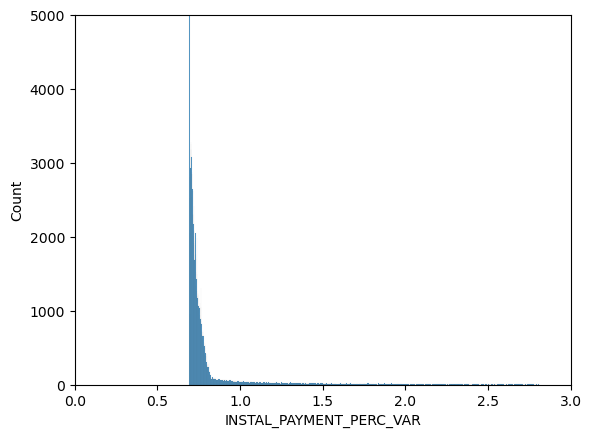

In [ ]:
sns.histplot(data2.loc[data2['INSTAL_PAYMENT_PERC_VAR']<ctrl_data2.loc[ctrl_data2['nomcol']=='INSTAL_PAYMENT_PERC_VAR','99%'].values[0],'INSTAL_PAYMENT_PERC_VAR'])
plt.xlim(0,3)
plt.ylim(0,5000)

### opérations finales de feature engineering

In [ ]:
data.head()

,EXT_SOURCE_3,PAYMENT_RATE,EXT_SOURCE_2,DAYS_BIRTH,EXT_SOURCE_1,DAYS_EMPLOYED,DAYS_EMPLOYED_PERC,DAYS_REGISTRATION,DAYS_ID_PUBLISH,INDEX,...,HOUR_APPR_PROCESS_START,PREV_AMT_CREDIT_MEAN,APPROVED_APP_CREDIT_PERC_MIN,CLOSED_DAYS_CREDIT_ENDDATE_MIN,PREV_NAME_TYPE_SUITE_NAN_MEAN,PREV_RATE_DOWN_PAYMENT_MEAN,INSTAL_PAYMENT_PERC_VAR,TOTALAREA_MODE,INSTAL_AMT_INSTALMENT_SUM,TARGET
ID,,,,,,,,,,,,,,,,,,,,,
100002,0.139376,0.060749,0.262949,-9461,0.083037,-637.0,0.067329,-3648.0,-2120,0,...,10,179055.00,1.000000,-1072.0,1.000000,0.000000,0.000000,0.0149,219625.695,1.0
100003,NaN,0.027598,0.622246,-16765,0.311267,-1188.0,0.070862,-1186.0,-291,1,...,11,484191.00,0.868825,-2434.0,0.000000,0.050030,0.000000,0.0714,1618864.650,0.0
100004,0.729567,0.050000,0.555912,-19046,NaN,-225.0,0.011814,-4260.0,-2531,2,...,9,20106.00,1.207699,-595.0,0.000000,0.212008,0.000000,NaN,21288.465,0.0
100006,NaN,0.094941,0.650442,-19005,NaN,-3039.0,0.159905,-9833.0,-2437,3,...,17,291695.50,0.943934,NaN,0.555556,0.163412,0.000000,NaN,1007153.415,0.0
100007,NaN,0.042623,0.322738,-19932,NaN,-3038.0,0.152418,-4311.0,-3458,4,...,11,166638.75,0.791139,-783.0,0.333333,0.159516,0.043995,NaN,835985.340,0.0


In [ ]:
data2=data.copy()

In [ ]:
#data2: remplacement des valeurs inf par des Nan (si jamais les colonnes de variables conservées inculent des valeurs inf)
for col in data.loc[:,data.max(axis=0)==np.inf].columns:
    data2[col] = data[col].replace([np.inf, -np.inf], np.nan)


In [ ]:
data3=data2.copy()

In [ ]:
#data3: cap max à quant75%+10* ecart interquartile(75-25)
def clip_quart(col):
    return col.clip(upper=np.percentile(col.loc[col.isna()==False],75)+
                    10*(np.percentile(col.loc[col.isna()==False],75)-np.percentile(col.loc[col.isna()==False],25)),
                    lower=np.percentile(col.loc[col.isna()==False],25)-
                    10*(np.percentile(col.loc[col.isna()==False],75)-np.percentile(col.loc[col.isna()==False],25)))


data3=data2.apply(clip_quart,axis=0)


In [ ]:
ctrl_data2=Skew_df(data2)
ctrl_data3=Skew_df(data3)

In [ ]:
ctrl_data2.sort_values(by='skew')

,type,skew,nomcol,99%,mean,min,25%,50%,75%,max
14,float64,-31.061475,ACTIVE_DAYS_CREDIT_UPDATE_MEAN,-3.000000,-129.283396,-41919.000000,-107.000,-30.000000,-16.500000,3.720000e+02
42,float64,-7.954776,CLOSED_DAYS_CREDIT_UPDATE_MEAN,-27.500000,-819.258175,-41890.000000,-1076.250,-758.000000,-473.666667,0.000000e+00
49,float64,-4.953651,BURO_DAYS_CREDIT_UPDATE_MEAN,-7.000000,-542.967626,-41890.000000,-773.700,-479.300000,-209.000000,1.400000e+01
37,float64,-3.13175,POS_NAME_CONTRACT_STATUS_ACTIVE_MEAN,1.000000,0.903948,0.000000,0.875,0.916667,0.945946,1.000000e+00
27,float64,-2.505615,ACTIVE_DAYS_CREDIT_MAX,-13.000000,-419.583279,-2922.000000,-520.000,-264.000000,-130.000000,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...
32,float64,178.891481,INCOME_PER_PERSON,346500.000000,93786.474641,2812.500000,49500.000,75000.000000,112500.000000,3.900000e+07
21,float64,207.20365,INCOME_CREDIT_PERC,1.764706,0.411925,0.011801,0.200,0.316570,0.500000,2.080033e+02
97,float64,246.254881,INSTAL_PAYMENT_PERC_VAR,14.578317,18590.721510,0.000000,0.000,0.000000,0.084675,9.675045e+08
43,float64,339.207653,BURO_AMT_CREDIT_MAX_OVERDUE_MEAN,40474.620000,5004.959775,0.000000,0.000,0.000000,2063.722500,1.159872e+08


In [ ]:
ctrl_data3.sort_values(by='skew')

,type,skew,nomcol,99%,mean,min,25%,50%,75%,max
37,float64,-2.747673,POS_NAME_CONTRACT_STATUS_ACTIVE_MEAN,1.00000,0.904058,0.165541,0.875,0.916667,0.945946,1.000000
14,float64,-2.57319,ACTIVE_DAYS_CREDIT_UPDATE_MEAN,-3.00000,-121.301866,-1012.000000,-107.000,-30.000000,-16.500000,372.000000
27,float64,-2.505615,ACTIVE_DAYS_CREDIT_MAX,-13.00000,-419.583279,-2922.000000,-520.000,-264.000000,-130.000000,0.000000
15,float64,-2.438696,INSTAL_DAYS_ENTRY_PAYMENT_MAX,-4.00000,-328.436694,-3071.000000,-387.000,-65.000000,-26.000000,-1.000000
61,float64,-2.434969,INSTAL_DAYS_ENTRY_PAYMENT_SUM,-528.82000,-42102.649851,-480057.500000,-49852.500,-21233.000000,-6832.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...
57,float64,3.701205,CLOSED_DAYS_CREDIT_ENDDATE_MEAN,7009.00000,-587.784640,-10037.333333,-1214.000,-776.000000,-331.666667,8491.666667
20,float64,3.748488,INSTAL_AMT_PAYMENT_MIN,38163.71835,5074.953938,0.000000,41.535,2323.575000,7158.802500,78331.477500
79,float64,3.819292,APPROVED_AMT_CREDIT_MIN,561272.13000,82056.299844,0.000000,29034.000,48280.500000,95940.000000,765000.000000
94,float64,4.241984,CLOSED_DAYS_CREDIT_ENDDATE_MIN,1066.33000,-1350.520855,-16770.000000,-2180.000,-1431.000000,-721.000000,13869.000000


In [ ]:
display(ctrl_data2.loc[ctrl_data2['nomcol']=='AMT_INCOME_TOTAL'],ctrl_data3.loc[ctrl_data3['nomcol']=='AMT_INCOME_TOTAL'])


,type,skew,nomcol,99%,mean,min,25%,50%,75%,max
68,float64,403.647698,AMT_INCOME_TOTAL,486000.0,170115.873094,25650.0,112500.0,153000.0,202500.0,117000000.0


,type,skew,nomcol,99%,mean,min,25%,50%,75%,max
68,float64,2.6381,AMT_INCOME_TOTAL,486000.0,169326.751658,25650.0,112500.0,153000.0,202500.0,1102500.0


In [ ]:
data4=data3.copy()

In [ ]:
#data4: retrait des na
for col in data3.columns:
    data4[col]=data3[col].fillna(data3[col].mean())

In [ ]:
data5=data4.copy()

In [ ]:
#data5 = arrondi à 4 chiffres après virgule
data5=data5.round(4)

In [ ]:
# data6 = standard Scale de data5

scale=StandardScaler()
data6=pd.DataFrame(data=scale.fit_transform(data5),index=data5.index,columns=data5.columns).round(4)

# attention: l'étape 3 de l'écart interquartile fait passer la variable TARGET à 0 car dans la distribution initiale, les quant à 25 et 75% ont pour valeur 0
# le cap plafonds fait donc disparaitre tous les 1
# on repasse la valeur de TARGET à sa valeur initiale + les 'NA' de target inconnue (les indiv à évaluer) sont passés à -1 (pour différencier des 0 accord et 1 refus)
data6['TARGET']=data['TARGET'].fillna(-1)



In [ ]:
data6.to_csv("1_outputs/data6.csv")

# opérations de création de la base



obtention de df_total

In [6]:
# Création des dataframes issus des fichiers sources séparés et de df_total
df_test_train=application_train_test(num_rows = None, nan_as_category = False).copy()

temp=df_test_train.set_index('SK_ID_CURR')
temp.index.rename('ID',inplace=True)
temp.insert(1,'SK_ID_CURR',temp.index)
temp.head()
df_test_train=temp.copy()

df_bureau_balance=bureau_and_balance(num_rows = None, nan_as_category = True).copy()
df_prev_app=previous_applications(num_rows = None, nan_as_category = True).copy()
df_pos_cash=pos_cash(num_rows = None, nan_as_category = True).copy()
df_payments=installments_payments(num_rows = None, nan_as_category = True).copy()
df_card_balance=credit_card_balance(num_rows = None, nan_as_category = True).copy()

df_total=df_test_train.merge(df_bureau_balance,left_index=True,right_index=True,how='left').merge(df_prev_app,left_index=True,right_index=True,how='left').merge(
                                df_pos_cash,left_index=True,right_index=True,how='left').merge(df_payments,left_index=True,right_index=True,how='left').merge(    
                                df_card_balance,left_index=True,right_index=True,how='left').copy()

df_total = df_total.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
df_total = df_total.rename(columns = lambda x:x.upper())
for i in df_total.columns:
    if df_total[i].dtypes=='object':
        df_total[i]=df_total[i].astype('bool')


Train samples: 307511, test samples: 48744


In [13]:
df_total['SK_ID_CURR'].to_csv('1_outputs/Liste_index_clients.csv')

In [14]:
# 6 min 30
# enregistrement de df_total = intégralité des données en un dataframe
df_total.to_csv('1_outputs/df_total.csv', index = True,sep='\t',compression='gzip')

In [3]:
# 45 sec
# chargement depuis le répertoire au besoin
df_total=pd.read_csv("1_outputs/df_total.csv",sep='\t',compression='gzip',index_col='ID')

In [6]:
# Histo : base avec TARGET connue pour entrainer et tester le modèle
# Futur : base avec TARGET inconnue pour API dashboard et data drift
base_futur=df_total.loc[df_total['TARGET'].isna()]
base_futur.to_csv('1_outputs/base_futur.csv', index = True,sep='\t',compression='gzip')
base_histo=df_total.loc[df_total['TARGET'].isna()==False]
base_histo.to_csv('1_outputs/base_histo.csv', index = True,sep='\t',compression='gzip')

In [ ]:
base_histo['SK_ID_CURR'].to_csv('1_outputs/Liste_index_clients_histo.csv')
base_futur['SK_ID_CURR'].to_csv('1_outputs/Liste_index_clients_futur.csv')

In [7]:
#etape 1: renomme copies
data=base_histo
data2=data.copy()

#etape 2: remplacement des valeurs inf par des Nan (si jamais les colonnes de variables conservées inculent des valeurs inf)
for col in data.loc[:,data.max(axis=0)==np.inf].columns:
    data2[col] = data[col].replace([np.inf, -np.inf], np.nan)

#etape 3: cap max à quant75%+10* ecart interquartile(75-25)
def clip_quart(col):
    return col.clip(upper=np.percentile(col.loc[col.isna()==False],75)+
                    10*(np.percentile(col.loc[col.isna()==False],75)-np.percentile(col.loc[col.isna()==False],25)),
                    lower=np.percentile(col.loc[col.isna()==False],25)-
                    10*(np.percentile(col.loc[col.isna()==False],75)-np.percentile(col.loc[col.isna()==False],25)))

data3=data2.copy()
data3.loc[:,data3.dtypes!='bool']=data2.loc[:,data3.dtypes!='bool'].apply(clip_quart,axis=0)

#etape 4: retrait des na: remplissage par la moyenne
data4=data3.copy()
for col in data3.columns:
    data4[col]=data3[col].fillna(data3[col].mean())

#etape 5 = standard Scale de data4

scale=StandardScaler()
data5=pd.DataFrame(data=scale.fit_transform(data4),index=data4.index,columns=data4.columns).round(4)

# attention: l'étape 3 de l'écart interquartile fait passer la variable TARGET à 0 car dans la distribution initiale, les quant à 25 et 75% ont pour valeur 0
# le cap plafonds fait donc disparaitre tous les 1
# on repasse la valeur de TARGET à sa valeur initiale
data5['TARGET']=data['TARGET']

# étape 6 : format plus réduit
data6=data5.astype('float32')


In [10]:
# 7 min 20
# Sauvegarde de la base_histo après mise en forme des données pour etre directement utilisable par les algos
data6.to_csv("1_outputs/base_histo_prep_algo.csv",sep='\t',compression='gzip')

# 2: Import de la base de données préparée

In [3]:
# 40 sec
base=pd.read_csv("1_outputs/base_histo_prep_algo.csv",sep='\t',compression='gzip',index_col='ID')
base_histo=pd.read_csv("1_outputs/base_histo.csv",sep='\t',compression='gzip',index_col='ID')

In [4]:
feat_important_sorted_decroissant=pd.Series(pd.read_csv('1_outputs/feat_important_sorted_decroissant.csv',header=None)[0])
feat_important_sorted_decroissant=feat_important_sorted_decroissant.array
var_lgbm_100=np.append(feat_important_sorted_decroissant[:100],'TARGET')

In [5]:
base_100=base[var_lgbm_100]

# ACP - TSNE

## base totale

In [6]:
data_ACP=base.copy()

2023/10/10 10:41:48 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '090507e57f7a43f9b3428b5b6ed35645', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2023/10/10 10:43:08 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.
2023/10/10 10:43:09 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2023/10/10 10:43:18 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\ProgramData\Anaconda3\lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils."


Variance_ratio: [6.38464359e-02 4.74725566e-02 3.78600498e-02 3.47326208e-02
 3.25212218e-02 2.36624422e-02 2.07883236e-02 1.82642074e-02
 1.77562514e-02 1.67472779e-02 1.44536541e-02 1.31956069e-02
 1.20500418e-02 1.09389127e-02 9.98750693e-03 9.58611690e-03
 9.15270199e-03 8.67745981e-03 7.95045530e-03 7.70268813e-03
 7.61955918e-03 7.30176233e-03 7.16604568e-03 6.72648544e-03
 6.59629261e-03 6.43134040e-03 6.32271796e-03 5.95470657e-03
 5.87742927e-03 5.81137235e-03 5.72924608e-03 5.42139936e-03
 5.38000736e-03 5.19739866e-03 5.10027540e-03 4.93124037e-03
 4.78110094e-03 4.71654566e-03 4.57933984e-03 4.45804595e-03
 4.36824720e-03 4.30529359e-03 4.14425046e-03 4.04159476e-03
 3.88272541e-03 3.85841278e-03 3.82785225e-03 3.80884855e-03
 3.80119114e-03 3.72357830e-03 3.71935039e-03 3.63295157e-03
 3.58297531e-03 3.48127280e-03 3.42643810e-03 3.40506460e-03
 3.36524186e-03 3.33831792e-03 3.22154217e-03 3.08500757e-03
 3.06563317e-03 3.01054961e-03 2.96297603e-03 2.94861031e-03
 2.92691

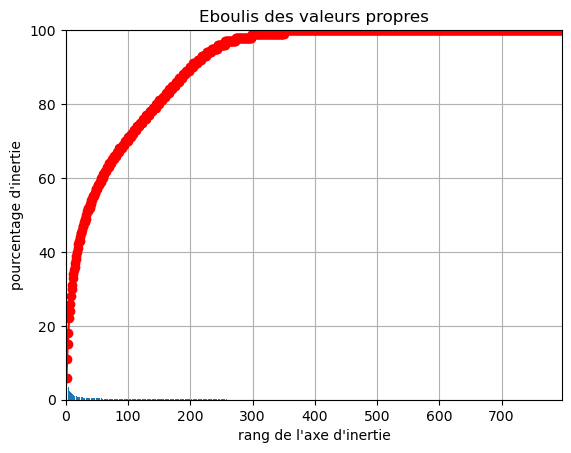

In [7]:

n_components = data_ACP.shape[1]-1
pca = decomposition.PCA(n_components=n_components)
names = data_ACP.index
features = data_ACP.columns
pca.fit(data_ACP)
scree = (pca.explained_variance_ratio_*100).round(2)
scree_cum = scree.cumsum().round()
x_list = range(1, n_components+1)
print('Variance_ratio:', pca.explained_variance_ratio_, '\n',
      'Inerties:', scree, '\n',
      'Inerties_cumulées', scree_cum)
plt.bar(x_list, scree)
plt.plot(x_list, scree_cum, c="red", marker='o')
plt.xlabel("rang de l'axe d'inertie")
plt.ylabel("pourcentage d'inertie")
plt.title("Eboulis des valeurs propres")
plt.grid()
plt.ylim(0, 100)
plt.xlim(0, data_ACP.shape[1]-1)
plt.show()

In [8]:
print(data_ACP.shape)
pca = decomposition.PCA(n_components=0.99)
feat_pca= pd.DataFrame(pca.fit_transform(data_ACP),index=data_ACP.index)
print(feat_pca.shape)

2023/10/10 10:43:20 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '0ea410ef70b64c1da463c2ef9ee86b19', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


(307507, 798)


2023/10/10 10:44:26 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.
2023/10/10 10:44:27 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


(307507, 317)


In [9]:
print(base_100.shape)
pca = decomposition.PCA(n_components=0.99)
feat_pca_100=pd.DataFrame(pca.fit_transform(base_100),index=base_100.index)
print(feat_pca_100.shape)

2023/10/10 10:44:35 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '1b7fd0300b304f5ab6470dfc823dd290', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


(307507, 101)


2023/10/10 10:44:42 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.
2023/10/10 10:44:42 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


(307507, 76)


In [10]:
print(' Tx de compression à 99% de variance sur base =',round(feat_pca.shape[1]/data_ACP.shape[1],4),'\n',
      'Tx de compression à 99% de variance sur base_100 =',round(feat_pca_100.shape[1]/base_100.shape[1],4))

 Tx de compression à 99% de variance sur base = 0.3972 
 Tx de compression à 99% de variance sur base_100 = 0.7525


La réalisation d'une ACP montre que les 100 variables retenues sont globalement importantes pour expliquer la variance <br>
Une ACP qui conserve 99% de la variance utilise 76 axes de projection sur les 101 issus de la sélection feture importance <br>
Une ACP qui conserve 99% de la variance de la base totale de 798 variables nécessite 319 axes

In [11]:
# Fonction calcul tsne et visualisation
#feat_pca, 30, cat_0#
def visu_tsne_cat(data,perplex,cat,nbr_lignes):
    temps1 = time.time()
    tsne = manifold.TSNE(n_components=2, perplexity=perplex, n_iter=2000, init='random', random_state=6)
    X_tsne = tsne.fit_transform(data[:nbr_lignes])

    duration1=time.time()-temps1
    print("temps de T-SNE : ", "%15.2f" % duration1, "secondes")

    global df_tsne
    df_tsne = pd.DataFrame(X_tsne, columns=['tsne1', 'tsne2'],index=base.index[:nbr_lignes])
    df_tsne["class"] = base[:nbr_lignes][cat]

    plt.figure(figsize=(8,5))
    sns.scatterplot(
        x="tsne1", y="tsne2",
        hue="class",
        palette='bright', s=50, alpha=0.6,
        data=df_tsne,
        legend="brief")

    plt.title('TSNE des images selon les\n principales catégories réelles', fontsize = 25, fontweight = 'bold')
    plt.xlabel('axe_1', fontsize = 15, fontweight = 'bold')
    plt.ylabel('axe_2', fontsize = 15, fontweight = 'bold')
    plt.legend(prop={'size': 14},bbox_to_anchor=(1.05, 1), loc=2)  

    plt.show()

2023/10/10 10:44:48 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '6f231c9846d149439a8cf298647a6397', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


2023/10/10 10:45:14 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.
2023/10/10 10:45:14 WARNING mlflow.sklearn: Failed to infer model signature: the trained model does not have a `predict` or `transform` function, which is required in order to infer the signature
2023/10/10 10:45:14 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


temps de T-SNE :            32.14 secondes


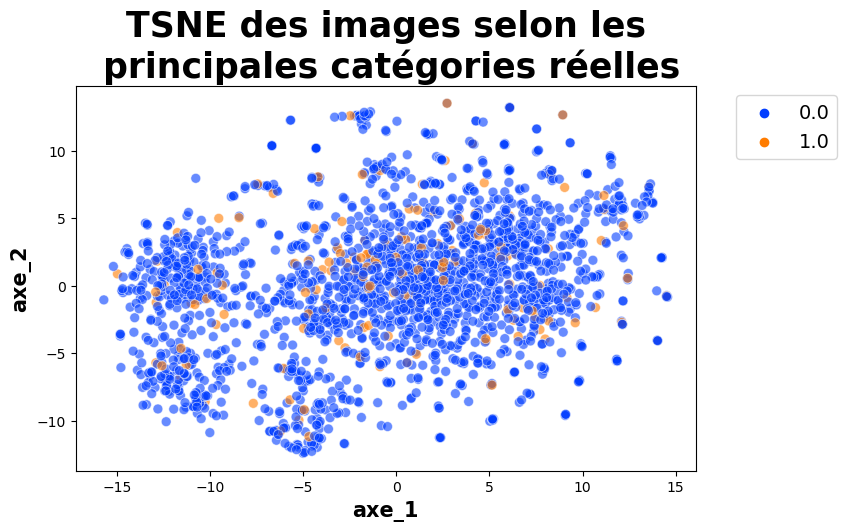

In [12]:
visu_tsne_cat(feat_pca,100,'TARGET',2000)

2023/10/10 10:45:20 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'e03c791f8abf4cf1814e1865d56b6216', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


2023/10/10 10:45:40 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.
2023/10/10 10:45:40 WARNING mlflow.sklearn: Failed to infer model signature: the trained model does not have a `predict` or `transform` function, which is required in order to infer the signature
2023/10/10 10:45:40 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


temps de T-SNE :            25.44 secondes


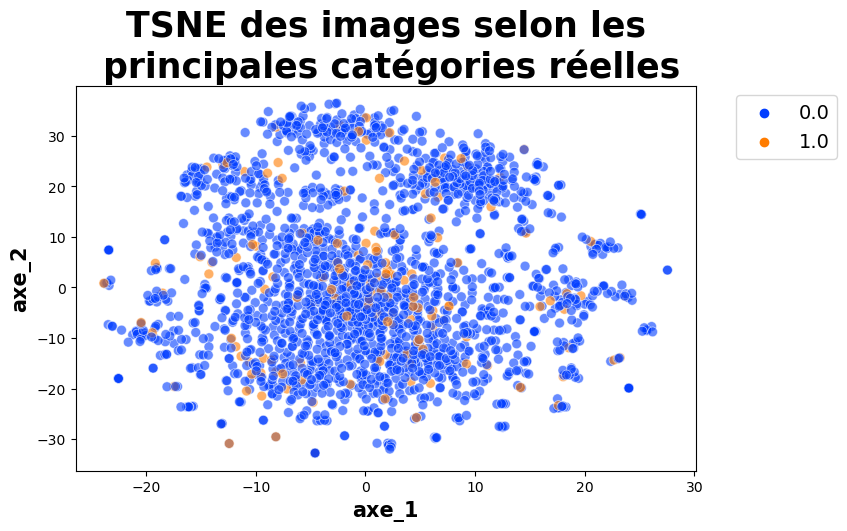

In [13]:
visu_tsne_cat(feat_pca,50,'TARGET',2000)

2023/10/10 10:45:46 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '54dd7059ce9a4055b95fbb42cd36e049', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


2023/10/10 10:46:00 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.
2023/10/10 10:46:00 WARNING mlflow.sklearn: Failed to infer model signature: the trained model does not have a `predict` or `transform` function, which is required in order to infer the signature
2023/10/10 10:46:00 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


temps de T-SNE :            19.18 secondes


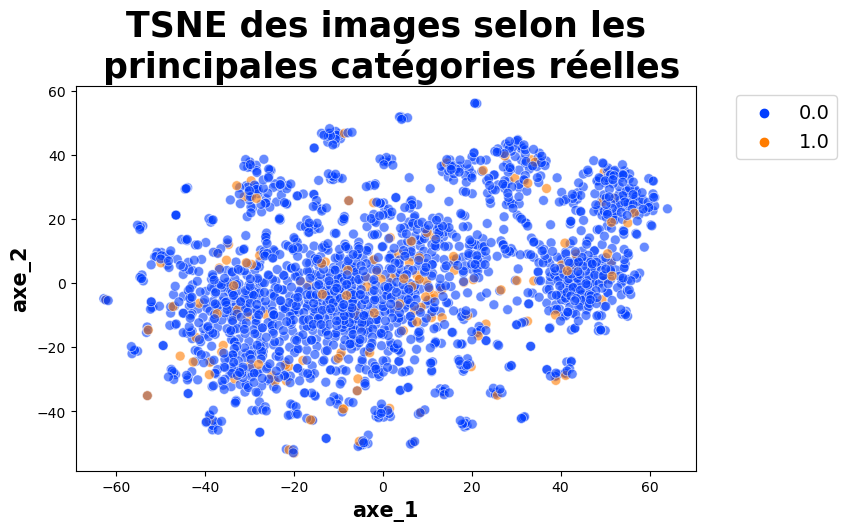

In [14]:
visu_tsne_cat(feat_pca,20,'TARGET',2000)

2023/10/10 10:46:05 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'eb3bad6a5c714a778fdcaa367333c6a8', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


2023/10/10 10:46:30 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.
2023/10/10 10:46:30 WARNING mlflow.sklearn: Failed to infer model signature: the trained model does not have a `predict` or `transform` function, which is required in order to infer the signature
2023/10/10 10:46:30 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


temps de T-SNE :            29.74 secondes


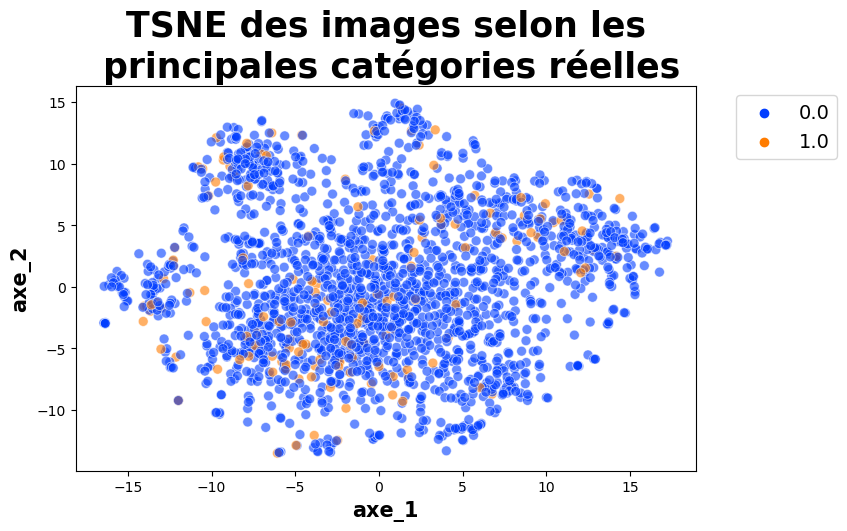

In [15]:
visu_tsne_cat(feat_pca_100,100,'TARGET',2000)

# Modèles de classification

## 3: Définition des jeux test/train

In [6]:
# Création des jeux train/test initiaux, _0 indique toutes variables
X_train_0, X_test_0, y_train_0, y_test_0=train_test_split(base.loc[base['TARGET']>-1].drop('TARGET',axis=1), 
                                                          base.loc[base['TARGET']>-1,'TARGET'], 
                                                          test_size=0.20,
                                                          random_state=8)

# _100 indique uniquement les 100 variables les plus importantes selon l'algo lgbm
X_train_100=X_train_0[var_lgbm_100[:100]]
X_test_100=X_test_0[var_lgbm_100[:100]]

# Séparation entre un jeu "Ext" contnent uniquement les variables ext_sources (variables très déterminantes) et un jeu 'Aut' contenant le reste
X_train_100_Ext=X_train_100[['EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3']]
X_test_100_Ext=X_test_100[['EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3']]
X_train_100_Aut=X_train_100.drop(['EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3'],axis=1)
X_test_100_Aut=X_test_100.drop(['EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3'],axis=1)

In [7]:
# Sélection aléatoire d'un % donné du jeu de train pour les tests d'algo
# id_random liste des index sélectionnées aléatoirement
def pct_training(x):
    global id_random
    id_random=np.array(random.sample(X_train_0.index.to_list(),round(x/100*X_train_0.shape[0])))
    return print("Entrainement du modèle sur liste id_random calculée comme sélection aléatoire de",x,"% du jeu de train total")

In [8]:
pct_training(10)

Entrainement du modèle sur liste id_random calculée comme sélection aléatoire de 10 % du jeu de train total


In [9]:
X_train_0.shape,y_train_0.shape,X_test_0.shape,y_test_0.shape

((246005, 797), (246005,), (61502, 797), (61502,))

In [10]:
# Code pour générer un ensemble X,y avec taille données et under ou oversampling:
def undersampling(X_train,y_train):
    # taille de la classe minoritaire (1 ici) dans y_train
    taille_classe_ref= y_train.loc[y_train==1].shape[0]  

    # sélection aléatoire d'indices de X_train de la classe majoritaire de la taille de la classe ref minoritaire
    index_undersampl=np.array(random.sample(X_train.loc[y_train.loc[y_train==0].index].index.to_list(),taille_classe_ref))

    # return des concaténations X_train[indices undersampling], X_train[indices y_train=minoritaire] et y_train idem
    return (pd.concat([X_train.loc[index_undersampl],X_train.loc[y_train==1]],axis=0),
            pd.concat([y_train.loc[index_undersampl],y_train.loc[y_train==1]],axis=0))



In [11]:
X_train_temp,y_train_temp=undersampling(X_train_100,y_train_0)

In [12]:
X_train_temp.shape,y_train_temp.shape,y_train_temp.value_counts(),y_train_0.value_counts()

((39540, 100),
 (39540,),
 TARGET
 0.0    19770
 1.0    19770
 Name: count, dtype: int64,
 TARGET
 0.0    226235
 1.0     19770
 Name: count, dtype: int64)

In [13]:
# Code pour générer un ensemble X,y avec taille données et under ou oversampling:
def oversampling(X_train,y_train):
    # taille de la classe majoritaire (0 ici) dans y_train
    taille_classe_ref= y_train.loc[y_train==0].shape[0]
    nbr_a_rajouter=  int(taille_classe_ref - y_train.loc[y_train==1].shape[0])

    # sélection aléatoire d'indices de X_train de la classe minoritaire de la taille de la classe ref minoritaire
    index_oversampl=np.array(random.choices(X_train.loc[y_train.loc[y_train==1].index].index.to_list(),k=nbr_a_rajouter))

    # return des concaténations X_train[indices undersamplin], X_train[indices y_train=minoritaire] et y_train idem
    return (pd.concat([X_train.loc[index_oversampl],X_train],axis=0),
            pd.concat([y_train.loc[index_oversampl],y_train],axis=0))

In [14]:
X_train_temp,y_train_temp=oversampling(X_train_100,y_train_0)

In [15]:
X_train_temp.shape,y_train_temp.shape,y_train_temp.value_counts(),y_train_0.value_counts()

((452470, 100),
 (452470,),
 TARGET
 1.0    226235
 0.0    226235
 Name: count, dtype: int64,
 TARGET
 0.0    226235
 1.0     19770
 Name: count, dtype: int64)

## 4: Fonctions d'évaluation et de visualisation

In [16]:

temps1 = time.time()
duration1=time.time()-temps1
print("temps de training ", "%5.2f" % duration1, "secondes")



temps de training   0.00 secondes


In [17]:
def balanced_accuracy(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tpr = cm[1, 1] / (cm[1, 1] + cm[1, 0])  # True Positive Rate (Recall)
    tnr = cm[0, 0] / (cm[0, 0] + cm[0, 1])  # True Negative Rate
    balanced_acc = 0.5 * (tpr + tnr)
    return balanced_acc

In [18]:
def scores(array_ref,array_pred):
    
    return print('', 'precision_test =',round(metrics.average_precision_score(array_ref, array_pred),4),'\n',
                     'accuracy_test =',round(metrics.accuracy_score(array_ref, array_pred),4),'\n',
                     'ARI_test =',round(adjusted_rand_score(array_ref, array_pred),4),'\n', 
                    'Balanced_accuracy =',round(balanced_accuracy(array_ref, array_pred),4),'\n',
                    "F1-score =", round(metrics.f1_score(array_ref, array_pred),4))
                    
    

In [19]:
def eval_Gsearch(grid_search_objet,fonction_score,nbre_top):

    indices_top = np.argsort(grid_search_objet.cv_results_['mean_test_'+fonction_score])[::-1][:nbre_top]
    top_score=[grid_search_objet.cv_results_['mean_test_'+fonction_score][i] for i in indices_top]
    top_score_params=[grid_search_objet.cv_results_['params'][i] for i in indices_top]
    
    for rank, (params, score) in enumerate(zip(top_score_params, top_score), start=1):
        print(f"Rank {rank}: Params = {params}, Mean {fonction_score} = {score:.4f}")
    

In [20]:
def eval_Gsearch_uniscore(grid_search_objet,nbre_top):

    indices_top = np.argsort(grid_search_objet.cv_results_['mean_test_score'])[::-1][:nbre_top]
    top_score=[grid_search_objet.cv_results_['mean_test_score'][i] for i in indices_top]
    top_score_params=[grid_search_objet.cv_results_['params'][i] for i in indices_top]
    
    for rank, (params, score) in enumerate(zip(top_score_params, top_score), start=1):
        print(f"Rank {rank}: Params = {params}, Mean score = {score:.4f}")

In [21]:
def heatmap_Gsearch(grid_search_objet,fonction_score,nbre_top,param1,param2):

    def get_param_value(param_dict, param_name):
        if isinstance(param_dict, dict):
            return str(param_dict.get(param_name, ''))
        return param_dict
    
    param1_values = [get_param_value(d, param1) for d in grid_search_objet.cv_results_['params']] 
    param2_values = [get_param_value(d, param2) for d in grid_search_objet.cv_results_['params']]


    param1_values = [d[param1] for d in grid_search_objet.cv_results_['params']] 
    param2_values = [d[param2] for d in grid_search_objet.cv_results_['params']]
    mean_test_scores = grid_search_objet.cv_results_['mean_test_'+fonction_score]

    
    df = pd.DataFrame({param1: param1_values, param2: param2_values, fonction_score: mean_test_scores})

    
    pivot_table = df.pivot_table(index=param1, columns=param2, values=fonction_score)

    
    plt.figure(figsize=(10, 6))
    sns.heatmap(pivot_table, annot=True, fmt='.4f', cmap='coolwarm', cbar=True)
    plt.title('Hyperparameter Heatmap')
    plt.xlabel(param1)
    plt.ylabel(param2)
    return plt.show()

In [22]:
def heatmap_Gsearch_uniscore(grid_search_objet,nbre_top,param1,param2):

    def get_param_value(param_dict, param_name):
        if isinstance(param_dict, dict):
            return str(param_dict.get(param_name, ''))
        return param_dict
    
    param1_values = [get_param_value(d, param1) for d in grid_search_objet.cv_results_['params']] 
    param2_values = [get_param_value(d, param2) for d in grid_search_objet.cv_results_['params']]
    mean_test_scores = grid_search_objet.cv_results_['mean_test_score']

    
    df = pd.DataFrame({param1: param1_values, param2: param2_values, 'score': mean_test_scores})

    
    pivot_table = df.pivot_table(index=param1, columns=param2, values='score')

    
    plt.figure(figsize=(10, 6))
    sns.heatmap(pivot_table, annot=True, fmt='.4f', cmap='coolwarm', cbar=True)
    plt.title('Hyperparameter Heatmap')
    plt.xlabel(param1)
    plt.ylabel(param2)
    return plt.show()

## 5: Fonctions cout

In [24]:
# définition d'une fonction de coût
def recap_gain(valeur_pret,indic_pb_paie,tx_rdmt,tx_rcvrmt,détail):
    temp=pd.DataFrame(index=valeur_pret.index)
    if valeur_pret.min()<0:
        temp['Prets']=(valeur_pret-valeur_pret.min()).copy()
    else:
        temp['Prets']=valeur_pret.copy()
    
    #indic_pb_paie : 0 si ok => gain=pret *tx_ rdmt, 1 si pb => perte=pret*(1-tx_rcvrmt)
    temp['Gain']=(temp['Prets']*(1-indic_pb_paie)*tx_rdmt).copy()
    temp['Perte']=-(temp['Prets']*indic_pb_paie*(1-tx_rcvrmt)).copy()

    rdmt_ptf=(temp['Gain'].sum()+temp['Perte'].sum())/temp['Prets'].sum()

    if détail==1:           
        print('Valeur des prêts =',round(temp['Prets'].sum(),2))
        print('Gain de rendement des prêts remboursés =',round(temp['Gain'].sum(),2))
        print('Perte liées aux prêts non remboursés =',round(temp['Perte'].sum(),2)) 
        print('Rendement global (Gain-Perte)/Valeur =',round(rdmt_ptf,4)*100,'%')

    elif détail==2:
        return temp

    elif détail==0:
        return [round(temp['Prets'].sum(),2),round(temp['Gain'].sum(),2),round(temp['Perte'].sum(),2),round(rdmt_ptf,4)*100]

In [24]:
# def recap_gain(valeur_pret,indic_pb_paie,tx_rdmt,tx_rcvrmt):
#     temp=pd.DataFrame(index=valeur_pret.index)
#     if valeur_pret.min()<0:
#         temp['Prets']=(valeur_pret-valeur_pret.min()).copy()
#     else:
#         temp['Prets']=valeur_pret.copy()
    
#     #indic_pb_paie : 0 si ok => gain=pret *tx_ rdmt, 1 si pb => perte=pret*(1-tx_rcvrmt)
#     temp['Gain']=(temp['Prets']*(1-indic_pb_paie)*tx_rdmt).copy()
#     temp['Perte']=-(temp['Prets']*indic_pb_paie*(1-tx_rcvrmt)).copy()
                   
#     rdmt_ptf=(temp['Gain'].sum()+temp['Perte'].sum())/temp['Prets'].sum()
#     return round(rdmt_ptf,4)*100

In [25]:
# cout algorithmique diff entré réalité et modèle
def cout_algo(valeur_pret,indic_reel,indic_pred,tx_rdmt,tx_rcvrmt,quantile_seuil,détail):

    # valeur_pret: colonne des valeurs de prets
    # indic_reel: colonne des 0/1 "TARGET"
    # indic_pred: colonne des 0/1 issus du modèle
    # tx_rdmt: tx de rendement sur un pret remboursé
    # tx_rcvrmt: tx de recouvrement d'un pret mal remboursé
    # quantile_seuil: quantile en dessous duquel tous les prets sont autorisés. 0 indique que flag 1 du modèle = non accordé dans tous les cas
    # détail: niveau de détail de sortie: 2= dataframe,1=print,0=bracket valeurs
    
    temp=pd.DataFrame(index=valeur_pret.index)
    if valeur_pret.min()<0:
        temp['Prets']=(valeur_pret-valeur_pret.min()).copy()
    else:
        temp['Prets']=valeur_pret.copy()
    
    temp['reel']=indic_reel
    temp['pred']=indic_pred
    
    temp['TP']=(temp['Prets']*(1-temp['reel'])*(1-temp['pred'])*tx_rdmt).copy() # tx_rdmt ssi reel et pred de 0
    temp['FN']=-(temp['Prets']*(temp['reel'])*(1-temp['pred'])*(1-tx_rcvrmt)).copy() # perte de -x*(1-rcvrmt) ssi reel 1 et pred de 0 (accordé à tort)
    temp['FP']=((1-temp['reel'])*(temp['pred'])*np.where(temp['Prets']<=np.quantile(temp['Prets'],quantile_seuil),temp['Prets']*tx_rdmt,0)).copy()
    temp['TN']=((temp['reel'])*(temp['pred'])*np.where(temp['Prets']<=np.quantile(temp['Prets'],quantile_seuil),-temp['Prets']*(1-tx_rcvrmt),0))

    rdmt_ptf=(temp[['TP','FP']].sum().sum()+temp[['TN','FN']].sum().sum())/temp['Prets'].sum()

    if détail==1:             
        print('Valeur des prêts accordés =',round(temp['Prets'].sum(),2))
        print('Gain de rendement des prêts prédits remboursés =',round(temp[['TP','FP']].sum().sum(),2))
        print('Perte liées aux prêts prédits non remboursés =',round(temp[['TN','FN']].sum().sum(),2))
        print('Rendement global prédit (Gain-Perte)/Valeur =',round(rdmt_ptf,4)*100,'%')
    elif détail==2:
        return temp
    else:
        return [round(temp['Prets'].sum(),2),round(temp[['TP','FP']].sum().sum(),2),round(temp[['TN','FN']].sum().sum(),2),round(rdmt_ptf,4)*100]

    

### Rdmt ptf de training:

In [27]:
recap_gain(base.loc[y_train_0.index,'AMT_CREDIT'],base.loc[y_train_0.index,'TARGET'],tx_rdmt=0.1,tx_rcvrmt=0.3,détail=1)

Valeur des prêts = 338458.74
Gain de rendement des prêts remboursés = 31335.52
Perte liées aux prêts non remboursés = -17572.47
Rendement global (Gain-Perte)/Valeur = 4.07 %


### Gain/perte unitaire


In [28]:
def gain_unit(x,valeur_pret,indic_pb_paie,tx_rdmt,tx_rcvrmt):
    temp=pd.DataFrame(index=[x])
    if valeur_pret.min()<0:
        temp['Prets']=(valeur_pret[x]-valeur_pret.min()).copy()
    else:
        temp['Prets']=valeur_pret[x].copy()
    
    #indic_pb_paie : 0 si ok => gain=pret *tx_ rdmt, 1 si pb => perte=pret*(1-tx_rcvrmt)
    temp['Gain']=(temp['Prets']*(1-indic_pb_paie)*tx_rdmt).copy()
    temp['Perte']=(temp['Prets']*indic_pb_paie*(1-tx_rcvrmt)).copy()
                   
    print('Valeur des prêts =',round(temp['Prets'].sum(),2))
    print('Gain de rendement des prêts remboursés =',round(temp['Gain'].sum(),3))
    print('Perte liées aux prêts non remboursés =',round(temp['Perte'].sum(),3))
    rdmt_ptf=(temp['Gain'].sum()-temp['Perte'].sum())/temp['Prets'].sum()
    print('Rendement global (Gain-Perte)/Valeur =',round(rdmt_ptf,4)*100,'%')

In [29]:
gain_unit(198983,base.loc[y_train_0.index,'AMT_CREDIT'],base.loc[y_train_0.index,'TARGET'],0.1,0.3)

Valeur des prêts = 0.31
Gain de rendement des prêts remboursés = 0.0
Perte liées aux prêts non remboursés = 0.217
Rendement global (Gain-Perte)/Valeur = -70.0 %


In [30]:
gain_unit(414513,base.loc[y_train_0.index,'AMT_CREDIT'],base.loc[y_train_0.index,'TARGET'],0.1,0.3)

Valeur des prêts = 1.96
Gain de rendement des prêts remboursés = 0.196
Perte liées aux prêts non remboursés = 0.0
Rendement global (Gain-Perte)/Valeur = 10.0 %


In [31]:
base.loc[y_train_0.index,'TARGET'][198983],base.loc[y_train_0.index,'AMT_CREDIT'][198983]

(1.0, -1.0669)

In [32]:
y_train_0.index

Index([198983, 414513, 223476, 441310, 420086, 368294, 336742, 136954, 330050,
       325660,
       ...
       137887, 343375, 330392, 410071, 373785, 368215, 396661, 273321, 130165,
       181302],
      dtype='int64', name='ID', length=246005)

## dummy

In [16]:
dummy_clf= DummyClassifier(strategy='most_frequent')

temps1 = time.time()
dummy_clf.fit(X_train_0,y_train_0)
duration1=time.time()-temps1
print("temps de training ", "%5.2f" % duration1, "secondes")
y_pred_0_dummyfreq = dummy_clf.predict(X_test_0)

2023/09/21 11:14:23 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'bfe38c5ea8cf43989e97d70b3b3b940d', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
c:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
2023/09/21 11:15:09 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\ProgramData\Anaconda3\lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils."


temps de training  46.80 secondes


In [17]:
scores(y_test_0, y_pred_0_dummyfreq)


 precision_test = 0.0822 
 accuracy_test = 0.9178 
 ARI_test = 0.0 
 Balanced_accuracy = 0.5 
 F1-score = 0.0


In [167]:
dummy_clf= DummyClassifier(strategy='stratified')

temps1 = time.time()
dummy_clf.fit(X_train_0,y_train_0)
duration1=time.time()-temps1
print("temps de training ", "%5.2f" % duration1, "secondes")
y_pred_0_dummystrat = dummy_clf.predict(X_test_0)

2023/10/10 16:14:27 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'e76091a52d564160af216c48e0d589b7', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


temps de training  47.10 secondes


In [168]:
scores(y_test_0,y_pred_0_dummystrat)

 precision_test = 0.0819 
 accuracy_test = 0.8503 
 ARI_test = -0.004 
 Balanced_accuracy = 0.4976 
 F1-score = 0.0766


In [169]:
display(pd.crosstab(y_test_0,y_pred_0_dummystrat,normalize='index').round(3),
        pd.crosstab(y_test_0,y_pred_0_dummystrat).round(3)
)

col_0,0.0,1.0
TARGET,,
0.0,0.920,0.080
1.0,0.924,0.076


col_0,0.0,1.0
TARGET,,
0.0,51911,4536
1.0,4673,382


In [170]:
recap_gain_txt(base.loc[y_test_0.index,'AMT_CREDIT'],y_pred_0_dummystrat,0.1,0.3)

Valeur des prêts = 84824.08
Gain de rendement des prêts remboursés = 7802.77
Perte liées aux prêts non remboursés = 4757.45
Rendement global (Gain-Perte)/Valeur = 3.5900000000000003 %


In [193]:
y_test_0.index

Index([108234, 185062, 190324, 429675, 318237, 323480, 155788, 143272, 226236,
       122105,
       ...
       260151, 332153, 298536, 297821, 350151, 344036, 425591, 251935, 161979,
       386926],
      dtype='int64', name='ID', length=61502)

In [195]:
gain_unit(108234,base.loc[y_test_0.index,'AMT_CREDIT'],pd.Series(y_pred_0_dummystrat,index=y_test_0.index),0.1,0.3)

Valeur des prêts = 1.34
Gain de rendement des prêts remboursés = 0.134
Perte liées aux prêts non remboursés = 0.0
Rendement global (Gain-Perte)/Valeur = 10.0 %


In [21]:
dummy_clf= DummyClassifier(strategy='most_frequent')

temps1 = time.time()
dummy_clf.fit(X_train_100,y_train_0)
duration1=time.time()-temps1
print("temps de training ", "%5.2f" % duration1, "secondes")
y_pred_100_dummyfreq = dummy_clf.predict(X_test_100)

2023/09/21 11:16:03 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '2099fc9b24b842c3b95b4b7332373cc3', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


c:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


temps de training  10.36 secondes


In [22]:
scores(y_test_0, y_pred_100_dummyfreq)


 precision_test = 0.0822 
 accuracy_test = 0.9178 
 ARI_test = 0.0 
 Balanced_accuracy = 0.5 
 F1-score = 0.0


In [23]:
dummy_clf= DummyClassifier(strategy='stratified')

temps1 = time.time()
dummy_clf.fit(X_train_100,y_train_0)
duration1=time.time()-temps1
print("temps de training ", "%5.2f" % duration1, "secondes")
y_pred_100_dummystrat = dummy_clf.predict(X_test_100)

2023/09/21 11:16:15 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '8326bb4b3c14474099e10978c9fc0e8d', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


temps de training  10.70 secondes


In [24]:
scores(y_test_0, y_pred_100_dummystrat)


 precision_test = 0.0824 
 accuracy_test = 0.8519 
 ARI_test = 0.0022 
 Balanced_accuracy = 0.5013 
 F1-score = 0.0832


## kmeans

In [ ]:
kmeans = KMeans(n_clusters=2,random_state=8)
X_kmeans=base.loc[base['TARGET']>-1].drop('TARGET',axis=1)
temps1 = time.time()
kmeans.fit(X_kmeans)
duration1=time.time()-temps1
print("temps de training ", "%5.2f" % duration1, "secondes")
kmeans_pred_0=pd.Series(kmeans.labels_,index=X_kmeans.index)


2023/09/13 17:11:43 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '6b80ea4e110c486f852c5e3e6d40b070', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
c:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
2023/09/13 17:14:12 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.


temps de training  156.74 secondes


In [ ]:
pd.crosstab(base.loc[base['TARGET']>-1,'TARGET'],kmeans_pred_0)

col_0,0,1
TARGET,,
0.0,202194,80488
1.0,17826,6999


In [ ]:
scores(base.loc[base['TARGET']>-1,'TARGET'],kmeans_pred)


 precision_test = 0.0805 
 accuracy_test = 0.6803 
 ARI_test = -0.0007


In [199]:
kmeans = KMeans(n_clusters=2,random_state=8)
X_kmeans=X_train_100
temps1 = time.time()
kmeans.fit(X_kmeans)
duration1=time.time()-temps1
print("temps de training ", "%5.2f" % duration1, "secondes")
kmeans_pred_100=pd.Series(kmeans.labels_,index=X_kmeans.index)

2023/10/10 17:37:14 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'c2c87438f16542619015c6ce98f28952', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2023/10/10 17:37:24 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.


temps de training  15.36 secondes


In [208]:
np.unique(kmeans.labels_, return_counts=True)

(array([0, 1]), array([ 51809, 194196], dtype=int64))

In [209]:
# 0 et 1 du k_means sont atribués aléatoirements, attention

In [203]:
scores(y_train_0,1-kmeans_pred_100)


 precision_test = 0.0778 
 accuracy_test = 0.7366 
 ARI_test = -0.0157 
 Balanced_accuracy = 0.4788 
 F1-score = 0.0948


In [204]:
pd.crosstab(y_train_0,1-kmeans_pred_100)

col_0,0,1
TARGET,,
0.0,177820,48415
1.0,16376,3394


In [205]:
recap_gain_txt(base.loc[y_train_0.index,'AMT_CREDIT'],1-kmeans_pred_100,0.1,0.3)

Valeur des prêts = 338458.74
Gain de rendement des prêts remboursés = 23756.36
Perte liées aux prêts non remboursés = 70626.61
Rendement global (Gain-Perte)/Valeur = -13.850000000000001 %


## randomforest

In [ ]:
with mlflow.start_run():
    mlflow.log_param("max_depth", 3)
    clf = RandomForestClassifier(n_estimators=10,max_depth=3)
    clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test)

mlflow.end_run()

c:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
pd.crosstab(y_test,y_pred).round(3)

col_0,0.0
TARGET,
0.0,56447
1.0,5055


In [ ]:
with mlflow.start_run():
    mlflow.log_param("max_depth", 4)
    clf = RandomForestClassifier(n_estimators=30,max_depth=4)
    clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test)

mlflow.end_run()

c:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
pd.crosstab(y_test,y_pred).round(3)

col_0,0.0
TARGET,
0.0,56447
1.0,5055


In [ ]:
with mlflow.start_run():
    mlflow.log_param("max_depth", 5)
    clf = RandomForestClassifier(n_estimators=50,max_depth=5)
    clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test)

mlflow.end_run()

c:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
pd.crosstab(y_test,y_pred).round(3)

col_0,0.0
TARGET,
0.0,56447
1.0,5055


In [ ]:
with mlflow.start_run():
    mlflow.log_param("max_depth", 6)
    clf = RandomForestClassifier(n_estimators=50,max_depth=6)
    clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test)
    pd.crosstab(y_test,y_pred).round(3)

mlflow.end_run()

c:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
2023/09/12 17:03:49 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID cb1b53a8e78c4b61a9af17b7de55c0d6. Failed operations: [MlflowException("Changing param values is not allowed. Param with key=\'max_depth\' was already logged with value=\'5\' for run ID=\'cb1b53a8e78c4b61a9af17b7de55c0d6\'. Attempted logging new value \'6\'.")]')]


In [ ]:
pd.crosstab(y_test,y_pred).round(3)

col_0,0.0
TARGET,
0.0,56447
1.0,5055


In [ ]:
with mlflow.start_run():
    mlflow.log_param("max_depth", 7)
    clf = RandomForestClassifier(n_estimators=75,max_depth=7)
    clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test)
    pd.crosstab(y_test,y_pred).round(3)

mlflow.end_run()

c:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
with mlflow.start_run():
    mlflow.log_param("max_depth", 8)
    clf = RandomForestClassifier(n_estimators=75,max_depth=8)
    clf.fit(X_train,y_train)
    y_pred_8 = clf.predict(X_test)
    display(pd.crosstab(y_test,y_pred_8).round(3))

mlflow.end_run()

col_0,0.0
TARGET,
0.0,56447
1.0,5055


## decision_tree_classifier

In [118]:
len(id_random)

73802

### fonction gridsearch pour decision tree

In [17]:

param_grid = {
    'max_depth': [25,50,100,200,400,800,5000],
    
    
}

scoring_list = ['balanced_accuracy']

# Create an instance of the model you want to tune (e.g., SVC)
model = DecisionTreeClassifier()

# Create a GridSearchCV object
temps1 = time.time()
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='balanced_accuracy')
duration1=time.time()-temps1
print("temps de training ", "%5.2f" % duration1, "secondes")

# Fit the grid search to your data
grid_search.fit(X_train_0.loc[id_random], y_train_0.loc[id_random])

# Print the best hyperparameters and corresponding score
print("Best hyperparameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

temps de training   0.00 secondes


2023/09/15 11:14:22 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'bc57f5efdb25464bac4fc51bc4a38102', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2023/09/15 12:44:05 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\ProgramData\Anaconda3\lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils."
2023/09/15 12:44:10 INFO mlflow.sklearn.utils: Logging the 5 best runs, 2 runs will be omitted.


Best hyperparameters: {'max_depth': 400}
Best cross-validation score: 0.5451845612513354


In [30]:
csv_file = '1_outputs/gridsearch_decisiontree.csv'

# Write the dictionary to a CSV file
with open(csv_file, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    
    # Write the header row (keys)
    writer.writerow(['Key', 'Value'])
    
    # Write the data rows (key-value pairs)
    for key, value in grid_search.cv_results_.items():
        writer.writerow([key, value])

In [39]:
dict_test=pd.read_csv('1_outputs/gridsearch_decisiontree.csv')

In [232]:
# grid_search.cv_results_

In [226]:
grid_search.cv_results_.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_criterion', 'param_max_depth', 'param_max_features', 'params', 'split0_test_accuracy', 'split1_test_accuracy', 'split2_test_accuracy', 'split3_test_accuracy', 'split4_test_accuracy', 'mean_test_accuracy', 'std_test_accuracy', 'rank_test_accuracy', 'split0_test_precision', 'split1_test_precision', 'split2_test_precision', 'split3_test_precision', 'split4_test_precision', 'mean_test_precision', 'std_test_precision', 'rank_test_precision', 'split0_test_recall', 'split1_test_recall', 'split2_test_recall', 'split3_test_recall', 'split4_test_recall', 'mean_test_recall', 'std_test_recall', 'rank_test_recall', 'split0_test_f1', 'split1_test_f1', 'split2_test_f1', 'split3_test_f1', 'split4_test_f1', 'mean_test_f1', 'std_test_f1', 'rank_test_f1'])

In [198]:
# indices_top_5_precision = np.argsort(grid_search.cv_results_['mean_test_precision'])[::-1][:5]
# top_5_precision=[grid_search.cv_results_['mean_test_precision'][i] for i in indices_top_5_precision]
# top_5_precision_params=[grid_search.cv_results_['params'][i] for i in indices_top_5_precision]



In [199]:
# # Print the top 5 hyperparameter combinations, their 'params' values, and 'mean_test_accuracy'
# for rank, (params, prec) in enumerate(zip(top_5_precision_params, top_5_precision), start=1):
#     print(f"Rank {rank}: Params = {params}, Mean Test Accuracy = {prec:.4f}")

Rank 1: Params = {'criterion': 'gini', 'max_depth': 5, 'max_features': 600}, Mean Test Accuracy = 0.2785
Rank 2: Params = {'criterion': 'gini', 'max_depth': 10, 'max_features': 600}, Mean Test Accuracy = 0.1941
Rank 3: Params = {'criterion': 'gini', 'max_depth': 5, 'max_features': 200}, Mean Test Accuracy = 0.1906
Rank 4: Params = {'criterion': 'entropy', 'max_depth': 5, 'max_features': 50}, Mean Test Accuracy = 0.1798
Rank 5: Params = {'criterion': 'gini', 'max_depth': 5, 'max_features': 50}, Mean Test Accuracy = 0.1774


In [19]:
eval_Gsearch_uniscore(grid_search,20)#,eval_Gsearch(grid_search,'recall',5),eval_Gsearch(grid_search,'accuracy',5)

Rank 1: Params = {'max_depth': 400}, Mean score = 0.5452
Rank 2: Params = {'max_depth': 100}, Mean score = 0.5449
Rank 3: Params = {'max_depth': 5000}, Mean score = 0.5445
Rank 4: Params = {'max_depth': 200}, Mean score = 0.5438
Rank 5: Params = {'max_depth': 50}, Mean score = 0.5438
Rank 6: Params = {'max_depth': 800}, Mean score = 0.5437
Rank 7: Params = {'max_depth': 25}, Mean score = 0.5431


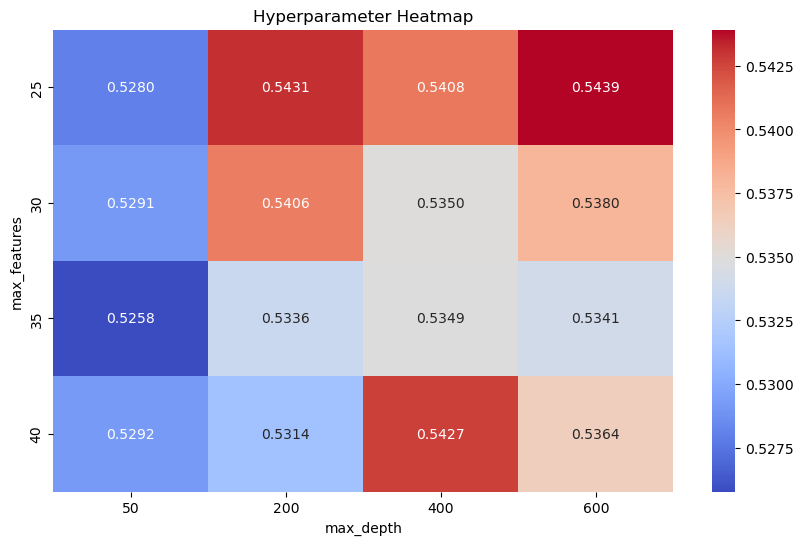

In [272]:
#heatmap_Gsearch(grid_search,'balanced_accuracy',20,'max_depth','max_features')

In [262]:
[d['max_depth'] for d in grid_search.cv_results_['params']]

[25, 25, 25, 25, 30, 30, 30, 30, 35, 35, 35, 35, 40, 40, 40, 40]

In [23]:

duration1=time.time()-temps1
print("temps de training ", "%5.2f" % duration1, "secondes")
y_pred_dtclf_0=grid_search.predict(X_test_0)
display(pd.crosstab(y_test_0,y_pred_dtclf_0).round(3),scores(y_test_0,y_pred_dtclf_0))


temps de training  7991.63 secondes
 precision_test = 0.0938 
 accuracy_test = 0.8497 
 ARI_test = 0.0646 
 Balanced_accuracy = 0.5426


col_0,0.0,1.0
TARGET,,
0.0,51372,5075
1.0,4170,885


None

In [241]:
scores(y_test_0,y_pred_dtclf_0)

 precision_test = 0.0934 
 accuracy_test = 0.8874 
 ARI_test = 0.0706 
 Balanced_accuracy = 0.5329


In [ ]:
selected_params = {'criterion': 'gini', 'max_depth': 5, 'max_features': 600}

model = DecisionTreeClassifier(criterion=selected_params['criterion'],
                                max_depth=selected_params['max_depth'],
                                  max_features=selected_params['max_features'])
temps1 = time.time()
model.fit(X_train_0.loc[id_random], y_train_0.loc[id_random])
duration1=time.time()-temps1
print("temps de training ", "%5.2f" % duration1, "secondes")
y_pred_dtclf_0=model.predict(X_test_0)
pd.crosstab(y_test_0,y_pred_dtclf_0).round(3)

In [219]:
pd.crosstab(y_test_0,y_pred_dtclf_0).round(3)

col_0,0.0,1.0
TARGET,,
0.0,56178,269
1.0,4959,96


In [ ]:
# 6 min

# Create a decision tree classifier
clf = DecisionTreeClassifier()

# Fit the model to your training data
temps1 = time.time()
clf.fit(X_train_0, y_train_0)
duration1=time.time()-temps1
print("temps de training ", "%5.2f" % duration1, "secondes")

# Make predictions on new data
y_pred_0 = clf.predict(X_test_0)

2023/09/13 18:08:29 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '46ec04ba6bdd4bbe9d302fe88ba2f4ef', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


temps de training  365.70 secondes


In [ ]:
pd.crosstab(y_test_0,y_pred_0).round(3)

col_0,0.0,1.0
TARGET,,
0.0,51540,4907
1.0,4113,942


In [ ]:
scores(y_test_0,y_pred_0)

 precision_test = 0.0969 
 accuracy_test = 0.8533 
 ARI_test = 0.0765


In [28]:
taille_sample=0.1
id_random=np.array(random.sample(X_train_0.index.to_list(),round(taille_sample*X_train_0.shape[0])))
y_train_0[id_random].value_counts()

param_grid = {
    'max_depth': [25,50,100,200,400,800,5000],    
}

scoring_list = ['balanced_accuracy']

# Create an instance of the model you want to tune (e.g., SVC)
model = DecisionTreeClassifier()

# Create a GridSearchCV object
temps1 = time.time()
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='balanced_accuracy')
duration1=time.time()-temps1
print("temps de training ", "%5.2f" % duration1, "secondes")

# Fit the grid search to your data
grid_search.fit(X_train_100.loc[id_random], y_train_0.loc[id_random])

# Print the best hyperparameters and corresponding score
print("Best hyperparameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

temps de training   0.00 secondes


2023/09/16 13:52:41 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '0a22f07c29e44ae78745ae3b5f1222bb', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2023/09/16 13:57:14 INFO mlflow.sklearn.utils: Logging the 5 best runs, 2 runs will be omitted.


Best hyperparameters: {'max_depth': 5000}
Best cross-validation score: 0.5421435841311087


In [29]:
taille_sample=0.1
id_random=np.array(random.sample(X_train_0.index.to_list(),round(taille_sample*X_train_0.shape[0])))
y_train_0[id_random].value_counts()

param_grid = {
    'max_depth': [5000,10000,50000,100000],    
}

scoring_list = ['balanced_accuracy']

# Create an instance of the model you want to tune (e.g., SVC)
model = DecisionTreeClassifier()

# Create a GridSearchCV object
temps1 = time.time()
grid_search2 = GridSearchCV(model, param_grid, cv=5, scoring='balanced_accuracy')
duration1=time.time()-temps1
print("temps de training ", "%5.2f" % duration1, "secondes")

# Fit the grid search to your data
grid_search2.fit(X_train_100.loc[id_random], y_train_0.loc[id_random])

# Print the best hyperparameters and corresponding score
print("Best hyperparameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

2023/09/16 14:19:11 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '80c9d4ba875f45fbbeb5261ca16ac39b', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


temps de training   0.00 secondes


2023/09/16 14:22:18 INFO mlflow.sklearn.utils: Logging the 5 best runs, no runs will be omitted.


Best hyperparameters: {'max_depth': 5000}
Best cross-validation score: 0.5421435841311087


In [30]:
taille_sample=0.1
id_random=np.array(random.sample(X_train_0.index.to_list(),round(taille_sample*X_train_0.shape[0])))
y_train_0[id_random].value_counts()

param_grid = {
    'max_depth': [3000,3500,4000,4500,5500,6000],    
}

scoring_list = ['balanced_accuracy']

# Create an instance of the model you want to tune (e.g., SVC)
model = DecisionTreeClassifier()

# Create a GridSearchCV object
temps1 = time.time()
grid_search2 = GridSearchCV(model, param_grid, cv=5, scoring='balanced_accuracy')
duration1=time.time()-temps1
print("temps de training ", "%5.2f" % duration1, "secondes")

# Fit the grid search to your data
grid_search2.fit(X_train_100.loc[id_random], y_train_0.loc[id_random])

# Print the best hyperparameters and corresponding score
print("Best hyperparameters:", grid_search2.best_params_)
print("Best cross-validation score:", grid_search2.best_score_)

2023/09/16 14:28:01 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'a503279a7fd04605b48ceba5169b0070', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


temps de training   0.00 secondes


2023/09/16 14:32:24 INFO mlflow.sklearn.utils: Logging the 5 best runs, one run will be omitted.


Best hyperparameters: {'max_depth': 5000}
Best cross-validation score: 0.5421435841311087


In [31]:
taille_sample=0.1
id_random=np.array(random.sample(X_train_0.index.to_list(),round(taille_sample*X_train_0.shape[0])))
y_train_0[id_random].value_counts()

param_grid = {
    'max_depth': [4900,4930,4960,4980,5020,5050,5075],    
}

scoring_list = ['balanced_accuracy']

# Create an instance of the model you want to tune (e.g., SVC)
model = DecisionTreeClassifier()

# Create a GridSearchCV object
temps1 = time.time()
grid_search3 = GridSearchCV(model, param_grid, cv=5, scoring='balanced_accuracy')
duration1=time.time()-temps1
print("temps de training ", "%5.2f" % duration1, "secondes")

# Fit the grid search to your data
grid_search3.fit(X_train_100.loc[id_random], y_train_0.loc[id_random])

# Print the best hyperparameters and corresponding score
print("Best hyperparameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

2023/09/16 14:33:34 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'dd18f0ff0db141e293b86625b021e324', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


temps de training   0.00 secondes


2023/09/16 14:38:47 INFO mlflow.sklearn.utils: Logging the 5 best runs, 2 runs will be omitted.


Best hyperparameters: {'max_depth': 5000}
Best cross-validation score: 0.5421435841311087


In [32]:
# Print the best hyperparameters and corresponding score
print("Best hyperparameters:", grid_search3.best_params_)
print("Best cross-validation score:", grid_search3.best_score_)

Best hyperparameters: {'max_depth': 4980}
Best cross-validation score: 0.5371814745548191


In [33]:
# Print the best hyperparameters and corresponding score
print("Best hyperparameters:", grid_search2.best_params_)
print("Best cross-validation score:", grid_search2.best_score_)

Best hyperparameters: {'max_depth': 4000}
Best cross-validation score: 0.535101308059061


In [34]:
taille_sample=0.1
id_random=np.array(random.sample(X_train_0.index.to_list(),round(taille_sample*X_train_0.shape[0])))
y_train_0[id_random].value_counts()

param_grid = {
    'max_depth': range(3500,5000,100),    
}

scoring_list = ['balanced_accuracy']

# Create an instance of the model you want to tune (e.g., SVC)
model = DecisionTreeClassifier()

# Create a GridSearchCV object
temps1 = time.time()
grid_search4 = GridSearchCV(model, param_grid, cv=5, scoring='balanced_accuracy')
duration1=time.time()-temps1
print("temps de training ", "%5.2f" % duration1, "secondes")

# Fit the grid search to your data
grid_search4.fit(X_train_100.loc[id_random], y_train_0.loc[id_random])

# Print the best hyperparameters and corresponding score
print("Best hyperparameters:", grid_search4.best_params_)
print("Best cross-validation score:", grid_search4.best_score_)

2023/09/16 14:45:33 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '5d6f0fd747d24200a0c97d98c93cb369', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


temps de training   0.00 secondes


2023/09/16 14:56:27 INFO mlflow.sklearn.utils: Logging the 5 best runs, 10 runs will be omitted.


Best hyperparameters: {'max_depth': 4300}
Best cross-validation score: 0.5413649081133092


In [35]:
eval_Gsearch_uniscore(grid_search4,10)

Rank 1: Params = {'max_depth': 4300}, Mean score = 0.5414
Rank 2: Params = {'max_depth': 3700}, Mean score = 0.5413
Rank 3: Params = {'max_depth': 3900}, Mean score = 0.5390
Rank 4: Params = {'max_depth': 4600}, Mean score = 0.5387
Rank 5: Params = {'max_depth': 4100}, Mean score = 0.5383
Rank 6: Params = {'max_depth': 3500}, Mean score = 0.5378
Rank 7: Params = {'max_depth': 4800}, Mean score = 0.5375
Rank 8: Params = {'max_depth': 4500}, Mean score = 0.5370
Rank 9: Params = {'max_depth': 4000}, Mean score = 0.5355
Rank 10: Params = {'max_depth': 3600}, Mean score = 0.5351


In [38]:
grid_search4.cv_results_['mean_test_score']

array([0.5378383 , 0.535087  , 0.54127902, 0.53466796, 0.53898588,
       0.53549708, 0.53828585, 0.52794536, 0.54136491, 0.53469133,
       0.53696663, 0.53868884, 0.53470057, 0.53748314, 0.53271048])

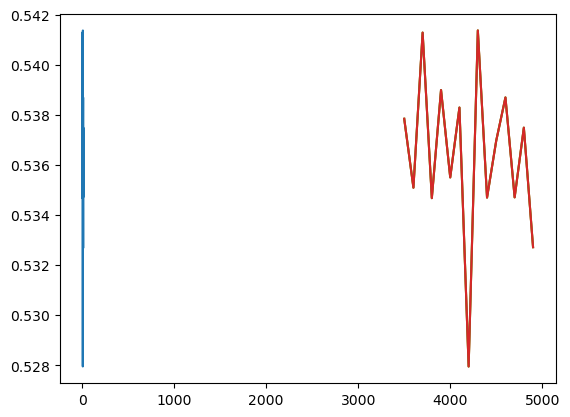

In [41]:
sns.lineplot(x=range(3500,5000,100),y=grid_search4.cv_results_['mean_test_score'])
plt.show()

In [110]:
taille_sample=0.05
id_random=np.array(random.sample(X_train_0.index.to_list(),round(taille_sample*X_train_0.shape[0])))
y_train_0[id_random].value_counts()


class_weights = {
    0: 1.0,  # Weight for class 0
    1: 10.0  # Weight for class 1
}

param_grid = {
    'max_depth': range(3500,7000,500),    
}

scoring_list = ['balanced_accuracy']

# Create an instance of the model you want to tune (e.g., SVC)
model = DecisionTreeClassifier(class_weight=class_weights)

# Create a GridSearchCV object
temps1 = time.time()
grid_search9 = GridSearchCV(model, param_grid, cv=5, scoring='balanced_accuracy')
duration1=time.time()-temps1
print("temps de training ", "%5.2f" % duration1, "secondes")

# Fit the grid search to your data
grid_search9.fit(X_train_100.loc[id_random], y_train_0.loc[id_random])

# Print the best hyperparameters and corresponding score
print("Best hyperparameters:", grid_search9.best_params_)
print("Best cross-validation score:", grid_search9.best_score_)



temps de training   0.00 secondes


2023/09/18 11:23:31 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '79ec54404fcf41a99ca92392d17e1ad9', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2023/09/18 11:25:36 INFO mlflow.sklearn.utils: Logging the 5 best runs, 2 runs will be omitted.


Best hyperparameters: {'max_depth': 4500}
Best cross-validation score: 0.5305910718961614


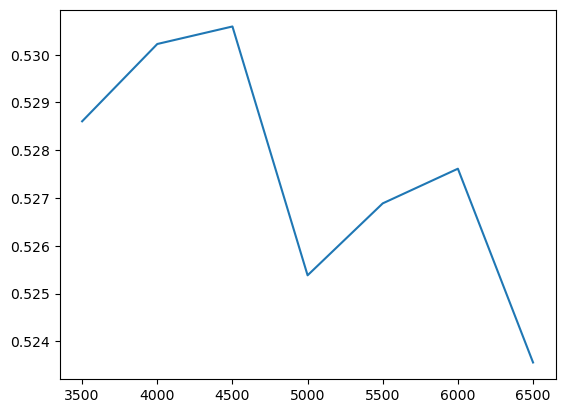

In [111]:
sns.lineplot(x=range(3500,7000,500),y=grid_search9.cv_results_['mean_test_score'])
plt.show()

In [115]:
taille_sample=0.05
id_random=np.array(random.sample(X_train_0.index.to_list(),round(taille_sample*X_train_0.shape[0])))
y_train_0[id_random].value_counts()


param_grid = {
    'max_depth': range(3800,4600,100),
    'class_weight' : [{0: 1.0, 1: 5.0},{0: 1.0, 1: 10.0},{0: 1.0, 1: 20.0},{0: 1.0, 1: 30.0}]   
}

scoring_list = ['balanced_accuracy']

# Create an instance of the model you want to tune (e.g., SVC)
model = DecisionTreeClassifier()

# Create a GridSearchCV object
temps1 = time.time()
grid_search10 = GridSearchCV(model, param_grid, cv=5, scoring='balanced_accuracy')
duration1=time.time()-temps1
print("temps de training ", "%5.2f" % duration1, "secondes")

# Fit the grid search to your data
grid_search10.fit(X_train_100.loc[id_random], y_train_0.loc[id_random])

# Print the best hyperparameters and corresponding score
print("Best hyperparameters:", grid_search10.best_params_)
print("Best cross-validation score:", grid_search10.best_score_)


2023/09/18 11:47:22 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'e6717535c1e448b5aa99f2f9b0469eb1', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


temps de training   0.00 secondes


2023/09/18 11:56:28 INFO mlflow.sklearn.utils: Logging the 5 best runs, 27 runs will be omitted.


Best hyperparameters: {'class_weight': {0: 1.0, 1: 10.0}, 'max_depth': 4500}
Best cross-validation score: 0.5497229483565251


In [121]:
grid_search11.cv_results_['mean_test_score']

array([0.536395  , 0.53329644, 0.53434429, 0.53560414, 0.53353859,
       0.53532982, 0.5363648 , 0.53340484, 0.53581528, 0.53581124,
       0.53285578, 0.53530695, 0.53459153, 0.53582835, 0.53822428,
       0.53997828, 0.5377423 , 0.5390123 , 0.53945106, 0.53707032])

In [120]:
sns.lineplot(x=range(3800,4600,100),y=grid_search11.cv_results_['mean_test_score'])
plt.show()

type: All arrays must be of the same length

In [118]:
taille_sample=0.2
id_random=np.array(random.sample(X_train_0.index.to_list(),round(taille_sample*X_train_0.shape[0])))
y_train_0[id_random].value_counts()


param_grid = {
    'max_depth': range(4200,4700,100),
    'class_weight' : [{0: 1.0, 1: 5.0},{0: 1.0, 1: 8.0},{0: 1.0, 1: 10.0},{0: 1.0, 1: 12.0}]   
}

scoring_list = ['balanced_accuracy']

# Create an instance of the model you want to tune (e.g., SVC)
model = DecisionTreeClassifier()

# Create a GridSearchCV object
temps1 = time.time()
grid_search11 = GridSearchCV(model, param_grid, cv=5, scoring='balanced_accuracy')
duration1=time.time()-temps1
print("temps de training ", "%5.2f" % duration1, "secondes")

# Fit the grid search to your data
grid_search11.fit(X_train_100.loc[id_random], y_train_0.loc[id_random])

# Print the best hyperparameters and corresponding score
print("Best hyperparameters:", grid_search11.best_params_)
print("Best cross-validation score:", grid_search11.best_score_)

2023/09/18 11:59:45 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'e87617699bfe461e8dede47bd9f198d3', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


temps de training   0.00 secondes


2023/09/18 12:22:54 INFO mlflow.sklearn.utils: Logging the 5 best runs, 15 runs will be omitted.


Best hyperparameters: {'class_weight': {0: 1.0, 1: 12.0}, 'max_depth': 4200}
Best cross-validation score: 0.5399782779448998


In [123]:
taille_sample=1
id_random=np.array(random.sample(X_train_0.index.to_list(),round(taille_sample*X_train_0.shape[0])))
y_train_0[id_random].value_counts()


param_grid = {
    'max_depth': [4500],
    'class_weight' : [{0: 1.0, 1: 8.0},{0: 1.0, 1: 10.0},{0: 1.0, 1: 12.0}]    
}

scoring_list = ['accuracy','balanced_accuracy']

# Create an instance of the model you want to tune (e.g., SVC)
model = DecisionTreeClassifier()

# Create a GridSearchCV object
temps1 = time.time()
grid_search12 = GridSearchCV(model, param_grid, cv=5, scoring=scoring_list,refit=False)
duration1=time.time()-temps1
print("temps de training ", "%5.2f" % duration1, "secondes")

# Fit the grid search to your data
grid_search12.fit(X_train_100.loc[id_random], y_train_0.loc[id_random])


temps de training   0.00 secondes


2023/09/18 12:48:10 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '2625c1f0343945f09e4b4965f24c8d68', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2023/09/18 13:10:27 WARNING mlflow.sklearn.utils: Failed to autolog metrics for GridSearchCV. Logging error: This GridSearchCV instance was initialized with `refit=False`. predict is available only after refitting on the best parameters. You can refit an estimator manually using the `best_params_` attribute
2023/09/18 13:10:28 WARNING mlflow.sklearn.utils: _get_classifier_artifacts.<locals>.plot_confusion_matrix failed. The artifact training_confusion_matrix will not be recorded. Artifact error: This GridSearchCV instance was initialized with `refit=False`. predict is available only after refitting on the best parameters. You can refit an estimator manually using the `best_params_` attribute
2023/09/18 13:10:28 WARNING mlflow.skl

type: 'GridSearchCV' object has no attribute 'best_params_'

In [124]:
grid_search12.cv_results_['params']

[{'class_weight': {0: 1.0, 1: 8.0}, 'max_depth': 4500},
 {'class_weight': {0: 1.0, 1: 10.0}, 'max_depth': 4500},
 {'class_weight': {0: 1.0, 1: 12.0}, 'max_depth': 4500}]

In [126]:
grid_search12.cv_results_['mean_test_accuracy'],grid_search12.cv_results_['mean_test_balanced_accuracy']

(array([0.86008821, 0.86056381, 0.86126705]),
 array([0.5396594 , 0.53795612, 0.53711519]))

In [129]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

In [20]:
taille_sample=0.3
id_random=np.array(random.sample(X_train_0.index.to_list(),round(taille_sample*X_train_0.shape[0])))

model_tree = DecisionTreeClassifier( max_depth=10,
                                class_weight = {0: 1.0, 1: 8.0})
temps1 = time.time()
model_tree.fit(X_train_100.loc[id_random], y_train_0.loc[id_random])
duration1=time.time()-temps1
print("temps de training ", "%5.2f" % duration1, "secondes")
y_pred_tree=model_tree.predict(X_test_100)
pd.crosstab(y_test_0,y_pred_tree).round(3)

2023/09/18 14:59:30 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '7bbc8fe0c28045729e5fe88dd2883c74', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


temps de training  20.67 secondes


col_0,0.0,1.0
TARGET,,
0.0,44144,12303
1.0,2726,2329


In [21]:
scores(y_test_0,y_pred_tree)

 precision_test = 0.1177 
 accuracy_test = 0.7556 
 ARI_test = 0.086 
 Balanced_accuracy = 0.6214


In [22]:

# Export the tree to DOT format
dot_data = export_graphviz(
    model_tree, 
    out_file=None, 
    feature_names=X_train_100.columns, 
    class_names=True, 
    filled=True, 
    rounded=True
)

# Render the tree using Graphviz
graph = graphviz.Source(dot_data)
graph.render("decision_tree")  # Save the rendered tree to a file
graph.view()  # Open the rendered tree in the default viewer


'decision_tree.pdf'

In [24]:
taille_sample=0.3
id_random=np.array(random.sample(X_train_0.index.to_list(),round(taille_sample*X_train_0.shape[0])))
y_train_0[id_random].value_counts()


param_grid = {
    'max_depth': range(3,15,1),
    'class_weight' : [{0: 1.0, 1: 8.0}]    
}

# Create an instance of the model you want to tune (e.g., SVC)
model = DecisionTreeClassifier()

# Create a GridSearchCV object
temps1 = time.time()
grid_search13 = GridSearchCV(model, param_grid, cv=5, scoring='balanced_accuracy')
duration1=time.time()-temps1
print("temps de training ", "%5.2f" % duration1, "secondes")

# Fit the grid search to your data
grid_search13.fit(X_train_100.loc[id_random], y_train_0.loc[id_random])

2023/09/18 15:02:45 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'cc55f69b42054389a026b3a954da0fe0', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


temps de training   0.00 secondes


2023/09/18 15:12:08 INFO mlflow.sklearn.utils: Logging the 5 best runs, 7 runs will be omitted.


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'class_weight': [{0: 1.0, 1: 8.0}],
                         'max_depth': range(3, 15)},
             scoring='balanced_accuracy')

In [25]:
y_pred_gridtree=grid_search13.predict(X_test_100)

In [26]:
scores(y_test_0,y_pred_gridtree)

 precision_test = 0.1245 
 accuracy_test = 0.7332 
 ARI_test = 0.0853 
 Balanced_accuracy = 0.6428


In [28]:
grid_search13.cv_results_['params'],grid_search13.cv_results_['mean_test_score']

([{'class_weight': {0: 1.0, 1: 8.0}, 'max_depth': 3},
  {'class_weight': {0: 1.0, 1: 8.0}, 'max_depth': 4},
  {'class_weight': {0: 1.0, 1: 8.0}, 'max_depth': 5},
  {'class_weight': {0: 1.0, 1: 8.0}, 'max_depth': 6},
  {'class_weight': {0: 1.0, 1: 8.0}, 'max_depth': 7},
  {'class_weight': {0: 1.0, 1: 8.0}, 'max_depth': 8},
  {'class_weight': {0: 1.0, 1: 8.0}, 'max_depth': 9},
  {'class_weight': {0: 1.0, 1: 8.0}, 'max_depth': 10},
  {'class_weight': {0: 1.0, 1: 8.0}, 'max_depth': 11},
  {'class_weight': {0: 1.0, 1: 8.0}, 'max_depth': 12},
  {'class_weight': {0: 1.0, 1: 8.0}, 'max_depth': 13},
  {'class_weight': {0: 1.0, 1: 8.0}, 'max_depth': 14}],
 array([0.64361155, 0.63755406, 0.63988719, 0.63570536, 0.63739407,
        0.62724129, 0.62689369, 0.61936915, 0.62109134, 0.6146892 ,
        0.61123154, 0.60416981]))

In [30]:
taille_sample=0.3
id_random=np.array(random.sample(X_train_0.index.to_list(),round(taille_sample*X_train_0.shape[0])))

model_tree = DecisionTreeClassifier( max_depth=3,
                                class_weight = {0: 1.0, 1: 8.0})
temps1 = time.time()
model_tree.fit(X_train_100.loc[id_random], y_train_0.loc[id_random])
duration1=time.time()-temps1
print("temps de training ", "%5.2f" % duration1, "secondes")
y_pred_tree=model_tree.predict(X_test_100)
pd.crosstab(y_test_0,y_pred_tree).round(3)


# Export the tree to DOT format
dot_data = export_graphviz(
    model_tree, 
    out_file=None, 
    feature_names=X_train_100.columns, 
    class_names=True, 
    filled=True, 
    rounded=True
)

# Render the tree using Graphviz
graph = graphviz.Source(dot_data)
graph.render("decision_tree")  # Save the rendered tree to a file
graph.view()  # Open the rendered tree in the default viewer

2023/09/18 15:20:35 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'db21e07549854f9c9baba19ac3e99324', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


temps de training  10.39 secondes


'decision_tree.pdf'

In [31]:
taille_sample=0.3
id_random=np.array(random.sample(X_train_0.index.to_list(),round(taille_sample*X_train_0.shape[0])))
y_train_0[id_random].value_counts()


param_grid = {
    'max_depth': range(3,8,1),
    'class_weight' : [{0: 1.0, 1: 8.0},{0: 1.0, 1: 3.0},{0: 1.0, 1: 20.0}]    
}

# Create an instance of the model you want to tune (e.g., SVC)
model = DecisionTreeClassifier()

# Create a GridSearchCV object
temps1 = time.time()
grid_search14 = GridSearchCV(model, param_grid, cv=5, scoring='balanced_accuracy')
duration1=time.time()-temps1
print("temps de training ", "%5.2f" % duration1, "secondes")

# Fit the grid search to your data
grid_search14.fit(X_train_100.loc[id_random], y_train_0.loc[id_random])

y_pred_grid14=grid_search14.predict(X_test_100)

2023/09/18 15:22:40 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'f3f9c647389341a6a886f7c17c1d9833', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


temps de training   0.00 secondes


2023/09/18 15:29:03 INFO mlflow.sklearn.utils: Logging the 5 best runs, 10 runs will be omitted.


In [32]:
grid_search14.cv_results_['params'],grid_search14.cv_results_['mean_test_score']

([{'class_weight': {0: 1.0, 1: 8.0}, 'max_depth': 3},
  {'class_weight': {0: 1.0, 1: 8.0}, 'max_depth': 4},
  {'class_weight': {0: 1.0, 1: 8.0}, 'max_depth': 5},
  {'class_weight': {0: 1.0, 1: 8.0}, 'max_depth': 6},
  {'class_weight': {0: 1.0, 1: 8.0}, 'max_depth': 7},
  {'class_weight': {0: 1.0, 1: 3.0}, 'max_depth': 3},
  {'class_weight': {0: 1.0, 1: 3.0}, 'max_depth': 4},
  {'class_weight': {0: 1.0, 1: 3.0}, 'max_depth': 5},
  {'class_weight': {0: 1.0, 1: 3.0}, 'max_depth': 6},
  {'class_weight': {0: 1.0, 1: 3.0}, 'max_depth': 7},
  {'class_weight': {0: 1.0, 1: 20.0}, 'max_depth': 3},
  {'class_weight': {0: 1.0, 1: 20.0}, 'max_depth': 4},
  {'class_weight': {0: 1.0, 1: 20.0}, 'max_depth': 5},
  {'class_weight': {0: 1.0, 1: 20.0}, 'max_depth': 6},
  {'class_weight': {0: 1.0, 1: 20.0}, 'max_depth': 7}],
 array([0.64355047, 0.64586746, 0.64505658, 0.63934549, 0.64029677,
        0.52921827, 0.53140469, 0.54491926, 0.54689161, 0.55153235,
        0.58682599, 0.62256801, 0.61184256, 0.62

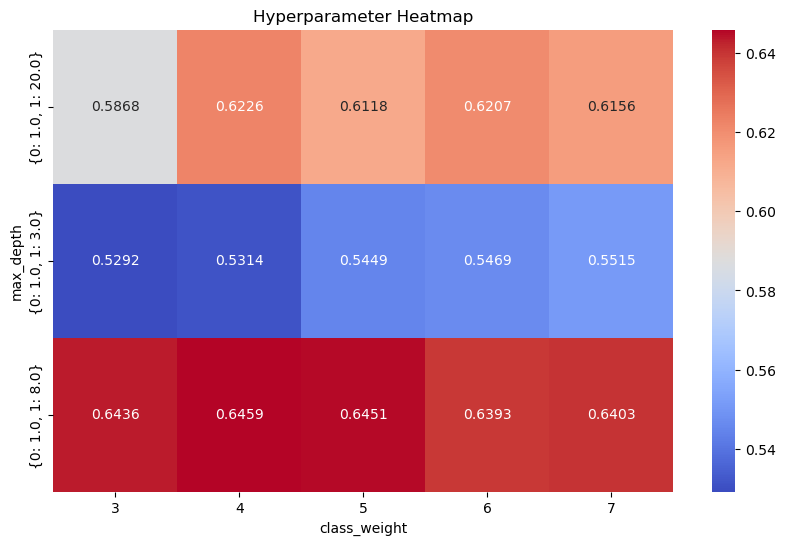

In [46]:
heatmap_Gsearch_uniscore(grid_search14,20,'class_weight','max_depth')

In [47]:
scores(y_test_0,y_pred_grid14)

 precision_test = 0.1243 
 accuracy_test = 0.7433 
 ARI_test = 0.0896 
 Balanced_accuracy = 0.6401


In [48]:
pd.crosstab(y_test_0,y_pred_grid14)

col_0,0.0,1.0
TARGET,,
0.0,43102,13345
1.0,2444,2611


In [50]:
taille_sample=0.3
id_random=np.array(random.sample(X_train_0.index.to_list(),round(taille_sample*X_train_0.shape[0])))

model_tree = DecisionTreeClassifier( max_depth=7,
                                class_weight = {0: 1.0, 1: 8.0})
temps1 = time.time()
model_tree.fit(X_train_100.loc[id_random], y_train_0.loc[id_random])
duration1=time.time()-temps1
print("temps de training ", "%5.2f" % duration1, "secondes")
y_pred_tree=model_tree.predict(X_test_100)
pd.crosstab(y_test_0,y_pred_tree).round(3)


# Export the tree to DOT format
dot_data = export_graphviz(
    model_tree, 
    out_file=None, 
    feature_names=X_train_100.columns, 
    class_names=True, 
    filled=True, 
    rounded=True
)

# Render the tree using Graphviz
graph = graphviz.Source(dot_data)
graph.render("decision_tree")  # Save the rendered tree to a file
graph.view()  # Open the rendered tree in the default viewer

2023/09/18 15:51:16 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'eb0be82835b74b979e72d54e8964a0cf', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


temps de training  15.98 secondes


'decision_tree.pdf'

In [55]:
# Get the feature importances
feature_tree = model_tree.feature_importances_

# Now, you can associate the importances with the feature names if available
feature_names = X_train_100.columns  # Assuming X_train is a DataFrame
feature_tree_dict = dict(zip(feature_names, feature_tree))
# Print or visualize the feature importances
for feature, importance in sorted(feature_tree_dict.items(), key=lambda x: x[1], reverse=True)[:10]:
    print(f"{feature}: {importance:.4f}")

EXT_SOURCE_2: 0.3408
EXT_SOURCE_3: 0.3023
EXT_SOURCE_1: 0.0796
INSTAL_AMT_PAYMENT_MIN: 0.0338
PREV_DAYS_DECISION_MEAN: 0.0168
INSTAL_DPD_MEAN: 0.0158
DAYS_EMPLOYED: 0.0140
INSTAL_AMT_PAYMENT_SUM: 0.0094
INSTAL_DAYS_ENTRY_PAYMENT_SUM: 0.0092
AMT_GOODS_PRICE: 0.0075


In [ ]:
def eval_Gsearch(grid_search_objet,fonction_score,nbre_top):

    indices_top = np.argsort(grid_search_objet.cv_results_['mean_test_'+fonction_score])[::-1][:nbre_top]
    top_score=[grid_search_objet.cv_results_['mean_test_'+fonction_score][i] for i in indices_top]
    top_score_params=[grid_search_objet.cv_results_['params'][i] for i in indices_top]
    
    for rank, (params, score) in enumerate(zip(top_score_params, top_score), start=1):
        print(f"Rank {rank}: Params = {params}, Mean {fonction_score} = {score:.4f}")

In [54]:
eval_Gsearch_uniscore(grid_search14,20)

Rank 1: Params = {'class_weight': {0: 1.0, 1: 8.0}, 'max_depth': 4}, Mean score = 0.6459
Rank 2: Params = {'class_weight': {0: 1.0, 1: 8.0}, 'max_depth': 5}, Mean score = 0.6451
Rank 3: Params = {'class_weight': {0: 1.0, 1: 8.0}, 'max_depth': 3}, Mean score = 0.6436
Rank 4: Params = {'class_weight': {0: 1.0, 1: 8.0}, 'max_depth': 7}, Mean score = 0.6403
Rank 5: Params = {'class_weight': {0: 1.0, 1: 8.0}, 'max_depth': 6}, Mean score = 0.6393
Rank 6: Params = {'class_weight': {0: 1.0, 1: 20.0}, 'max_depth': 4}, Mean score = 0.6226
Rank 7: Params = {'class_weight': {0: 1.0, 1: 20.0}, 'max_depth': 6}, Mean score = 0.6207
Rank 8: Params = {'class_weight': {0: 1.0, 1: 20.0}, 'max_depth': 7}, Mean score = 0.6156
Rank 9: Params = {'class_weight': {0: 1.0, 1: 20.0}, 'max_depth': 5}, Mean score = 0.6118
Rank 10: Params = {'class_weight': {0: 1.0, 1: 20.0}, 'max_depth': 3}, Mean score = 0.5868
Rank 11: Params = {'class_weight': {0: 1.0, 1: 3.0}, 'max_depth': 7}, Mean score = 0.5515
Rank 12: Param

### essai en enelveant ext_source1_2_3 => var les plus importantes de trop loin

In [57]:
taille_sample=0.3
id_random=np.array(random.sample(X_train_0.index.to_list(),round(taille_sample*X_train_0.shape[0])))
y_train_0[id_random].value_counts()


param_grid = {
    'max_depth': range(3,8,1),
    'class_weight' : [{0: 1.0, 1: 8.0},{0: 1.0, 1: 3.0},{0: 1.0, 1: 20.0}]    
}

# Create an instance of the model you want to tune (e.g., SVC)
model = DecisionTreeClassifier()

# Create a GridSearchCV object
temps1 = time.time()
grid_search15 = GridSearchCV(model, param_grid, cv=5, scoring='balanced_accuracy')
duration1=time.time()-temps1
print("temps de training ", "%5.2f" % duration1, "secondes")

# Fit the grid search to your data
grid_search15.fit(X_train_100.drop(['EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3'],axis=1).loc[id_random], y_train_0.loc[id_random])

y_pred_grid15=grid_search15.predict(X_test_100.drop(['EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3'],axis=1))

2023/09/18 16:35:46 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'd898caaeb64a445b878c3595131e70d8', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


temps de training   0.00 secondes


2023/09/18 16:41:27 INFO mlflow.sklearn.utils: Logging the 5 best runs, 10 runs will be omitted.


In [63]:
y_pred_grid15=grid_search15.predict(X_test_100.drop(['EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3'],axis=1))

In [66]:
eval_Gsearch_uniscore(grid_search15,5)

Rank 1: Params = {'class_weight': {0: 1.0, 1: 8.0}, 'max_depth': 5}, Mean score = 0.5962
Rank 2: Params = {'class_weight': {0: 1.0, 1: 8.0}, 'max_depth': 7}, Mean score = 0.5940
Rank 3: Params = {'class_weight': {0: 1.0, 1: 8.0}, 'max_depth': 6}, Mean score = 0.5910
Rank 4: Params = {'class_weight': {0: 1.0, 1: 8.0}, 'max_depth': 4}, Mean score = 0.5904
Rank 5: Params = {'class_weight': {0: 1.0, 1: 8.0}, 'max_depth': 3}, Mean score = 0.5862


In [64]:
scores(y_test_0,y_pred_grid15)

 precision_test = 0.1029 
 accuracy_test = 0.8076 
 ARI_test = 0.0785 
 Balanced_accuracy = 0.574


In [97]:
29/46,32/53

(0.6304347826086957, 0.6037735849056604)

### grid/série/graph types erreurs

In [26]:
df_result=pd.concat([y_test_0,pd.Series(y_pred_grid16,index=y_test_0.index,name='pred')],axis=1)
df_result['erreurs']=list(zip(df_result['pred'],df_result['TARGET']))
df_result

,TARGET,pred,erreurs
ID,,,
108234,0.0,0.0,"(0.0, 0.0)"
185062,0.0,1.0,"(1.0, 0.0)"
190324,0.0,0.0,"(0.0, 0.0)"
429675,0.0,0.0,"(0.0, 0.0)"
318237,0.0,0.0,"(0.0, 0.0)"
...,...,...,...
344036,0.0,0.0,"(0.0, 0.0)"
425591,0.0,0.0,"(0.0, 0.0)"
251935,0.0,0.0,"(0.0, 0.0)"


In [28]:
display(pd.crosstab(y_test_0,y_pred_grid16),pd.crosstab(y_test_0,y_pred_grid16,normalize='index').round(2))

col_0,0.0,1.0
TARGET,,
0.0,44524,11923
1.0,2521,2534


col_0,0.0,1.0
TARGET,,
0.0,0.79,0.21
1.0,0.50,0.50


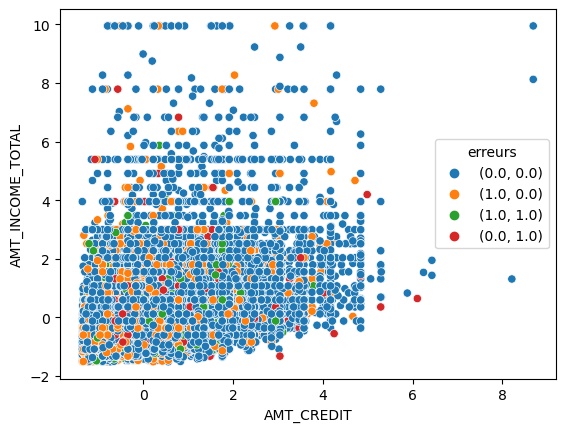

In [29]:
sns.scatterplot(x=X_test_0['AMT_CREDIT'],y=X_test_0['AMT_INCOME_TOTAL'],hue=df_result['erreurs'])
plt.show()

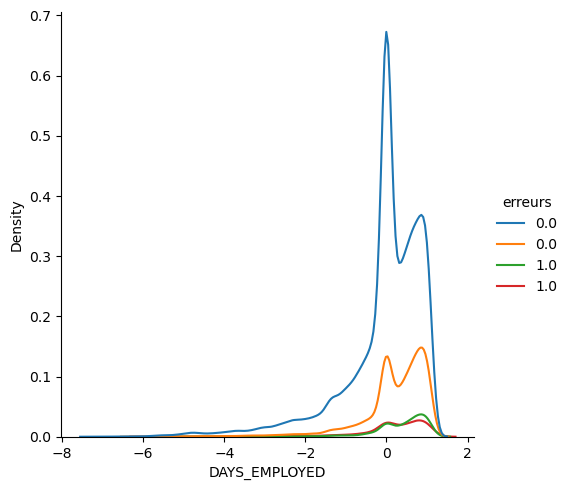

In [39]:
sns.displot(x=X_test_0['DAYS_EMPLOYED'], kind="kde",hue=df_result['erreurs'])
plt.show()

In [68]:
model=grid_search15.best_estimator_
data=X_train_100.drop(['EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3'],axis=1)

feature_tree_dict = dict(zip(data.columns, model.feature_importances_))
# Print or visualize the feature importances
for feature, importance in sorted(feature_tree_dict.items(), key=lambda x: x[1], reverse=True)[:10]:
    print(f"{feature}: {importance:.4f}")

DAYS_EMPLOYED: 0.3042
BURO_DAYS_CREDIT_MEAN: 0.1296
INSTAL_DPD_MEAN: 0.0787
INSTAL_AMT_PAYMENT_MIN: 0.0783
BURO_DAYS_CREDIT_ENDDATE_MEAN: 0.0707
PREV_DAYS_DECISION_MEAN: 0.0689
REGION_POPULATION_RELATIVE: 0.0504
PREV_APP_CREDIT_PERC_MEAN: 0.0461
AMT_GOODS_PRICE: 0.0179
INSTAL_DAYS_ENTRY_PAYMENT_SUM: 0.0171


## SVC

In [49]:
# SGD classifier

2023/09/15 22:25:43 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '325842f14714467a9c832a5d01a0ccc8', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


## ada boost

### test initial

In [18]:
ada = AdaBoostClassifier()

# Fit the model to your training data
ada.fit(X_train_0, y_train_0)

# Make predictions on new data
y_pred_ada = ada.predict(X_test_0)

2023/09/15 12:44:11 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '51dce257d19d4332aca8be82c9e81bd1', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


In [24]:
scores(y_test_0,y_pred_ada)

 precision_test = 0.0942 
 accuracy_test = 0.9173 
 ARI_test = 0.0454 
 Balanced_accuracy = 0.5144


In [25]:
pd.crosstab(y_test_0,y_pred_ada).round(3)

col_0,0.0,1.0
TARGET,,
0.0,56252,195
1.0,4892,163


### grid search learning rate n_estimator

In [30]:

param_grid = {
    
    'learning_rate':[0.1,0.5,1,2],
    'n_estimators':[50,100,200]
    
    
}

scoring_list = ['balanced_accuracy']

# Create an instance of the model you want to tune (e.g., SVC)
model = AdaBoostClassifier(algorithm='SAMME')

# Create a GridSearchCV object
temps1 = time.time()
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='balanced_accuracy')
duration1=time.time()-temps1
print("temps de training ", "%5.2f" % duration1, "secondes")

# Fit the grid search to your data
grid_search.fit(X_train_0.loc[id_random], y_train_0.loc[id_random])

# Print the best hyperparameters and corresponding score
print("Best hyperparameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

temps de training   0.00 secondes


2023/09/15 15:25:42 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'b5750a51080642cea8cfb32dd1c09aac', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2023/09/15 19:00:02 INFO mlflow.sklearn.utils: Logging the 5 best runs, 7 runs will be omitted.


Best hyperparameters: {'learning_rate': 1, 'n_estimators': 200}
Best cross-validation score: 0.5145595761400814


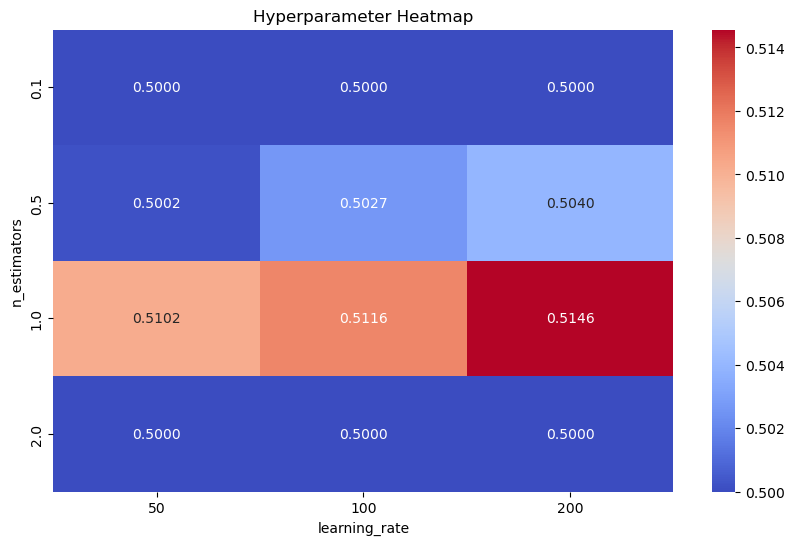

In [34]:
heatmap_Gsearch_uniscore(grid_search,20,'learning_rate','n_estimators')

In [37]:
ada = AdaBoostClassifier(learning_rate=1, n_estimators=200)

# Fit the model to your training data
ada.fit(X_train_0.loc[id_random], y_train_0.loc[id_random])

# Make predictions on new data
y_pred_ada = ada.predict(X_test_0)

2023/09/15 19:32:03 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '38e77d263ed9401b8b562d898991d3a5', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


In [38]:
pd.crosstab(y_test_0,y_pred_ada).round(3)

col_0,0.0,1.0
TARGET,,
0.0,56029,418
1.0,4757,298


In [39]:
scores(y_test_0,y_pred_ada)

 precision_test = 0.1019 
 accuracy_test = 0.9159 
 ARI_test = 0.0768 
 Balanced_accuracy = 0.5258


In [41]:
ada = AdaBoostClassifier(learning_rate=1, n_estimators=300)

# Fit the model to your training data
ada.fit(X_train_0.loc[id_random], y_train_0.loc[id_random])
#id_random à 10% du total
# Make predictions on new data
y_pred_ada2 = ada.predict(X_test_0)

2023/09/15 19:56:27 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '6d7646672bb648f881c59498436f6e12', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


In [42]:
scores(y_test_0,y_pred_ada2)

 precision_test = 0.1 
 accuracy_test = 0.9124 
 ARI_test = 0.0809 
 Balanced_accuracy = 0.5286


In [43]:
pd.crosstab(y_test_0,y_pred_ada2).round(3)

col_0,0.0,1.0
TARGET,,
0.0,55765,682
1.0,4705,350


In [15]:
taille_sample=0.05
id_random=np.array(random.sample(X_train_0.index.to_list(),round(taille_sample*X_train_0.shape[0])))

ada = AdaBoostClassifier(learning_rate=1, n_estimators=500)

# Fit the model to your training data
ada.fit(X_train_100.loc[id_random], y_train_0.loc[id_random])
#id_random à 10% du total
# Make predictions on new data
y_pred_ada3 = ada.predict(X_test_100)

2023/09/16 10:34:38 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '95e55aefcad042aba9167fbccc5c49a3', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


In [23]:
scores(y_test_0,y_pred_ada3)

 precision_test = 0.097 
 accuracy_test = 0.9079 
 ARI_test = 0.0779 
 Balanced_accuracy = 0.529


In [24]:
pd.crosstab(y_test_0,y_pred_ada3).round(3)

col_0,0.0,1.0
TARGET,,
0.0,55456,991
1.0,4673,382


In [25]:
#2h avec 0.05% du train

taille_sample=0.05
id_random=np.array(random.sample(X_train_0.index.to_list(),round(taille_sample*X_train_0.shape[0])))

ada = AdaBoostClassifier(learning_rate=1, n_estimators=10000)

# Fit the model to your training data
ada.fit(X_train_100.loc[id_random], y_train_0.loc[id_random])
#id_random à 5% du total
# Make predictions on new data
y_pred_ada4 = ada.predict(X_test_100)

2023/09/16 10:39:15 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'cfa7cc32ff2943488226735dc3abe3d2', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


In [26]:
scores(y_test_0,y_pred_ada4)

 precision_test = 0.0991 
 accuracy_test = 0.8936 
 ARI_test = 0.0918 
 Balanced_accuracy = 0.5411


In [27]:
pd.crosstab(y_test_0,y_pred_ada4).round(3)

col_0,0.0,1.0
TARGET,,
0.0,54355,2092
1.0,4452,603


### exploration features importance / staged predi / staged proba

In [19]:
taille_sample=0.05
id_random=np.array(random.sample(X_train_0.index.to_list(),round(taille_sample*X_train_0.shape[0])))

ada = AdaBoostClassifier()

# Fit the model to your training data
ada.fit(X_train_100.loc[id_random], y_train_0.loc[id_random])
#id_random à 5% du total
# Make predictions on new data
y_pred_ada5 = ada.predict(X_test_100)

2023/09/17 16:54:19 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '003e83201b554539a9506da8c7fcc081', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


2023/09/17 16:54:40 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\ProgramData\Anaconda3\lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils."


In [22]:

ada.feature_importances_

array([0.12, 0.04, 0.06, 0.04, 0.04, 0.02, 0.02, 0.  , 0.  , 0.02, 0.02,
       0.  , 0.02, 0.02, 0.  , 0.  , 0.  , 0.02, 0.02, 0.02, 0.02, 0.  ,
       0.  , 0.  , 0.  , 0.02, 0.  , 0.02, 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.02, 0.02, 0.  , 0.  , 0.02, 0.  , 0.  , 0.  , 0.  , 0.  , 0.02,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.04, 0.02, 0.02, 0.  ,
       0.  , 0.  , 0.02, 0.02, 0.  , 0.  , 0.04, 0.02, 0.  , 0.  , 0.  ,
       0.04, 0.02, 0.  , 0.02, 0.  , 0.  , 0.02, 0.  , 0.  , 0.02, 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.04, 0.02, 0.  , 0.  ,
       0.  , 0.02, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  ])

In [25]:
ada.estimators_[1]

DecisionTreeClassifier(max_depth=1, random_state=701562198)

In [27]:
# Initialize an empty list to store staged predictions
staged_predictions = []

# Loop through each stage and get the staged decision function
for stage_predictions in ada.staged_decision_function(X_test_100):
    staged_predictions.append(stage_predictions)



In [28]:
staged_predictions

[array([-2.66487949, -2.66487949, -2.66487949, ..., -2.66487949,
        -2.66487949, -2.66487949]),
 array([-1.20236832, -1.20236832, -1.6468666 , ..., -1.20236832,
        -1.20236832, -1.6468666 ]),
 array([-1.09935003, -0.75814163, -1.05447381, ..., -1.09935003,
        -1.09935003, -1.05447381]),
 array([-1.0093859 , -0.5361557 , -0.75840484, ..., -0.792062  ,
        -1.0093859 , -0.75840484]),
 array([-0.82685747, -0.44827331, -0.62607262, ..., -0.65299835,
        -0.82685747, -0.62607262]),
 array([-0.6402566 , -0.39568266, -0.54384875, ..., -0.495374  ,
        -0.71116946, -0.4729359 ]),
 array([-0.54029895, -0.33066415, -0.45766365, ..., -0.41611387,
        -0.6010814 , -0.39688121]),
 array([-0.5076629 , -0.2722044 , -0.43535702, ..., -0.34697291,
        -0.56084755, -0.38217237]),
 array([-0.47475886, -0.21992217, -0.41048696, ..., -0.3319233 ,
        -0.52203409, -0.36321172]),
 array([-0.43844134, -0.20908832, -0.38059663, ..., -0.26216677,
        -0.48098905, -0.29

In [31]:
# Initialize an empty list to store staged predictions
staged_proba = []

# Loop through each stage and get the staged decision function
for proba in ada.staged_predict_proba(X_test_100):
    staged_proba.append(proba)

In [43]:
pd.Series(staged_proba[1][:,0]).value_counts(),pd.Series(staged_proba[1][:,1]).value_counts()

(0.768946    31490
 0.838467    19871
 0.665216     6882
 0.756046     3259
 Name: count, dtype: int64,
 0.231054    31490
 0.161533    19871
 0.334784     6882
 0.243954     3259
 Name: count, dtype: int64)

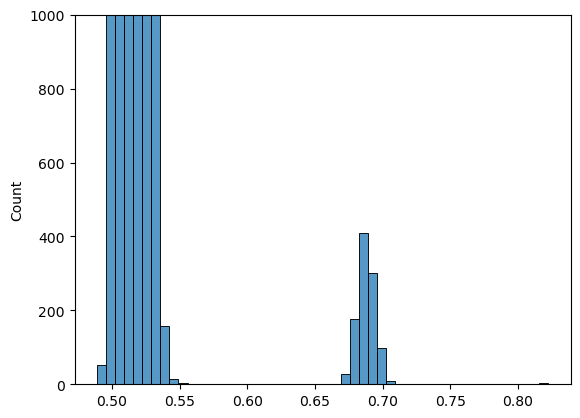

In [68]:
temp_serie=pd.Series(staged_proba[49][:,0])
sns.histplot(x=temp_serie.values,bins=50)
plt.ylim(0,1000)
plt.show()


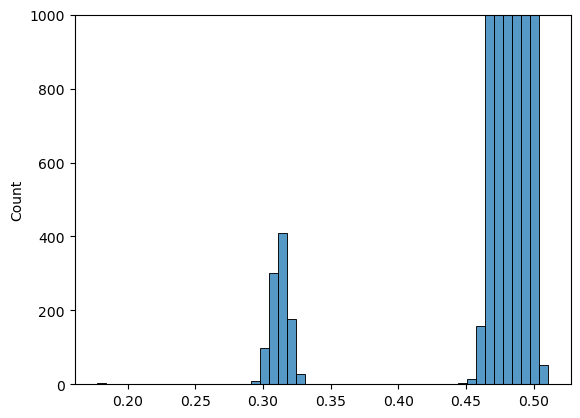

In [69]:
temp_serie=pd.Series(staged_proba[49][:,1])
sns.histplot(x=temp_serie.values,bins=50)
plt.ylim(0,1000)
plt.show()

In [67]:
temp_serie.describe()

count    61502.000000
mean         0.518023
std          0.023166
min          0.489124
25%          0.510603
50%          0.515030
75%          0.519780
max          0.822505
dtype: float64

In [62]:
temp_serie

0        0.522205
1        0.506065
2        0.519701
3        0.509677
4        0.516539
           ...   
61497    0.510153
61498    0.514840
61499    0.512895
61500    0.522413
61501    0.519993
Length: 61502, dtype: float64

In [ ]:
pd.Series(staged_proba[49][:,1]).value_counts()

In [46]:
len(staged_proba)

50

In [20]:
scores(y_test_0,y_pred_ada5)

 precision_test = 0.095 
 accuracy_test = 0.9161 
 ARI_test = 0.0537 
 Balanced_accuracy = 0.5175


In [70]:
pd.crosstab(y_test_0,y_pred_ada5).round(3)

col_0,0.0,1.0
TARGET,,
0.0,56141,306
1.0,4851,204


### exploration param DecisionTreeClassifier(max_depth=)

In [73]:
taille_sample=0.05
id_random=np.array(random.sample(X_train_0.index.to_list(),round(taille_sample*X_train_0.shape[0])))

ada2 = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=2))

# Fit the model to your training data
ada2.fit(X_train_100.loc[id_random], y_train_0.loc[id_random])
#id_random à 5% du total
# Make predictions on new data
y_pred_ada2 = ada2.predict(X_test_100)


2023/09/17 18:27:17 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '94aee741ea884d44b5f7b63d110cb374', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


In [74]:
scores(y_test_0,y_pred_ada2)

 precision_test = 0.0965 
 accuracy_test = 0.9101 
 ARI_test = 0.0732 
 Balanced_accuracy = 0.5264


In [85]:
#2h avec 0.05% du train

taille_sample=0.1
id_random=np.array(random.sample(X_train_0.index.to_list(),round(taille_sample*X_train_0.shape[0])))

ada3 = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=3))

# Fit the model to your training data
ada3.fit(X_train_100.loc[id_random], y_train_0.loc[id_random])
#id_random à 5% du total
# Make predictions on new data
y_pred_ada3 = ada3.predict(X_test_100)

2023/09/17 18:45:57 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '4d389728538145d09a4c6f654b59a6db', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


In [86]:

scores(y_test_0,y_pred_ada3)

 precision_test = 0.0982 
 accuracy_test = 0.9051 
 ARI_test = 0.0847 
 Balanced_accuracy = 0.5329


In [78]:
#2h avec 0.05% du train

taille_sample=0.05
id_random=np.array(random.sample(X_train_0.index.to_list(),round(taille_sample*X_train_0.shape[0])))

ada4 = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=4))

# Fit the model to your training data
ada4.fit(X_train_100.loc[id_random], y_train_0.loc[id_random])
#id_random à 5% du total
# Make predictions on new data
y_pred_ada4 = ada4.predict(X_test_100)

2023/09/17 18:32:06 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '8a248c0dfe354a06aa5d6687b309af2a', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


In [79]:
scores(y_test_0,y_pred_ada5)

 precision_test = 0.095 
 accuracy_test = 0.9161 
 ARI_test = 0.0537 
 Balanced_accuracy = 0.5175


In [89]:

param_grid = {  
    'estimator':[DecisionTreeClassifier(max_depth=3)],#,DecisionTreeClassifier(max_depth=4),DecisionTreeClassifier(max_depth=5)
}

scoring_list = ['balanced_accuracy']

# Create an instance of the model you want to tune (e.g., SVC)
model = AdaBoostClassifier()

# Create a GridSearchCV object
temps1 = time.time()
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='balanced_accuracy')
duration1=time.time()-temps1
print("temps de training ", "%5.2f" % duration1, "secondes")

# Fit the grid search to your data
grid_search.fit(X_train_100.loc[id_random], y_train_0.loc[id_random])

# Print the best hyperparameters and corresponding score
print("Best hyperparameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

2023/09/17 19:01:35 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '20cf36c3513b4a0ca9dd3f070d86eec8', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


temps de training   0.00 secondes


2023/09/17 19:06:37 INFO mlflow.sklearn.utils: Logging the 5 best runs, no runs will be omitted.


Best hyperparameters: {'estimator': DecisionTreeClassifier(max_depth=3)}
Best cross-validation score: 0.5349336662355875


In [91]:
pred_gd_search=grid_search.predict(X_test_100)

In [92]:
scores(y_test_0,pred_gd_search)

 precision_test = 0.0982 
 accuracy_test = 0.905 
 ARI_test = 0.0846 
 Balanced_accuracy = 0.5329


In [93]:
pd.crosstab(y_test_0,pred_gd_search)

col_0,0.0,1.0
TARGET,,
0.0,55216,1231
1.0,4612,443


In [94]:

param_grid = {   
    'estimator':[DecisionTreeClassifier(max_depth=2),DecisionTreeClassifier(max_depth=1)],#,DecisionTreeClassifier(max_depth=4),DecisionTreeClassifier(max_depth=5) 
}

scoring_list = ['balanced_accuracy']

# Create an instance of the model you want to tune (e.g., SVC)
model = AdaBoostClassifier()

# Create a GridSearchCV object
temps1 = time.time()
grid_search2 = GridSearchCV(model, param_grid, cv=5, scoring='balanced_accuracy')
duration1=time.time()-temps1
print("temps de training ", "%5.2f" % duration1, "secondes")

# Fit the grid search to your data
grid_search2.fit(X_train_100.loc[id_random], y_train_0.loc[id_random])

# Print the best hyperparameters and corresponding score
print("Best hyperparameters:", grid_search2.best_params_)
print("Best cross-validation score:", grid_search2.best_score_)

pred_gd_search2=grid_search2.predict(X_test_100)

2023/09/17 19:09:20 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '742f6fd041084523a992a84fdad8febb', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


temps de training   0.00 secondes


2023/09/17 19:13:59 INFO mlflow.sklearn.utils: Logging the 5 best runs, no runs will be omitted.


Best hyperparameters: {'estimator': DecisionTreeClassifier(max_depth=3)}
Best cross-validation score: 0.5349336662355875


In [96]:
scores(y_test_0,pred_gd_search2)

 precision_test = 0.0973 
 accuracy_test = 0.9134 
 ARI_test = 0.07 
 Balanced_accuracy = 0.5241


In [95]:
# Print the best hyperparameters and corresponding score
print("Best hyperparameters:", grid_search2.best_params_)
print("Best cross-validation score:", grid_search2.best_score_)

Best hyperparameters: {'estimator': DecisionTreeClassifier(max_depth=2)}
Best cross-validation score: 0.5304532167127815


In [97]:

param_grid = {  
    'estimator':[DecisionTreeClassifier(max_depth=4),DecisionTreeClassifier(max_depth=5)],#,DecisionTreeClassifier(max_depth=4),DecisionTreeClassifier(max_depth=5)
}

scoring_list = ['balanced_accuracy']

# Create an instance of the model you want to tune (e.g., SVC)
model = AdaBoostClassifier()

# Create a GridSearchCV object
temps1 = time.time()
grid_search3 = GridSearchCV(model, param_grid, cv=5, scoring='balanced_accuracy')
duration1=time.time()-temps1
print("temps de training ", "%5.2f" % duration1, "secondes")

# Fit the grid search to your data
grid_search3.fit(X_train_100.loc[id_random], y_train_0.loc[id_random])

# Print the best hyperparameters and corresponding score
print("Best hyperparameters:", grid_search3.best_params_)
print("Best cross-validation score:", grid_search3.best_score_)

pred_gd_search3=grid_search3.predict(X_test_100)

2023/09/17 19:16:08 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '6c3d1642cef242b1af6c3c7ce9179b6c', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


temps de training   0.00 secondes


2023/09/17 19:29:23 INFO mlflow.sklearn.utils: Logging the 5 best runs, no runs will be omitted.


Best hyperparameters: {'estimator': DecisionTreeClassifier(max_depth=4)}
Best cross-validation score: 0.5382335462237625


In [98]:
scores(y_test_0,pred_gd_search3)

 precision_test = 0.098 
 accuracy_test = 0.8969 
 ARI_test = 0.0876 
 Balanced_accuracy = 0.5376


In [100]:

param_grid = {
    'estimator':[DecisionTreeClassifier(max_depth=3)],#,DecisionTreeClassifier(max_depth=4),DecisionTreeClassifier(max_depth=5)
}

scoring_list = ['balanced_accuracy']

# Create an instance of the model you want to tune (e.g., SVC)
model = AdaBoostClassifier(algorithm='SAMME')

# Create a GridSearchCV object
temps1 = time.time()
grid_search4 = GridSearchCV(model, param_grid, cv=5, scoring='balanced_accuracy')
duration1=time.time()-temps1
print("temps de training ", "%5.2f" % duration1, "secondes")

# Fit the grid search to your data
grid_search4.fit(X_train_100.loc[id_random], y_train_0.loc[id_random])

# Print the best hyperparameters and corresponding score
print("Best hyperparameters:", grid_search4.best_params_)
print("Best cross-validation score:", grid_search4.best_score_)

pred_gd_search4=grid_search3.predict(X_test_100)

2023/09/17 19:35:08 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '89752a57e9d8432fbc7966cb40635f22', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


temps de training   0.00 secondes


2023/09/17 19:40:12 INFO mlflow.sklearn.utils: Logging the 5 best runs, no runs will be omitted.


Best hyperparameters: {'estimator': DecisionTreeClassifier(max_depth=3)}
Best cross-validation score: 0.524759716802066


In [101]:

param_grid = {   
    'estimator':[DecisionTreeClassifier(max_depth=2),DecisionTreeClassifier(max_depth=4),DecisionTreeClassifier(max_depth=5)],#,DecisionTreeClassifier(max_depth=4),DecisionTreeClassifier(max_depth=5)
}

scoring_list = ['balanced_accuracy']

# Create an instance of the model you want to tune (e.g., SVC)
model = AdaBoostClassifier(algorithm='SAMME')

# Create a GridSearchCV object
temps1 = time.time()
grid_search5 = GridSearchCV(model, param_grid, cv=5, scoring='balanced_accuracy')
duration1=time.time()-temps1
print("temps de training ", "%5.2f" % duration1, "secondes")

# Fit the grid search to your data
grid_search5.fit(X_train_100.loc[id_random], y_train_0.loc[id_random])

# Print the best hyperparameters and corresponding score
print("Best hyperparameters:", grid_search5.best_params_)
print("Best cross-validation score:", grid_search5.best_score_)

pred_gd_search5=grid_search5.predict(X_test_100)

2023/09/17 19:46:15 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'efdad51b1b5b431b9b77e12992ee66c7', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


temps de training   0.00 secondes


2023/09/17 20:01:58 INFO mlflow.sklearn.utils: Logging the 5 best runs, no runs will be omitted.


Best hyperparameters: {'estimator': DecisionTreeClassifier(max_depth=5)}
Best cross-validation score: 0.5403416336816887


In [103]:
param_grid = { 
    'estimator':[DecisionTreeClassifier(max_depth=6),DecisionTreeClassifier(max_depth=7)],
    'learning_rate':[0.1]
}

scoring_list = ['balanced_accuracy']

# Create an instance of the model you want to tune (e.g., SVC)
model = AdaBoostClassifier(algorithm='SAMME')

# Create a GridSearchCV object
temps1 = time.time()
grid_search6 = GridSearchCV(model, param_grid, cv=5, scoring='balanced_accuracy')
duration1=time.time()-temps1
print("temps de training ", "%5.2f" % duration1, "secondes")

# Fit the grid search to your data
grid_search6.fit(X_train_100.loc[id_random], y_train_0.loc[id_random])

# Print the best hyperparameters and corresponding score
print("Best hyperparameters:", grid_search6.best_params_)
print("Best cross-validation score:", grid_search6.best_score_)

pred_gd_search6=grid_search6.predict(X_test_100)

2023/09/17 20:50:25 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'e5243aa041aa401481a3ac165b53a42b', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


temps de training   0.00 secondes


2023/09/17 21:11:46 INFO mlflow.sklearn.utils: Logging the 5 best runs, no runs will be omitted.


Best hyperparameters: {'estimator': DecisionTreeClassifier(max_depth=6), 'learning_rate': 0.1}
Best cross-validation score: 0.5113223824868888


In [105]:
param_grid = {   
    'estimator':[DecisionTreeClassifier(max_depth=6),DecisionTreeClassifier(max_depth=7)],  
}

scoring_list = ['balanced_accuracy']

# Create an instance of the model you want to tune (e.g., SVC)
model = AdaBoostClassifier(algorithm='SAMME')

# Create a GridSearchCV object
temps1 = time.time()
grid_search7 = GridSearchCV(model, param_grid, cv=5, scoring='balanced_accuracy')
duration1=time.time()-temps1
print("temps de training ", "%5.2f" % duration1, "secondes")

# Fit the grid search to your data
grid_search7.fit(X_train_100.loc[id_random], y_train_0.loc[id_random])

# Print the best hyperparameters and corresponding score
print("Best hyperparameters:", grid_search7.best_params_)
print("Best cross-validation score:", grid_search7.best_score_)

pred_gd_search7=grid_search7.predict(X_test_100)

2023/09/17 21:14:32 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '90a978026626402dbb86a9cef54fbe45', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


temps de training   0.00 secondes


2023/09/17 21:39:44 INFO mlflow.sklearn.utils: Logging the 5 best runs, no runs will be omitted.


Best hyperparameters: {'estimator': DecisionTreeClassifier(max_depth=6)}
Best cross-validation score: 0.5340707577113909


In [106]:
param_grid = {   
    'estimator':[DecisionTreeClassifier(max_depth=4),DecisionTreeClassifier(max_depth=5)],#,DecisionTreeClassifier(max_depth=4),DecisionTreeClassifier(max_depth=5)
}

scoring_list = ['balanced_accuracy']

# Create an instance of the model you want to tune (e.g., SVC)
model = AdaBoostClassifier(algorithm='SAMME')

# Create a GridSearchCV object
temps1 = time.time()
grid_search8 = GridSearchCV(model, param_grid, cv=5, scoring='balanced_accuracy')


taille_sample=0.5
id_random=np.array(random.sample(X_train_0.index.to_list(),round(taille_sample*X_train_0.shape[0])))

# Fit the grid search to your data
grid_search8.fit(X_train_100.loc[id_random], y_train_0.loc[id_random])

duration1=time.time()-temps1
print("temps de training ", "%5.2f" % duration1, "secondes")

# Print the best hyperparameters and corresponding score
print("Best hyperparameters:", grid_search8.best_params_)
print("Best cross-validation score:", grid_search8.best_score_)

pred_gd_search8=grid_search8.predict(X_test_100)

2023/09/18 07:37:35 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '31972b902c1d414a8fd1c27f1b2711bc', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2023/09/18 08:47:27 INFO mlflow.sklearn.utils: Logging the 5 best runs, no runs will be omitted.


temps de training  4193.52 secondes
Best hyperparameters: {'estimator': DecisionTreeClassifier(max_depth=5)}
Best cross-validation score: 0.5251251940691014


In [108]:
pd.crosstab(y_test_0,pred_gd_search5)

col_0,0.0,1.0
TARGET,,
0.0,55322,1125
1.0,4633,422


### test de l'undersampling sur le adaboost

In [33]:
y_train_0.value_counts(),y_train_0.value_counts()[1]/y_train_0.value_counts()[0]

(TARGET
 0.0    226235
 1.0     19770
 Name: count, dtype: int64,
 0.08738700908347515)

In [34]:
taille_sample=1
id_random=np.array(random.sample(X_train_0.index.to_list(),round(taille_sample*X_train_0.shape[0])))

ada_und_1 = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=5),
                               algorithm='SAMME')
temps1 = time.time()

X_train_temp,y_train_temp=undersampling(X_train_100.loc[id_random], y_train_0.loc[id_random])
ada_und_1.fit(X_train_temp,y_train_temp)
duration1=time.time()-temps1
print("temps de training ", "%5.2f" % duration1, "secondes")

y_pred_ada_und_1 = ada_und_1.predict(X_test_100)

X_train_ada_und_1,y_train_ada_und_1=X_train_temp,y_train_temp

display(scores(y_test_0,y_pred_ada_und_1),
        pd.crosstab(y_test_0,y_pred_ada_und_1))

2023/10/12 15:45:33 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'e9850a137b8849e79d3e3e4b7ef01fb0', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2023/10/12 15:48:09 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\ProgramData\Anaconda3\lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils."


temps de training  157.70 secondes
 precision_test = 0.1354 
 accuracy_test = 0.6828 
 ARI_test = 0.0725 
 Balanced_accuracy = 0.6803 
 F1-score = 0.2598


None

col_0,0.0,1.0
TARGET,,
0.0,38570,17877
1.0,1631,3424


In [59]:
pd.Series(y_train_temp).value_counts()

TARGET
0.0    19770
1.0    19770
Name: count, dtype: int64

In [37]:
# le rendement associé à un ptf avec undersampling/oversampling est forcément très négatif => autant de prets remboursés qu'avec problèmes
recap_gain(X_train_temp['AMT_CREDIT'],y_train_temp,0.1,0.3,1)

Valeur des prêts = 52499.96
Gain de rendement des prêts remboursés = 2739.64
Perte liées aux prêts non remboursés = -17572.47
Rendement global (Gain-Perte)/Valeur = -28.249999999999996 %


In [36]:
# Prédiction de rendement d'un ptf entrainé avec undersampling
recap_gain(X_test_0['AMT_CREDIT'],y_pred_ada_und_1,0.1,0.3,1)

Valeur des prêts = 84824.08
Gain de rendement des prêts remboursés = 5770.36
Perte liées aux prêts non remboursés = -18984.3
Rendement global (Gain-Perte)/Valeur = -15.58 %


In [76]:
cout_algo(X_test_0['AMT_CREDIT'],y_test_0,y_pred_ada_und_1,0.1,0.3,0,1)

Valeur des prêts accordés = 84824.08
Gain de rendement des prêts prédits remboursés = 5534.86
Perte liées aux prêts prédits non remboursés = -1648.52
Rendement global prédit (Gain-Perte)/Valeur = 4.58 %


#### Tests sur la fonction cout_algo

In [ ]:
# sortie_test=cout_algo(X_test_0['AMT_CREDIT'],y_test_0,y_pred_ada_und_1,0.1,0.3,1,0.15)
# sortie_test

In [ ]:
# pd.crosstab(sortie_test['reel'],sortie_test['pred'])

In [ ]:
# sortie_test[['TP','FN','FP','TN']].sum().sum()/sortie_test['Prets'].sum()

In [ ]:
(base_histo.loc[base_histo['TARGET']==0,'AMT_CREDIT'].describe(),base_histo.loc[base_histo['TARGET']==1,'AMT_CREDIT'].describe())

(count    2.826820e+05
 mean     6.026512e+05
 std      4.068479e+05
 min      4.500000e+04
 25%      2.700000e+05
 50%      5.177880e+05
 75%      8.100000e+05
 max      4.050000e+06
 Name: AMT_CREDIT, dtype: float64,
 count    2.482500e+04
 mean     5.577785e+05
 std      3.464332e+05
 min      4.500000e+04
 25%      2.844000e+05
 50%      4.975200e+05
 75%      7.333155e+05
 max      4.027680e+06
 Name: AMT_CREDIT, dtype: float64)

In [ ]:
cout_algo(X_test_0['AMT_CREDIT'],y_test_0,y_pred_ada_und_1,0.20,0.3,0,0.1,0)

[84824.08, 11119.79, -1574.27, 11.25]

In [ ]:
impact_ada_param=pd.DataFrame(columns=['Prets','Gain','Perte','Rdmt'])
for i in np.linspace(0,1,21):
    impact_ada_param.loc[i,:]=cout_algo(X_test_0['AMT_CREDIT'],y_test_0,y_pred_ada_und_1,0.20,0.3,1,i,0)
impact_ada_param

,Prets,Gain,Perte,Rdmt
0.00,84824.08,11119.79,-1574.27,11.25
0.05,84824.08,11143.13,-1585.46,11.27
0.10,84824.08,11205.59,-1625.73,11.29
0.15,84824.08,11289.36,-1678.43,11.33
0.20,84824.08,11367.65,-1731.53,11.36
0.25,84824.08,11443.27,-1778.02,11.39
0.30,84824.08,11553.25,-1861.22,11.43
0.35,84824.08,11699.93,-1980.41,11.46
0.40,84824.08,11881.7,-2123.59,11.5
0.45,84824.08,12116.29,-2295.41,11.58


In [ ]:
temp=pd.DataFrame(index=np.linspace(0,0.3,11),columns=np.linspace(0.1,0.6,11))
for i in temp.columns:
    for j in temp.index:
        temp.at[j,i]=cout_algo(X_test_0['AMT_CREDIT'],y_test_0,y_pred_ada_und_1,j,i,1,0.15,0)[3]
temp

,0.10,0.15,0.20,0.25,0.30,0.35,0.40,0.45,0.50,0.55,0.60
0.00,-2.54,-2.4,-2.26,-2.12,-1.98,-1.84,-1.7,-1.55,-1.41,-1.27,-1.13
0.03,-0.55,-0.41,-0.27,-0.12,0.02,0.16,0.3,0.44,0.58,0.72,0.87
0.06,1.45,1.59,1.73,1.87,2.01,2.16,2.3,2.44,2.58,2.72,2.86
0.09,3.45,3.59,3.73,3.87,4.01,4.15,4.29,4.43,4.58,4.72,4.86
0.12,5.44,5.58,5.72,5.87,6.01,6.15,6.29,6.43,6.57,6.71,6.85
0.15,7.44,7.58,7.72,7.86,8.0,8.14,8.29,8.43,8.57,8.71,8.85
0.18,9.43,9.58,9.72,9.86,10.0,10.14,10.28,10.42,10.56,10.71,10.85
0.21,11.43,11.57,11.71,11.85,12.0,12.14,12.28,12.42,12.56,12.7,12.84
0.24,13.43,13.57,13.71,13.85,13.99,14.13,14.27,14.42,14.56,14.7,14.84
0.27,15.42,15.56,15.71,15.85,15.99,16.13,16.27,16.41,16.55,16.7,16.84


In [ ]:
temp=pd.DataFrame(index=np.linspace(0,0.3,11),columns=np.linspace(0.1,0.6,11))
for i in temp.columns:
    for j in temp.index:
        temp.at[j,i]=cout_algo(X_test_0['AMT_CREDIT'],y_test_0,y_pred_ada_und_1,j,i,0,0.05,0)[3]
temp

,0.10,0.15,0.20,0.25,0.30,0.35,0.40,0.45,0.50,0.55,0.60
0.00,-2.39,-2.25,-2.12,-1.99,-1.86,-1.72,-1.59,-1.46,-1.33,-1.19,-1.06
0.03,-0.42,-0.29,-0.15,-0.02,0.11,0.24,0.38,0.51,0.64,0.77,0.91
0.06,1.55,1.68,1.81,1.94,2.08,2.21,2.34,2.47,2.61,2.74,2.87
0.09,3.51,3.65,3.78,3.91,4.04,4.18,4.31,4.44,4.57,4.71,4.84
0.12,5.48,5.61,5.74,5.88,6.01,6.14,6.27,6.41,6.54,6.67,6.81
0.15,7.45,7.58,7.71,7.84,7.98,8.11,8.24,8.37,8.51,8.64,8.77
0.18,9.41,9.54,9.68,9.81,9.94,10.07,10.21,10.34,10.47,10.61,10.74
0.21,11.38,11.51,11.64,11.78,11.91,12.04,12.17,12.31,12.44,12.57,12.7
0.24,13.34,13.48,13.61,13.74,13.88,14.01,14.14,14.27,14.41,14.54,14.67
0.27,15.31,15.44,15.58,15.71,15.84,15.97,16.11,16.24,16.37,16.5,16.64


In [ ]:
from scipy.optimize import minimize

In [ ]:
def fun(xyz):
    x, y, z = xyz
    return -cout_algo(X_test_0['AMT_CREDIT'],y_test_0,y_pred_ada_und_1,x,y,1,z,0)[3]

In [ ]:
minimize(fun,x0=[0,0,0],bounds=[(0,0.3),(0,0.5),(0,1)],method='Powell')

 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: -23.830000000000002
       x: [ 2.999e-01  4.994e-01  9.972e-01]
     nit: 4
   direc: [[ 0.000e+00  0.000e+00  1.000e+00]
           [ 5.285e-05  8.695e-05  1.757e-04]
           [ 1.034e-05  2.134e-04  3.036e-04]]
    nfev: 382

In [ ]:
(-cout_algo(X_test_0['AMT_CREDIT'],y_test_0,y_pred_ada_und_1,0.3,0.5,1,0.15,0)[3],
-cout_algo(X_test_0['AMT_CREDIT'],y_test_0,y_pred_ada_und_1,0.3,0.5,1,0.05,0)[3],
-cout_algo(X_test_0['AMT_CREDIT'],y_test_0,y_pred_ada_und_1,0.3,0.5,1,0,0)[3],
-cout_algo(X_test_0['AMT_CREDIT'],y_test_0,y_pred_ada_und_1,0.3,0.5,1,1,0)[3])

(-18.55, -18.37, -18.34, -23.849999999999998)

In [ ]:
cout_algo(X_test_0['AMT_CREDIT'],y_test_0,y_pred_ada_und_1,0.1,0.3,0,0.15,1)

Valeur des prêts = 84824.08
Gain de rendement des prêts remboursés = 5559.89
Perte liées aux prêts non remboursés = -1574.27
Rendement global (Gain-Perte)/Valeur = 4.7 %


In [ ]:
cout_algo(X_test_0['AMT_CREDIT'],y_test_0,y_pred_ada_und_1,0.1,0.3,1,0.15,1)

Valeur des prêts = 84824.08
Gain de rendement des prêts remboursés = 5644.68
Perte liées aux prêts non remboursés = -1678.43
Rendement global (Gain-Perte)/Valeur = 4.68 %


In [ ]:
cout_algo(X_test_0['AMT_CREDIT'],y_test_0,y_pred_ada_und_1,0.1,0.3,1,0.25,1)

Valeur des prêts = 84824.08
Gain de rendement des prêts remboursés = 5721.64
Perte liées aux prêts non remboursés = -1778.02
Rendement global (Gain-Perte)/Valeur = 4.65 %


In [ ]:
cout_algo(X_test_0['AMT_CREDIT'],y_test_0,y_pred_ada_und_1,0.1,0.3,1,0.4,1)

Valeur des prêts = 84824.08
Gain de rendement des prêts remboursés = 5940.85
Perte liées aux prêts non remboursés = -2123.59
Rendement global (Gain-Perte)/Valeur = 4.5 %


In [ ]:
cout_algo(X_test_0['AMT_CREDIT'],y_test_0,y_pred_ada_und_1,0.1,0.3,1,0,1)

Valeur des prêts = 84824.08
Gain de rendement des prêts remboursés = 5559.89
Perte liées aux prêts non remboursés = -1574.27
Rendement global (Gain-Perte)/Valeur = 4.7 %


In [38]:
recap_gain(X_test_0['AMT_CREDIT'],y_test_0,0.1,0.3,1)

Valeur des prêts = 84824.08
Gain de rendement des prêts remboursés = 7830.03
Perte liées aux prêts non remboursés = -4566.67
Rendement global (Gain-Perte)/Valeur = 3.85 %


### Test oversampling

In [39]:
taille_sample=0.087 # ratio des 1 dans le total
id_random=np.array(random.sample(X_train_0.index.to_list(),round(taille_sample*X_train_0.shape[0])))

ada_ov_1 = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=5),
                               algorithm='SAMME')
temps1 = time.time()
X_train_temp,y_train_temp=oversampling(X_train_100.loc[id_random], y_train_0.loc[id_random])
ada_ov_1.fit(X_train_temp,y_train_temp)
duration1=time.time()-temps1
print("temps de training ", "%5.2f" % duration1, "secondes")

y_pred_ada_ov_1 = ada_ov_1.predict(X_test_100)

X_train_ada_ov_1,y_train_ada_ov_1=X_train_temp,y_train_temp

display(scores(y_test_0,y_pred_ada_ov_1),
        pd.crosstab(y_test_0,y_pred_ada_ov_1))

2023/10/12 15:59:35 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '07eef71d773c478e853c25f5b7b95ea3', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


temps de training  119.45 secondes
 precision_test = 0.121 
 accuracy_test = 0.8003 
 ARI_test = 0.1118 
 Balanced_accuracy = 0.618 
 F1-score = 0.2476


None

col_0,0.0,1.0
TARGET,,
0.0,47201,9246
1.0,3034,2021


In [40]:
recap_gain(X_train_ada_ov_1['AMT_CREDIT'],y_train_ada_ov_1,0.1,0.3,1)

Valeur des prêts = 52304.56
Gain de rendement des prêts remboursés = 2696.95
Perte liées aux prêts non remboursés = -17734.51
Rendement global (Gain-Perte)/Valeur = -28.749999999999996 %


In [41]:
recap_gain(X_test_0['AMT_CREDIT'],y_pred_ada_ov_1,0.1,0.3,1)

Valeur des prêts = 84824.08
Gain de rendement des prêts remboursés = 7018.28
Perte liées aux prêts non remboursés = -10248.86
Rendement global (Gain-Perte)/Valeur = -3.81 %


In [74]:
cout_algo(X_test_0['AMT_CREDIT'],y_test_0,y_pred_ada_ov_1,0.1,0.3,0,1)

Valeur des prêts accordés = 84824.08
Gain de rendement des prêts prédits remboursés = 6612.86
Perte liées aux prêts prédits non remboursés = -2837.98
Rendement global prédit (Gain-Perte)/Valeur = 4.45 %


In [42]:
X_train_ada_ov_1.shape

(39436, 100)

### Test sans modifs over/under/balance

In [43]:
# proportion à retenir pour avoir 39400 lignes d'entrainement (équiv avec les over et undersampl)
39400/y_train_0.shape[0]

0.16015934635474888

In [44]:
taille_sample=0.16
id_random=np.array(random.sample(X_train_0.index.to_list(),round(taille_sample*X_train_0.shape[0])))

ada_0_1 = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=5),
                               algorithm='SAMME')
temps1 = time.time()
X_train_temp,y_train_temp=X_train_100.loc[id_random], y_train_0.loc[id_random]
ada_0_1.fit(X_train_temp,y_train_temp)
duration1=time.time()-temps1
print("temps de training ", "%5.2f" % duration1, "secondes")

y_pred_ada_0_1 = ada_0_1.predict(X_test_100)

X_train_ada_0_1,y_train_ada_0_1=X_train_temp,y_train_temp

display(scores(y_test_0,y_pred_ada_0_1),
        pd.crosstab(y_test_0,y_pred_ada_0_1))

2023/10/12 16:10:09 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '674f17c30e124e0ea0ac8520298391fa', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


temps de training  161.16 secondes
 precision_test = 0.0985 
 accuracy_test = 0.9101 
 ARI_test = 0.0802 
 Balanced_accuracy = 0.5291 
 F1-score = 0.118


None

col_0,0.0,1.0
TARGET,,
0.0,55603,844
1.0,4685,370


In [46]:
recap_gain(X_train_ada_0_1['AMT_CREDIT'],y_train_ada_0_1,0.1,0.3,1)

Valeur des prêts = 53931.39
Gain de rendement des prêts remboursés = 4985.0
Perte liées aux prêts non remboursés = -2856.99
Rendement global (Gain-Perte)/Valeur = 3.95 %


In [48]:
recap_gain(X_test_0['AMT_CREDIT'],y_pred_ada_0_1,0.1,0.3,1)

Valeur des prêts = 84824.08
Gain de rendement des prêts remboursés = 8344.65
Perte liées aux prêts non remboursés = -964.3
Rendement global (Gain-Perte)/Valeur = 8.7 %


In [60]:
temp=recap_gain(X_test_0['AMT_CREDIT'],y_pred_ada_0_1,0.1,0.3,2)
temp

,Prets,Gain,Perte
ID,,,
108234,1.3387,0.13387,-0.0
185062,1.7158,0.17158,-0.0
190324,0.5590,0.05590,-0.0
429675,0.7622,0.07622,-0.0
318237,1.3749,0.13749,-0.0
...,...,...,...
344036,0.5948,0.05948,-0.0
425591,2.5002,0.25002,-0.0
251935,0.2236,0.02236,-0.0


In [61]:
temp.loc[temp['Perte']!=0,:]

,Prets,Gain,Perte
ID,,,
362328,1.9107,0.0,-1.33749
366415,1.6981,0.0,-1.18867
328015,0.9560,0.0,-0.66920
145915,0.7421,0.0,-0.51947
196325,0.2460,0.0,-0.17220
...,...,...,...
169235,0.5487,0.0,-0.38409
279027,0.8336,0.0,-0.58352
242066,1.0062,0.0,-0.70434


In [63]:
(temp.describe(),temp.sum())

(              Prets          Gain         Perte
 count  61502.000000  61502.000000  61502.000000
 mean       1.379208      0.135681     -0.015679
 std        1.000583      0.101415      0.128029
 min        0.000000      0.000000     -3.913140
 25%        0.559000      0.055900      0.000000
 50%        1.164100      0.115160     -0.000000
 75%        1.897300      0.189730     -0.000000
 max        9.950500      0.995050     -0.000000,
 Prets    84824.07540
 Gain      8344.65088
 Perte     -964.29662
 dtype: float64)

In [59]:
pd.crosstab(y_test_0,y_pred_ada_0_1)

col_0,0.0,1.0
TARGET,,
0.0,55603,844
1.0,4685,370


### essai avec balanced_weight

In [50]:
taille_sample=0.16
id_random=np.array(random.sample(X_train_0.index.to_list(),round(taille_sample*X_train_0.shape[0])))

ada_1_1 = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=5,class_weight = {0: 0.087, 1: 1}),
                               algorithm='SAMME',
                               )
temps1 = time.time()
X_train_temp,y_train_temp=X_train_100.loc[id_random], y_train_0.loc[id_random]
ada_1_1.fit(X_train_temp,y_train_temp)
duration1=time.time()-temps1
print("temps de training ", "%5.2f" % duration1, "secondes")

y_pred_ada_1_1 = ada_1_1.predict(X_test_100)

X_train_ada_1_1,y_train_ada_1_1=X_train_temp,y_train_temp

display(scores(y_test_0,y_pred_ada_1_1),
        pd.crosstab(y_test_0,y_pred_ada_1_1))

2023/10/12 16:18:23 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'd2c47ef16a37427a933cd4d42242d4d4', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


temps de training  20.54 secondes
 precision_test = 0.1252 
 accuracy_test = 0.6581 
 ARI_test = 0.0541 
 Balanced_accuracy = 0.659 
 F1-score = 0.2409


None

col_0,0.0,1.0
TARGET,,
0.0,37139,19308
1.0,1718,3337


In [51]:
taille_sample=0.16
id_random=np.array(random.sample(X_train_0.index.to_list(),round(taille_sample*X_train_0.shape[0])))

ada_2_1 = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=5,class_weight = {0: 0.15, 1: 1}),
                               algorithm='SAMME',
                               )
temps1 = time.time()
X_train_temp,y_train_temp=X_train_100.loc[id_random], y_train_0.loc[id_random]
ada_2_1.fit(X_train_temp,y_train_temp)
duration1=time.time()-temps1
print("temps de training ", "%5.2f" % duration1, "secondes")

y_pred_ada_2_1 = ada_2_1.predict(X_test_100)

X_train_ada_2_1,y_train_ada_2_1=X_train_temp,y_train_temp

display(scores(y_test_0,y_pred_ada_2_1),
        pd.crosstab(y_test_0,y_pred_ada_2_1))

2023/10/12 16:19:29 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'b6d7431f69dc44ba9e38157bf18eabb0', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


temps de training  25.50 secondes
 precision_test = 0.1247 
 accuracy_test = 0.8092 
 ARI_test = 0.1225 
 Balanced_accuracy = 0.6229 
 F1-score = 0.2563


None

col_0,0.0,1.0
TARGET,,
0.0,47743,8704
1.0,3033,2022


In [52]:
taille_sample=0.16
id_random=np.array(random.sample(X_train_0.index.to_list(),round(taille_sample*X_train_0.shape[0])))

ada_3_1 = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=5,class_weight = {0: 0.2, 1: 1}),
                               algorithm='SAMME',
                               )
temps1 = time.time()
X_train_temp,y_train_temp=X_train_100.loc[id_random], y_train_0.loc[id_random]
ada_3_1.fit(X_train_temp,y_train_temp)
duration1=time.time()-temps1
print("temps de training ", "%5.2f" % duration1, "secondes")

y_pred_ada_3_1 = ada_3_1.predict(X_test_100)

X_train_ada_3_1,y_train_ada_3_1=X_train_temp,y_train_temp

display(scores(y_test_0,y_pred_ada_3_1),
        pd.crosstab(y_test_0,y_pred_ada_3_1))

2023/10/12 16:20:12 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'cc3394d731414f5d8c6aaf76879b2379', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


temps de training  23.52 secondes
 precision_test = 0.1007 
 accuracy_test = 0.8037 
 ARI_test = 0.0716 
 Balanced_accuracy = 0.5687 
 F1-score = 0.194


None

col_0,0.0,1.0
TARGET,,
0.0,47978,8469
1.0,3602,1453


In [54]:
pct_training(16)

ada_4_1 = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=5,class_weight = {0: 0.1, 1: 1}),
                               algorithm='SAMME',
                               )
temps1 = time.time()
X_train_temp,y_train_temp=X_train_100.loc[id_random], y_train_0.loc[id_random]
ada_4_1.fit(X_train_temp,y_train_temp)
duration1=time.time()-temps1
print("temps de training ", "%5.2f" % duration1, "secondes")
y_pred_ada_4_1 = ada_4_1.predict(X_test_100)

X_train_ada_4_1,y_train_ada_4_1=X_train_temp,y_train_temp

display(scores(y_test_0,y_pred_ada_4_1),
        pd.crosstab(y_test_0,y_pred_ada_4_1))

2023/10/12 16:24:07 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '3b1053b8d32043718cfa6609f53250f5', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


Entrainement du modèle sur liste id_random calculée comme sélection aléatoire de 16 % du jeu de train total
temps de training  23.92 secondes
 precision_test = 0.1233 
 accuracy_test = 0.733 
 ARI_test = 0.0838 
 Balanced_accuracy = 0.64 
 F1-score = 0.2456


None

col_0,0.0,1.0
TARGET,,
0.0,42407,14040
1.0,2382,2673


In [55]:
taille_sample=0.16
id_random=np.array(random.sample(X_train_0.index.to_list(),round(taille_sample*X_train_0.shape[0])))

ada_5_1 = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=5,class_weight = {0: 0.09, 1: 1}),
                               algorithm='SAMME',
                               )
temps1 = time.time()
X_train_temp,y_train_temp=X_train_100.loc[id_random], y_train_0.loc[id_random]
ada_5_1.fit(X_train_temp,y_train_temp)
duration1=time.time()-temps1
print("temps de training ", "%5.2f" % duration1, "secondes")
y_pred_ada_5_1 = ada_5_1.predict(X_test_100)

X_train_ada_5_1,y_train_ada_5_1=X_train_temp,y_train_temp

display(scores(y_test_0,y_pred_ada_5_1),
        pd.crosstab(y_test_0,y_pred_ada_5_1))

2023/10/12 16:30:50 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '00e603d6731d4f308590fa3c0285db21', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


temps de training  20.54 secondes
 precision_test = 0.1203 
 accuracy_test = 0.6931 
 ARI_test = 0.0639 
 Balanced_accuracy = 0.6398 
 F1-score = 0.2358


None

col_0,0.0,1.0
TARGET,,
0.0,39718,16729
1.0,2143,2912


In [65]:
(recap_gain(X_test_0['AMT_CREDIT'],y_pred_ada_0_1,0.1,0.3,0),
 recap_gain(X_test_0['AMT_CREDIT'],y_pred_ada_1_1,0.1,0.3,0),
 recap_gain(X_test_0['AMT_CREDIT'],y_pred_ada_2_1,0.1,0.3,0),
 recap_gain(X_test_0['AMT_CREDIT'],y_pred_ada_3_1,0.1,0.3,0),
 recap_gain(X_test_0['AMT_CREDIT'],y_pred_ada_4_1,0.1,0.3,0),
 recap_gain(X_test_0['AMT_CREDIT'],y_pred_ada_5_1,0.1,0.3,0))

([84824.08, 25033.95, -275.51, 29.189999999999998],
 [84824.08, 17327.6, -5413.08, 14.05],
 [84824.08, 21560.74, -2590.99, 22.36],
 [84824.08, 21799.81, -2431.61, 22.830000000000002],
 [84824.08, 19152.42, -4196.54, 17.630000000000003],
 [84824.08, 17637.45, -5206.52, 14.649999999999999])

In [69]:
(cout_algo(X_test_0['AMT_CREDIT'],y_test_0,y_pred_ada_0_1,0.1,0.3,0,0),
 cout_algo(X_test_0['AMT_CREDIT'],y_test_0,y_pred_ada_1_1,0.1,0.3,0,0),
 cout_algo(X_test_0['AMT_CREDIT'],y_test_0,y_pred_ada_2_1,0.1,0.3,0,0),
 cout_algo(X_test_0['AMT_CREDIT'],y_test_0,y_pred_ada_3_1,0.1,0.3,0,0),
 cout_algo(X_test_0['AMT_CREDIT'],y_test_0,y_pred_ada_4_1,0.1,0.3,0,0),
 cout_algo(X_test_0['AMT_CREDIT'],y_test_0,y_pred_ada_5_1,0.1,0.3,0,0))

([84824.08, 7732.84, -4282.65, 4.07],
 [84824.08, 5521.98, -1777.22, 4.41],
 [84824.08, 6771.71, -2906.44, 4.5600000000000005],
 [84824.08, 6785.91, -3364.86, 4.03],
 [84824.08, 6054.12, -2310.16, 4.41],
 [84824.08, 5591.4, -2014.23, 4.22])

## recap des essais adaboost

In [88]:
display(scores(y_test_0,y_pred_ada_2_1),
        cout_algo(X_test_0['AMT_CREDIT'],y_test_0,y_pred_ada_2_1,0.1,0.3,0,0),
        pd.crosstab(y_test_0,y_pred_ada_2_1,normalize='index'))

 precision_test = 0.1247 
 accuracy_test = 0.8092 
 ARI_test = 0.1225 
 Balanced_accuracy = 0.6229 
 F1-score = 0.2563


None

[84824.08, 6771.71, -2906.44, 4.5600000000000005]

col_0,0.0,1.0
TARGET,,
0.0,0.845802,0.154198
1.0,0.600000,0.400000


In [89]:
display(scores(y_test_0,y_pred_ada_ov_1),
        cout_algo(X_test_0['AMT_CREDIT'],y_test_0,y_pred_ada_ov_1,0.1,0.3,0,0),
        pd.crosstab(y_test_0,y_pred_ada_ov_1,normalize='index'))

 precision_test = 0.121 
 accuracy_test = 0.8003 
 ARI_test = 0.1118 
 Balanced_accuracy = 0.618 
 F1-score = 0.2476


None

[84824.08, 6612.86, -2837.98, 4.45]

col_0,0.0,1.0
TARGET,,
0.0,0.836200,0.163800
1.0,0.600198,0.399802


In [90]:
display(scores(y_test_0,y_pred_ada_und_1),
        cout_algo(X_test_0['AMT_CREDIT'],y_test_0,y_pred_ada_und_1,0.1,0.3,0,0),
        pd.crosstab(y_test_0,y_pred_ada_und_1,normalize='index'))

 precision_test = 0.1354 
 accuracy_test = 0.6828 
 ARI_test = 0.0725 
 Balanced_accuracy = 0.6803 
 F1-score = 0.2598


None

[84824.08, 5534.86, -1648.52, 4.58]

col_0,0.0,1.0
TARGET,,
0.0,0.683296,0.316704
1.0,0.322651,0.677349


In [ ]:
# version avec balanced_wieght de ada_2_1 

# Complexification : 1 algo pour ext_source et 1 algo pour reste des données

In [17]:
taille_sample=0.2
id_random=np.array(random.sample(X_train_0.index.to_list(),round(taille_sample*X_train_0.shape[0])))
y_train_0[id_random].value_counts()


param_grid = {
    'max_depth': [5],
    'class_weight' : [{0: 1.0, 1: 8.0},{0: 1.0, 1: 3.0},{0: 1.0, 1: 20.0}]    
}


model = DecisionTreeClassifier()

temps1 = time.time()

grid_search16 = GridSearchCV(model, param_grid, cv=5, scoring='balanced_accuracy')

grid_search16.fit(X_train_100_Ext.loc[id_random], y_train_0.loc[id_random])

duration1=time.time()-temps1
print("temps de training ", "%5.2f" % duration1, "secondes")

y_pred_grid16=grid_search16.predict(X_test_100_Ext)

# Print the best hyperparameters and corresponding score
print("Best hyperparameters:", grid_search16.best_params_)
print("Best cross-validation score:", grid_search16.best_score_)

display(scores(y_test_0,y_pred_grid16),pd.crosstab(y_test_0,y_pred_grid16))

2023/09/20 08:42:47 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '93aabae1e4e94fe595b7c38f9a1e64d7', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2023/09/20 08:42:57 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\ProgramData\Anaconda3\lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils."
2023/09/20 08:43:01 INFO mlflow.sklearn.utils: Logging the 5 best runs, no runs will be omitted.


temps de training  14.58 secondes
Best hyperparameters: {'class_weight': {0: 1.0, 1: 8.0}, 'max_depth': 5}
Best cross-validation score: 0.646742852995331
 precision_test = 0.1265 
 accuracy_test = 0.7889 
 ARI_test = 0.1147 
 Balanced_accuracy = 0.633


None

col_0,0.0,1.0
TARGET,,
0.0,46259,10188
1.0,2798,2257


In [83]:
display(scores(y_test_0,y_pred_grid16),pd.crosstab(y_test_0,y_pred_grid16))

 precision_test = 0.1265 
 accuracy_test = 0.7889 
 ARI_test = 0.1147 
 Balanced_accuracy = 0.633 
 F1-score = 0.2579


None

col_0,0.0,1.0
TARGET,,
0.0,46259,10188
1.0,2798,2257


In [18]:
taille_sample=0.2
id_random=np.array(random.sample(X_train_0.index.to_list(),round(taille_sample*X_train_0.shape[0])))
y_train_0[id_random].value_counts()


param_grid = {
    'max_depth': [10],
    'class_weight' : [{0: 1.0, 1: 8.0}]    
}


model = DecisionTreeClassifier()

temps1 = time.time()
duration1=time.time()-temps1
print("temps de training ", "%5.2f" % duration1, "secondes")


grid_search17 = GridSearchCV(model, param_grid, cv=5, scoring='balanced_accuracy')

grid_search17.fit(X_train_100_Aut.loc[id_random], y_train_0.loc[id_random])

duration1=time.time()-temps1
print("temps de training ", "%5.2f" % duration1, "secondes")

y_pred_grid17=grid_search17.predict(X_test_100_Aut)

# Print the best hyperparameters and corresponding score
print("Best hyperparameters:", grid_search17.best_params_)
print("Best cross-validation score:", grid_search17.best_score_)

display(scores(y_test_0,y_pred_grid17),pd.crosstab(y_test_0,y_pred_grid17))

2023/09/20 08:43:02 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '908595e43ba04934912121498d5dc82c', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


2023/09/20 08:43:56 INFO mlflow.sklearn.utils: Logging the 5 best runs, no runs will be omitted.


temps de training  54.92 secondes
Best hyperparameters: {'class_weight': {0: 1.0, 1: 8.0}, 'max_depth': 10}
Best cross-validation score: 0.5856586150334293
 precision_test = 0.0997 
 accuracy_test = 0.6946 
 ARI_test = 0.039 
 Balanced_accuracy = 0.578


None

col_0,0.0,1.0
TARGET,,
0.0,40500,15947
1.0,2838,2217


In [84]:
display(scores(y_test_0,y_pred_grid17),pd.crosstab(y_test_0,y_pred_grid17))

 precision_test = 0.0997 
 accuracy_test = 0.6946 
 ARI_test = 0.039 
 Balanced_accuracy = 0.578 
 F1-score = 0.191


None

col_0,0.0,1.0
TARGET,,
0.0,40500,15947
1.0,2838,2217


## grid/série/graph types erreurs

In [19]:
df_result=pd.concat([y_test_0,pd.Series(y_pred_grid16,index=y_test_0.index,name='pred16'),pd.Series(y_pred_grid17,index=y_test_0.index,name='pred17')],axis=1)
df_result['erreurs']=list(zip(df_result['pred16'],df_result['pred17'],df_result['TARGET']))


,TARGET,pred16,pred17,erreurs
ID,,,,
108234,0.0,0.0,0.0,"(0.0, 0.0, 0.0)"
185062,0.0,0.0,0.0,"(0.0, 0.0, 0.0)"
190324,0.0,0.0,0.0,"(0.0, 0.0, 0.0)"
429675,0.0,1.0,1.0,"(1.0, 1.0, 0.0)"
318237,0.0,0.0,0.0,"(0.0, 0.0, 0.0)"
...,...,...,...,...
344036,0.0,1.0,0.0,"(1.0, 0.0, 0.0)"
425591,0.0,0.0,0.0,"(0.0, 0.0, 0.0)"
251935,0.0,0.0,0.0,"(0.0, 0.0, 0.0)"


In [20]:
df_result['erreurs'].value_counts()

erreurs
(0.0, 0.0, 0.0)    34293
(0.0, 1.0, 0.0)    11966
(1.0, 0.0, 0.0)     6207
(1.0, 1.0, 0.0)     3981
(0.0, 0.0, 1.0)     1722
(1.0, 1.0, 1.0)     1141
(1.0, 0.0, 1.0)     1116
(0.0, 1.0, 1.0)     1076
Name: count, dtype: int64

In [22]:
taille_sample=0.05
id_random=np.array(random.sample(X_train_0.index.to_list(),round(taille_sample*X_train_0.shape[0])))

ada6 = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=10,class_weight={0: 1.0, 1: 8.0}),algorithm='SAMME')

# Fit the model to your training data
ada6.fit(X_train_100_Aut.loc[id_random], y_train_0.loc[id_random])
#id_random à 5% du total
# Make predictions on new data
y_pred_ada6 = ada6.predict(X_test_100_Aut)

2023/09/20 08:53:43 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '6d3b70fc4da341bc986f07c893b8b0c0', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


In [81]:
scores(y_test_0,y_pred_ada6)

 precision_test = 0.0825 
 accuracy_test = 0.9177 
 ARI_test = 0.0014 
 Balanced_accuracy = 0.5004 
 F1-score = 0.002


In [24]:
pd.crosstab(y_test_0,y_pred_ada6)

col_0,0.0,1.0
TARGET,,
0.0,56438,9
1.0,5050,5


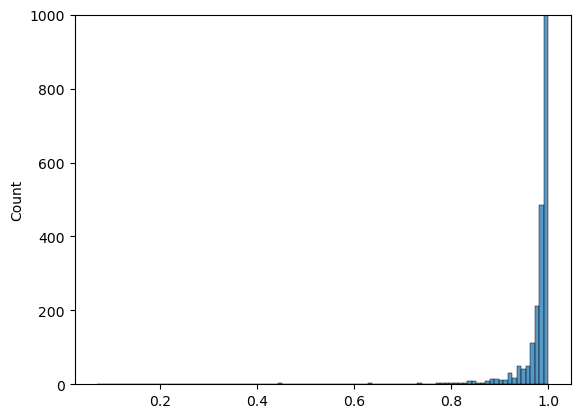

In [27]:
# Initialize an empty list to store staged predictions
staged_proba6 = []

# Loop through each stage and get the staged decision function
for proba in ada6.staged_predict_proba(X_test_100_Aut):
    staged_proba6.append(proba)

temp_serie=pd.Series(staged_proba6[49][:,0])
sns.histplot(x=temp_serie.values,bins=100)
plt.ylim(0,1000)
plt.show()

In [28]:
# Initialize an empty list to store staged predictions
staged_predictions = []

# Loop through each stage and get the staged decision function
for stage_predictions in ada6.staged_decision_function(X_test_100_Aut):
    staged_predictions.append(stage_predictions)

In [32]:
len(staged_predictions[1])

61502

# Utilisation de LGBM comme classif avec proba


In [70]:
# LightGBM parameters found by Bayesian optimization
clf = LGBMClassifier(
                    nthread=4,
                    n_estimators=10000,
                    learning_rate=0.02,
                    num_leaves=34,
                    colsample_bytree=0.9497036,
                    subsample=0.8715623,
                    max_depth=8,
                    reg_alpha=0.041545473,
                    reg_lambda=0.0735294,
                    min_split_gain=0.0222415,
                    min_child_weight=39.3259775,
                    silent=-1,
                    verbose=-1)

temps1 = time.time()

clf.fit(X_train_100.loc[id_random],y_train_0.loc[id_random], 
    eval_metric= 'auc')

duration1=time.time()-temps1
print("temps de training ", "%5.2f" % duration1, "secondes")





2023/10/12 17:28:27 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'ebdb77ebe4944396bf66a13db591ba29', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current lightgbm workflow


temps de training  70.42 secondes


In [71]:
y_pred_probalgbm=clf.predict_proba(X_test_100)[:,1]
y_pred_lgbm=clf.predict(X_test_100)

In [72]:
scores(y_test_0,y_pred_lgbm)

 precision_test = 0.102 
 accuracy_test = 0.9156 
 ARI_test = 0.0781 
 Balanced_accuracy = 0.5264 
 F1-score = 0.1055


In [73]:
pd.crosstab(y_test_0,y_pred_lgbm)

col_0,0.0,1.0
TARGET,,
0.0,56006,441
1.0,4749,306


In [52]:
# LightGBM parameters found by Bayesian optimization
clf2 = LGBMClassifier(
                    nthread=4,
                    n_estimators=10000,
                    learning_rate=0.02,
                    num_leaves=34,
                    colsample_bytree=0.9497036,
                    subsample=0.8715623,
                    max_depth=10,
                    silent=-1,
                    verbose=-1)

temps1 = time.time()

clf2.fit(X_train_100.loc[id_random],y_train_0.loc[id_random], 
    eval_metric= 'auc')

duration1=time.time()-temps1
print("temps de training ", "%5.2f" % duration1, "secondes")



2023/10/11 11:14:51 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '214bdcf66fe44900aa911d0628d2aec3', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current lightgbm workflow


temps de training  66.55 secondes


In [53]:
y_pred_lgbm_2=clf2.predict(X_test_100)

In [54]:
scores(y_test_0,y_pred_lgbm_2)

 precision_test = 0.0875 
 accuracy_test = 0.9173 
 ARI_test = 0.0222 
 Balanced_accuracy = 0.5068 
 F1-score = 0.0301


In [55]:
pd.crosstab(y_test_0,y_pred_lgbm_2)

col_0,0.0,1.0
TARGET,,
0.0,56338,109
1.0,4976,79


In [32]:
X_test_100.head()


,EXT_SOURCE_3,PAYMENT_RATE,EXT_SOURCE_2,DAYS_BIRTH,EXT_SOURCE_1,DAYS_EMPLOYED,DAYS_EMPLOYED_PERC,DAYS_REGISTRATION,DAYS_ID_PUBLISH,INDEX,...,CLOSED_DAYS_CREDIT_MIN,HOUR_APPR_PROCESS_START,PREV_AMT_CREDIT_MEAN,APPROVED_APP_CREDIT_PERC_MIN,CLOSED_DAYS_CREDIT_ENDDATE_MIN,PREV_NAME_TYPE_SUITE_NAN_MEAN,PREV_RATE_DOWN_PAYMENT_MEAN,INSTAL_PAYMENT_PERC_VAR,TOTALAREA_MODE,INSTAL_AMT_INSTALMENT_SUM
ID,,,,,,,,,,,,,,,,,,,,,
108234,0.9793,0.4641,-0.0694,-0.0646,1.8594,0.9196,-1.0757,1.0364,-1.5137,-1.6524,...,-0.7225,-0.0194,-0.3176,0.3079,-0.3132,-0.9751,2.1705,-0.4648,-1.2149,-0.5144
185062,-0.0000,-0.1094,-0.8620,1.3121,0.0000,0.5073,-0.2465,0.2090,0.0074,-0.9057,...,0.5403,-1.2442,-0.7907,0.1396,0.1148,0.8437,0.3981,0.9757,-0.5572,-0.4658
190324,0.1297,-0.1644,0.8678,1.3155,-0.8442,-0.1015,0.7903,-1.2101,0.0339,-0.8544,...,-0.5046,1.5116,0.7561,0.5514,-0.5309,1.6232,-0.9702,-0.4648,-0.8097,-0.5126
429675,0.3948,-0.2320,-1.4181,-1.1826,0.0000,-0.0000,0.0000,0.2947,-0.9373,1.4746,...,1.5431,-0.3256,-1.0258,0.5670,1.1369,1.6232,0.2094,-0.4648,0.0000,-0.7549
318237,-0.0000,-0.6554,0.9737,0.8254,0.0000,0.3009,-0.1354,-0.3324,-0.6498,0.3885,...,0.6537,1.2054,0.3923,0.4184,0.9718,-1.4948,0.3197,-0.4648,-0.5896,-0.2020


In [59]:
base.loc[base.index.isin(X_test_100.index),'AMT_CREDIT']

ID
100002   -0.4781
100007   -0.2137
100009    2.3894
100014    0.1329
100022   -1.0970
           ...  
456235    1.1905
456236    2.4248
456240   -0.6498
456242    1.7717
456253    0.1954
Name: AMT_CREDIT, Length: 61502, dtype: float64

In [71]:
temp=pd.Series(y_pred_lgbm,index=y_test_0.index)
temp

ID
108234    0.0
185062    0.0
190324    0.0
429675    0.0
318237    0.0
         ... 
344036    0.0
425591    0.0
251935    0.0
161979    0.0
386926    0.0
Length: 61502, dtype: float64

In [ ]:
y_pred_probalgbm

array([0.00024747, 0.01418716, 0.00109828, ..., 0.00025221, 0.00408415,
       0.00222284])

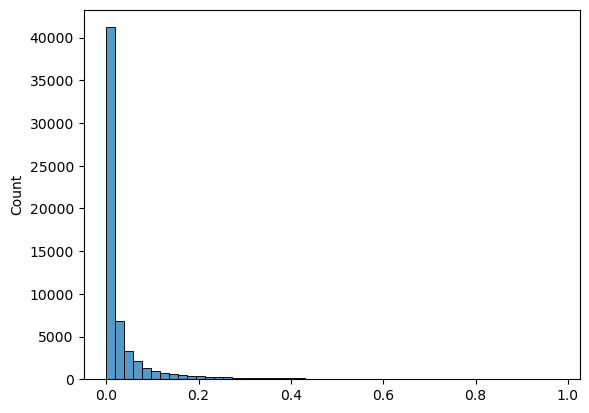

In [ ]:
sns.histplot(y_pred_probalgbm,bins=50)
plt.show()

In [ ]:
y_test_0.value_counts()

TARGET
0.0    56447
1.0     5055
Name: count, dtype: int64

In [ ]:
# on compte le nombre de valeurs positives dans le jeu réel
y_test_0.sum()

5055.0

In [ ]:
# y_test_ contient des 0 et des 1 donc la somme donne le nombre de valeurs 1
# on détermine le seuil de atteint par la proba en comptant un nombre de valeurs égales à celui des effectifs positifs de l'échantillon réel
seuil=np.sort(y_pref_probalgbm)[len(y_test_0)-int(y_test_0.sum())]
seuil

0.14104271664568274

In [ ]:
# la prédiction retouchée est alors basée sur le seuil établi 
y_pred_lgbm=pd.Series(y_pref_probalgbm,index=y_test_0.index,name='pred')
y_pred_lgbm=y_pred_lgbm.apply(lambda x: 0 if x<seuil else 1)



## Explo: Définition d'un df cout/gain

In [85]:
base['AMT_CREDIT_POS']=base['AMT_CREDIT']-base['AMT_CREDIT'].min()

In [86]:
base[['AMT_CREDIT','AMT_CREDIT_POS']].describe()

,AMT_CREDIT,AMT_CREDIT_POS
count,307507.000000,307507.000000
mean,-0.000002,1.376498
std,1.000004,1.000004
min,-1.376500,0.000000
25%,-0.817500,0.559000
50%,-0.212400,1.164100
75%,0.520800,1.897300
max,8.574000,9.950500


In [33]:
# tx_rendement=0.1
# tx_recouvrement=0.3

In [34]:
# impact_model_train=pd.DataFrame(base['TARGET'],index=X_train_100.index)
# impact_model_train['Prets']=base.loc[X_train_100.index,'AMT_CREDIT_POS'].copy()


In [35]:
# impact_model_train['Gain']=(base.loc[X_train_100.index,'AMT_CREDIT_POS']*(1-base.loc[X_train_100.index,'TARGET'])*tx_rendement).copy()

In [36]:
# impact_model_train['Perte']=(base.loc[X_train_100.index,'AMT_CREDIT_POS']*(base.loc[X_train_100.index,'TARGET'])*(1-tx_recouvrement)).copy()

In [37]:
# def recap_gain_v0(df):
#     print('Valeur des prêts =',round(impact_model_train['Prets'].sum(),2))
#     print('Gain de rendement des prêts remboursés =',round(impact_model_train['Gain'].sum(),2))
#     print('Perte liées aux prêts non remboursés =',round(impact_model_train['Perte'].sum(),2))
#     rdmt_ptf=(impact_model_train['Gain'].sum()-impact_model_train['Perte'].sum())/impact_model_train['Prets'].sum()
#     print('Rendement global (Gain-Perte)/Valeur =',round(rdmt_ptf,4)*100,'%')


In [38]:
# recap_gain_v0(impact_model_train)

In [39]:
# def recap_gain_txt(valeur_pret,indic_pb_paie,tx_rdmt,tx_rcvrmt):
#     temp=pd.DataFrame(index=valeur_pret.index)
#     if valeur_pret.min()<0:
#         temp['Prets']=(valeur_pret-valeur_pret.min()).copy()
#     else:
#         temp['Prets']=valeur_pret.copy()
    
#     #indic_pb_paie : 0 si ok => gain=pret *tx_ rdmt, 1 si pb => perte=pret*(1-tx_rcvrmt)
#     temp['Gain']=(temp['Prets']*(1-indic_pb_paie)*tx_rdmt).copy()
#     temp['Perte']=(temp['Prets']*indic_pb_paie*(1-tx_rcvrmt)).copy()
                   
#     print('Valeur des prêts =',round(temp['Prets'].sum(),2))
#     print('Gain de rendement des prêts remboursés =',round(temp['Gain'].sum(),2))
#     print('Perte liées aux prêts non remboursés =',round(temp['Perte'].sum(),2))
#     rdmt_ptf=(temp['Gain'].sum()-temp['Perte'].sum())/temp['Prets'].sum()
#     print('Rendement global (Gain-Perte)/Valeur =',round(rdmt_ptf,4)*100,'%')
    

In [40]:
# def recap_gain_nbr(valeur_pret,indic_pb_paie,tx_rdmt,tx_rcvrmt):
#     temp=pd.DataFrame(index=valeur_pret.index)
#     if valeur_pret.min()<0:
#         temp['Prets']=(valeur_pret-valeur_pret.min()).copy()
#     else:
#         temp['Prets']=valeur_pret.copy()
    
#     #indic_pb_paie : 0 si ok => gain=pret *tx_ rdmt, 1 si pb => perte=pret*(1-tx_rcvrmt)
#     temp['Gain']=(temp['Prets']*(1-indic_pb_paie)*tx_rdmt).copy()
#     temp['Perte']=(temp['Prets']*indic_pb_paie*(1-tx_rcvrmt)).copy()
                   
#     rdmt_ptf=(temp['Gain'].sum()-temp['Perte'].sum())/temp['Prets'].sum()
#     return round(rdmt_ptf,4)*100

In [41]:
# recap_gain_txt(base.loc[X_train_100.index,'AMT_CREDIT'],base.loc[X_train_100.index,'TARGET'],0.15,0.3)

In [42]:
# recap_gain_nbr(base.loc[X_train_100.index,'AMT_CREDIT'],base.loc[X_train_100.index,'TARGET'],0.15,0.3)

In [43]:
# np.linspace(0,1,11)

In [44]:
# visu=pd.DataFrame(index=np.linspace(0,0.5,11),columns=np.linspace(0,0.5,11),dtype=float)
# for i in visu.index:
#     for j in visu.columns:
#         visu.at[i,j]=recap_gain_nbr(base.loc[X_train_100.index,'AMT_CREDIT'],base.loc[X_train_100.index,'TARGET'],i,j)
# visu

In [45]:
# sns.heatmap(visu)

In [161]:
visu=pd.DataFrame(index=np.linspace(0,0.1,11),columns=np.linspace(0,0.4,11),dtype=float)
for i in visu.index:
    for j in visu.columns:
        visu.at[i,j]=recap_gain_nbr(base.loc[X_train_100.index,'AMT_CREDIT'],base.loc[X_train_100.index,'TARGET'],i,j)
visu

,0.00,0.04,0.08,0.12,0.16,0.20,0.24,0.28,0.32,0.36,0.40
0.00,-7.42,-7.12,-6.82,-6.53,-6.23,-5.93,-5.64,-5.34,-5.04,-4.75,-4.45
0.01,-6.49,-6.19,-5.90,-5.60,-5.30,-5.01,-4.71,-4.41,-4.12,-3.82,-3.52
0.02,-5.57,-5.27,-4.97,-4.68,-4.38,-4.08,-3.79,-3.49,-3.19,-2.90,-2.60
0.03,-4.64,-4.34,-4.05,-3.75,-3.45,-3.16,-2.86,-2.56,-2.27,-1.97,-1.67
0.04,-3.71,-3.42,-3.12,-2.82,-2.53,-2.23,-1.93,-1.64,-1.34,-1.04,-0.75
0.05,-2.79,-2.49,-2.19,-1.90,-1.60,-1.30,-1.01,-0.71,-0.41,-0.12,0.18
0.06,-1.86,-1.57,-1.27,-0.97,-0.68,-0.38,-0.08,0.21,0.51,0.81,1.10
0.07,-0.94,-0.64,-0.34,-0.05,0.25,0.55,0.84,1.14,1.44,1.73,2.03
0.08,-0.01,0.29,0.58,0.88,1.18,1.47,1.77,2.07,2.36,2.66,2.96
0.09,0.92,1.21,1.51,1.81,2.10,2.40,2.70,2.99,3.29,3.59,3.88


<Axes: >

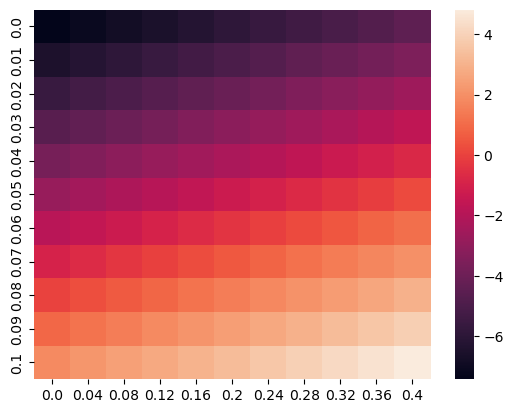

In [162]:
sns.heatmap(visu)

In [46]:
# base.loc[base.index.isin(X_test_100.index),'AMT_CREDIT']

In [63]:
df_result['lgbm']=y_pred_lgbm
df_result['erreurs']=list(zip(df_result['pred16'],df_result['pred17'],df_result['TARGET'],df_result['lgbm']))

In [96]:
grille=df_result.value_counts()
grille

TARGET  pred16  pred17  erreurs             lgbm
0.0     0.0     0.0     (0.0, 0.0, 0.0, 0)  0       33562
                1.0     (0.0, 1.0, 0.0, 0)  0       11155
        1.0     0.0     (1.0, 0.0, 0.0, 0)  0        5158
                1.0     (1.0, 1.0, 0.0, 0)  0        2792
1.0     0.0     0.0     (0.0, 0.0, 1.0, 0)  0        1584
0.0     1.0     1.0     (1.0, 1.0, 0.0, 1)  1        1189
                0.0     (1.0, 0.0, 0.0, 1)  1        1049
1.0     0.0     1.0     (0.0, 1.0, 1.0, 0)  0         888
0.0     0.0     1.0     (0.0, 1.0, 0.0, 1)  1         811
1.0     1.0     0.0     (1.0, 0.0, 1.0, 0)  0         743
0.0     0.0     0.0     (0.0, 0.0, 0.0, 1)  1         731
1.0     1.0     1.0     (1.0, 1.0, 1.0, 1)  1         576
                        (1.0, 1.0, 1.0, 0)  0         565
                0.0     (1.0, 0.0, 1.0, 1)  1         373
        0.0     1.0     (0.0, 1.0, 1.0, 1)  1         188
                0.0     (0.0, 0.0, 1.0, 1)  1         138
Name: count, dtype: int

In [97]:
df_result.loc[df_result['TARGET']==1].value_counts()

TARGET  pred16  pred17  erreurs             lgbm
1.0     0.0     0.0     (0.0, 0.0, 1.0, 0)  0       1584
                1.0     (0.0, 1.0, 1.0, 0)  0        888
        1.0     0.0     (1.0, 0.0, 1.0, 0)  0        743
                1.0     (1.0, 1.0, 1.0, 1)  1        576
                        (1.0, 1.0, 1.0, 0)  0        565
                0.0     (1.0, 0.0, 1.0, 1)  1        373
        0.0     1.0     (0.0, 1.0, 1.0, 1)  1        188
                0.0     (0.0, 0.0, 1.0, 1)  1        138
Name: count, dtype: int64

In [99]:

df_result.drop(['erreurs'],axis=1,inplace=True)
df_result['erreurs']=list(zip(df_result['TARGET'],df_result['pred16'],df_result['pred17'],df_result['lgbm']))

In [122]:
grille=df_result.drop('erreurs',axis=1).value_counts().sort_index(level=[1,2,3], ascending=[True,True,True])
grille

TARGET  pred16  pred17  lgbm
0.0     0.0     0.0     0       33562
1.0     0.0     0.0     0        1584
0.0     0.0     0.0     1         731
1.0     0.0     0.0     1         138
0.0     0.0     1.0     0       11155
1.0     0.0     1.0     0         888
0.0     0.0     1.0     1         811
1.0     0.0     1.0     1         188
0.0     1.0     0.0     0        5158
1.0     1.0     0.0     0         743
0.0     1.0     0.0     1        1049
1.0     1.0     0.0     1         373
0.0     1.0     1.0     0        2792
1.0     1.0     1.0     0         565
0.0     1.0     1.0     1        1189
1.0     1.0     1.0     1         576
Name: count, dtype: int64

In [131]:
print('',grille[:,0,0,0][0]/grille[:,0,0,0].sum(),'\n',
grille[:,1,0,0][0]/grille[:,1,0,0].sum(),'\n',
grille[:,1,1,0][0]/grille[:,1,1,0].sum(),'\n',
grille[:,1,1,1][0]/grille[:,1,1,1].sum(),'\n',
grille[:,0,1,0][0]/grille[:,0,1,0].sum(),'\n',
grille[:,0,0,1][0]/grille[:,0,0,1].sum(),'\n',
grille[:,1,0,1][0]/grille[:,1,0,1].sum(),'\n',
grille[:,0,1,1][0]/grille[:,0,1,1].sum(),'\n'

)

 0.9549308598418028 
 0.8740891374343331 
 0.8316949657432231 
 0.6736543909348441 
 0.9262642198787677 
 0.8411967779056386 
 0.7376933895921237 
 0.8118118118118118 

